# Information Retrieval - Image Event Detection - Paolo Cortis

Running experiments with different pipelines and machine learning models for a multi class image event classification task on soccer images.

## Libraries

In [1]:
import os
import cv2
from skimage import transform
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations, layers, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from extra_keras_metrics import get_standard_binary_metrics, get_minimal_multiclass_metrics
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
soccer_images_dim = 80

## Data Retrieval
Import of the main datasets used:  
  
*For model training and evaluation*
* Soccer Events: images of the soccer events to classify.
* Generic Events: images of generic soccer scenes (not events) and random images.  

*For further model evaluation, more diverse soccer and random images*  
* Real Soccer: few images of the soccer events (not from the football analysis dataset).
* Test dataset: few soccer and random images (not from soccer and generic events dataset).

In [3]:
def loadData(root, rgb):
    """ Return images from the dataset with the corresponding label from a root directory.

    Parameters
    ------------------------
    root: str
        The root folder with dataset.
    rgb: bool
        Specify whether to import images in rgb or gray scale.
        
    Returns
    ------------------------
    data: dict
        A dictionary with data images.
    folder_labels: list
        A list with the images labels."""
    
    data = {}
    folder_labels = []
    
    for folder_name in os.listdir(root):
        folder_path = os.path.join(root, folder_name)
    
        # Check if the item is a directory
        if os.path.isdir(folder_path):
            folder_files = []
            
            for file_name in os.listdir(folder_path):
                img = cv2.imread(os.path.join(folder_path, file_name))
                if img is not None:
                    resizedImg = cv2.resize(img, (soccer_images_dim,soccer_images_dim), interpolation=cv2.INTER_CUBIC)
                    RGBImg = cv2.cvtColor(resizedImg, cv2.COLOR_BGR2RGB)
                    if rgb == False:
                        grayImg = cv2.cvtColor(RGBImg, cv2.COLOR_RGB2GRAY)
                        folder_files.append(grayImg)
                    else:
                        folder_files.append(RGBImg)
                    folder_labels.append(folder_name)

            data[folder_name] = folder_files

    return data, folder_labels

In [10]:
# Soccer events
folderSoccer = r'D:\MachineLearning\Datasets\Soccer\TrainTestSoccer'
# Generic soccer and random events
folderGenericEvents = r'D:\MachineLearning\Datasets\Soccer\GenericEvents'
# Broadly different soccer events images)
folderRSoccer = r'D:\MachineLearning\Datasets\Soccer\RealSoccer'
# RealSoccer + events and genericSoccer images
folderMyTestDataset = r'D:\MachineLearning\Datasets\Soccer\myDataset'

data_soccer, labels_soccer = loadData(folderSoccer, False)
data_soccer_rgb, _ = loadData(folderSoccer, True)
data_generic_events, labels_generic_events = loadData(folderGenericEvents, False)
real_data_soccer, real_labels_soccer = loadData(folderRSoccer, False)
data_myTest, labels_myTest = loadData(folderMyTestDataset, False)

In [14]:
# Save datasets
import pickle

# Save Dataset (save dictionary to data_soccer.pkl file)
with open('data/data_soccer.pkl', 'wb') as fp:
    pickle.dump(data_soccer, fp)
    print('dictionary saved successfully to file')
    
# Save Dataset (save dictionary to data_soccer_rgb.pkl file)
with open('data/data_soccer_rgb.pkl', 'wb') as fp:
    pickle.dump(data_soccer_rgb, fp)
    print('dictionary saved successfully to file')
    
# Save Dataset (save dictionary to labels_soccer.pkl file)
with open('data/labels_soccer.pkl', 'wb') as fp:
    pickle.dump(labels_soccer, fp)
    print('dictionary saved successfully to file')
    
# Save Dataset (save dictionary to data_generic_events.pkl file)
with open('data/data_generic_events.pkl', 'wb') as fp:
    pickle.dump(data_generic_events, fp)
    print('dictionary saved successfully to file')
    
# Save Dataset (save dictionary to labels_generic_events.pkl file)
with open('data/labels_generic_events.pkl', 'wb') as fp:
    pickle.dump(labels_generic_events, fp)
    print('dictionary saved successfully to file')
    
# Save Dataset (save dictionary to real_data_soccer.pkl file)
with open('data/real_data_soccer.pkl', 'wb') as fp:
    pickle.dump(real_data_soccer, fp)
    print('dictionary saved successfully to file')
    
# Save Dataset (save dictionary to real_labels_soccer.pkl file)
with open('data/real_labels_soccer.pkl', 'wb') as fp:
    pickle.dump(real_labels_soccer, fp)
    print('dictionary saved successfully to file')
    
# Save Dataset (save dictionary to data_myTest.pkl file)
with open('data/data_myTest.pkl', 'wb') as fp:
    pickle.dump(data_myTest, fp)
    print('dictionary saved successfully to file')
    
# Save Dataset (save dictionary to labels_myTest.pkl file)
with open('data/labels_myTest.pkl', 'wb') as fp:
    pickle.dump(labels_myTest, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file
dictionary saved successfully to file
dictionary saved successfully to file
dictionary saved successfully to file
dictionary saved successfully to file
dictionary saved successfully to file
dictionary saved successfully to file
dictionary saved successfully to file
dictionary saved successfully to file


In [4]:
# Load datasets
import pickle

# Load Dataset (Read dictionary pkl file)
with open('data/data_soccer.pkl', 'rb') as fp:
    data_soccer = pickle.load(fp)
    
# Load Dataset (Read dictionary pkl file)
with open('data/data_soccer_rgb.pkl', 'rb') as fp:
    data_soccer_rgb = pickle.load(fp)
    
with open('data/labels_soccer.pkl', 'rb') as fp:
    labels_soccer = pickle.load(fp)
    
with open('data/data_generic_events.pkl', 'rb') as fp:
    data_generic_events = pickle.load(fp)
    
with open('data/labels_generic_events.pkl', 'rb') as fp:
    labels_generic_events = pickle.load(fp)
    
with open('data/real_data_soccer.pkl', 'rb') as fp:
    real_data_soccer = pickle.load(fp)
    
with open('data/real_labels_soccer.pkl', 'rb') as fp:
    real_labels_soccer = pickle.load(fp)
    
with open('data/data_myTest.pkl', 'rb') as fp:
    data_myTest = pickle.load(fp)
    
with open('data/labels_myTest.pkl', 'rb') as fp:
    labels_myTest = pickle.load(fp)

## Data preprocessing and visualization

-- Soccer Events and real soccer events Dataset --
[n.images, (width, height, depth)]
--- Cards ---
Soccer shape: 6000 (80, 80)
Real soccer shape: 10 (80, 80)
--- Center ---
Soccer shape: 6000 (80, 80)
Real soccer shape: 10 (80, 80)
--- Corner ---
Soccer shape: 6000 (80, 80)
Real soccer shape: 10 (80, 80)
--- Free-Kick ---
Soccer shape: 6000 (80, 80)
Real soccer shape: 10 (80, 80)
--- Left ---
Soccer shape: 6000 (80, 80)
Real soccer shape: 10 (80, 80)
--- Penalty ---
Soccer shape: 6000 (80, 80)
Real soccer shape: 10 (80, 80)
--- Right ---
Soccer shape: 6000 (80, 80)
Real soccer shape: 10 (80, 80)
--- Tackle ---
Soccer shape: 6000 (80, 80)
Real soccer shape: 10 (80, 80)
--- To Substitue ---
Soccer shape: 5999 (80, 80)
Real soccer shape: 10 (80, 80)
------------------------------
Soccer label: Cards
Real soccer label: Center


(<Axes: >, <matplotlib.image.AxesImage at 0x246e3f8feb0>)

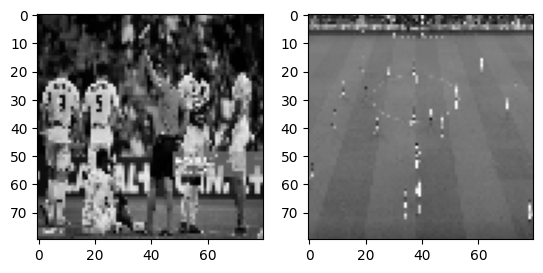

In [5]:
print("-- Soccer Events and real soccer events Dataset --")
print("[n.images, (width, height, depth)]")
for folder in (data_soccer):
    print(f"--- {folder} ---")
    print(f"Soccer shape: {len(data_soccer[folder])} {data_soccer[folder][1].shape}")
    print(f"Real soccer shape: {len(real_data_soccer[folder])} {real_data_soccer[folder][1].shape}")

soccer_sample = data_soccer['Cards'][22]
real_soccer_sample = real_data_soccer['Center'][1]

print("-"*30)

print(f"Soccer label: {labels_soccer[22]}")
print(f"Real soccer label: {real_labels_soccer[11]}")

plt.subplot(1,2,1),plt.imshow(soccer_sample, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,2,2),plt.imshow(real_soccer_sample, cmap='gray', vmin=0, vmax=255)

-- Generic Events Dataset --
[n.images, (width, height, depth)]
--- Random ---
Soccer shape: 1400 (80, 80)
--- Soccer ---
Soccer shape: 1200 (80, 80)
------------------------------
Label: Soccer
Label: Random


(<Axes: >, <matplotlib.image.AxesImage at 0x246e60dafd0>)

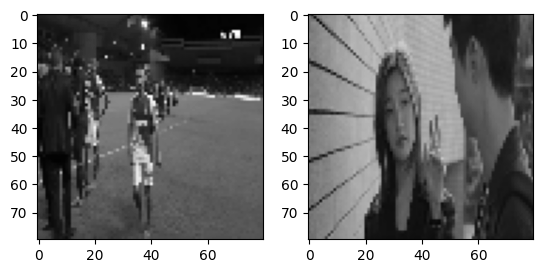

In [6]:
print("-- Generic Events Dataset --")
print("[n.images, (width, height, depth)]")
for folder in (data_generic_events):
    print(f"--- {folder} ---")
    print(f"Soccer shape: {len(data_generic_events[folder])} {data_generic_events[folder][1].shape}")
    
generic_soccer_sample = data_generic_events['Soccer'][20]
random_image_sample = data_generic_events['Random'][20]

print("-"*30)

print(f"Label: {labels_generic_events[1420]}")
print(f"Label: {labels_generic_events[20]}")

plt.subplot(1,2,1),plt.imshow(generic_soccer_sample, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,2,2),plt.imshow(random_image_sample, cmap='gray', vmin=0, vmax=255)

-- myTest Dataset --
[n.images, (width, height, depth)]
--- Cards ---
Soccer shape: 10 (80, 80)
--- Center ---
Soccer shape: 10 (80, 80)
--- Corner ---
Soccer shape: 10 (80, 80)
--- Events ---
Soccer shape: 10 (80, 80)
--- Free-Kick ---
Soccer shape: 10 (80, 80)
--- Generic ---
Soccer shape: 10 (80, 80)
--- Left ---
Soccer shape: 10 (80, 80)
--- Penalty ---
Soccer shape: 10 (80, 80)
--- Right ---
Soccer shape: 10 (80, 80)
--- Tackle ---
Soccer shape: 10 (80, 80)
--- To Substitue ---
Soccer shape: 10 (80, 80)
------------------------------
Label: Cards
Label: Events


(<Axes: >, <matplotlib.image.AxesImage at 0x246ee822f70>)

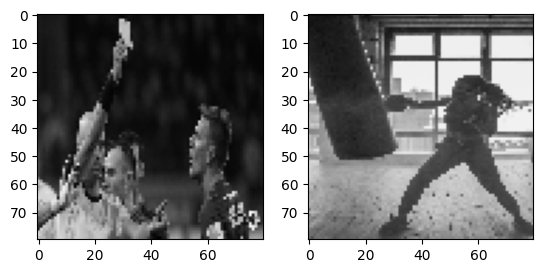

In [7]:
print("-- myTest Dataset --")
print("[n.images, (width, height, depth)]")
for folder in (data_myTest):
    print(f"--- {folder} ---")
    print(f"Soccer shape: {len(data_myTest[folder])} {data_myTest[folder][1].shape}")
    
generic_soccer_sample = data_myTest['Cards'][6]
random_image_sample = data_myTest['Events'][6]

print("-"*30)

print(f"Label: {labels_myTest[6]}")
print(f"Label: {labels_myTest[36]}")

plt.subplot(1,2,1),plt.imshow(generic_soccer_sample, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,2,2),plt.imshow(random_image_sample, cmap='gray', vmin=0, vmax=255)

### Label encoding

In [8]:
def one_hot_encoding(
    labels: pd.DataFrame,
    num_classes: int
) -> pd.DataFrame:
    """ Return the labels encoded with one-hot encoding.
    
    Parameters
    ------------------------
    labels: pd.DataFrame
        The labels to be one-hot encoded.
    num_classes: int
        The number of classes.

    Returns
    ------------------------
    pd.DataFrame: pd.DataFrame
        The one-hot encoded labels."""
    
    return pd.DataFrame(to_categorical(labels, num_classes))

In [9]:
n_generic_soccer_samples = labels_generic_events.count("Soccer")

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

print("Soccer Events Labels")
labels_soccer = pd.DataFrame(le.fit_transform(labels_soccer))
labels_soccer = one_hot_encoding(labels_soccer, 9)

print(labels_soccer.sample(3))

print("-"*30)

print("Real Soccer Events Labels")
real_labels_soccer = pd.DataFrame(le.fit_transform(real_labels_soccer))
real_labels_soccer = one_hot_encoding(real_labels_soccer, 9)

print(real_labels_soccer.sample(3))

print("-"*30)
print("Soccer Events + Generic Labels")
labels_soccer_with_generic = labels_soccer.copy()

labels_soccer_with_generic[9] = 0.0

new_rows = pd.DataFrame([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]] * n_generic_soccer_samples)
labels_soccer_with_generic = pd.concat([labels_soccer_with_generic, new_rows])

print(labels_soccer_with_generic.sample(3))

print("-"*30)

print("Generic Events Labels")
labels_generic_events = pd.DataFrame(le.fit_transform(labels_generic_events))
labels_generic_events = one_hot_encoding(labels_generic_events, 2)

print(labels_generic_events.sample(3))

print("-"*30)

print("my Test Labels")
labels_myTest = pd.DataFrame(le.fit_transform(labels_myTest))
labels_myTest = one_hot_encoding(labels_myTest, 11)

print(labels_myTest.sample(3))

Soccer Events Labels
         0    1    2    3    4    5    6    7    8
22536  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
13976  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
43885  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
------------------------------
Real Soccer Events Labels
      0    1    2    3    4    5    6    7    8
71  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
28  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
48  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
------------------------------
Soccer Events + Generic Labels
         0    1    2    3    4    5    6    7    8    9
12044  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
46546  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
7338   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
------------------------------
Generic Events Labels
        0    1
1347  1.0  0.0
2438  0.0  1.0
2381  0.0  1.0
------------------------------
my Test Labels
     0    1    2    3    4    5    6    7    8    9    10
49  0.0  0.0  0.0  0.0 

### Data Augmentation
Function to perform data augmentation to expand the dataset size and improve generalization capabilities.

In [11]:
def augment_image(input_image):
    """ Return the augmented input image (randomly applies rotation, shear, zoom, crop, flip, brightness adjust)

    Parameters
    ------------------------
    input_image: np.array
        The input image.

    Returns
    ------------------------
    np.array: np.array
        The augmented image."""

    # Randomly rotate the image (between -30 and 30 degrees)
    height, width = input_image.shape[:2]
    angle = random.randint(-30, 30)
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    input_image = cv2.warpAffine(input_image, rotation_matrix, (width, height))
    
    # Apply shearing (0.15)
    shear_value = random.uniform(-0.15, 0.15)
    shear_matrix = np.array([[1.0, shear_value, 0.0], [0.0, 1.0, 0.0]])
    input_image = cv2.warpAffine(input_image, shear_matrix, (width, height))
    input_image = np.expand_dims(input_image, axis=-1)
    
    # Randomly zoom (scaling factor between 0.9 and 1.1)
    zoom_factor = tf.random.uniform(shape=[], minval=0.9, maxval=1.1)
    new_size = tf.cast(tf.shape(input_image)[:2], tf.float32) * zoom_factor
    input_image = tf.image.resize(input_image, tf.cast(new_size, tf.int32))

    # Randomly crop (90% of the original size)
    crop_size = tf.cast(tf.shape(input_image)[:2] * 0.9, tf.int32)
    input_image = tf.image.random_crop(input_image, size=[crop_size[0], crop_size[1], 1])
    
    # Randomly adjust brightness (by 0.2)
    input_image = tf.image.random_brightness(input_image, max_delta=0.2)
    
    # Reshape the augmented image
    input_image = np.array(input_image)
    input_image = cv2.resize(input_image, (soccer_images_dim,soccer_images_dim), interpolation=cv2.INTER_CUBIC)
    input_image = input_image.reshape(soccer_images_dim, soccer_images_dim, 1)
    
    return input_image

-- Just for explanatory purpose --


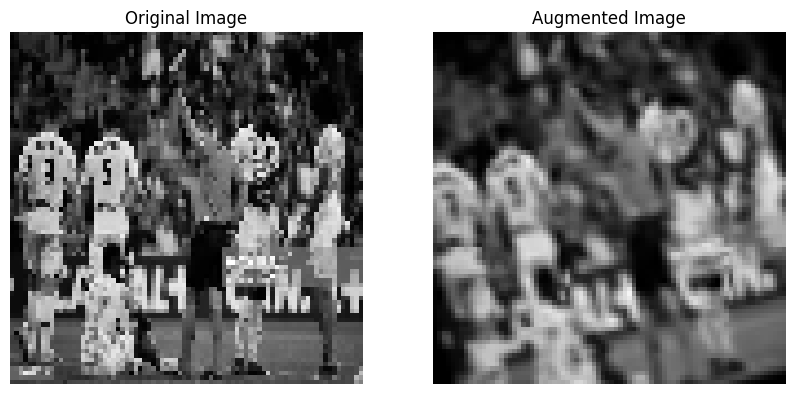

In [12]:
print("-- Just for explanatory purpose --")

# Augment the image
input_image = np.expand_dims(soccer_sample, axis=-1)
augmented_image = augment_image(input_image)

# Display the original and augmented images
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(soccer_sample, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Augmented Image')
plt.imshow(augmented_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.show()

## Learning

The technique used to generate the holdouts for the evaluation of the various architectures is the **stratified Monte-Carlo** method, producing each time a different arrangement of the *training* and *testing* set, while keeping roughly the same class balance.

2 holdouts are considered to train and evaluate each model, 20% of the whole dataset is used for testing, 80% for training.

Below are also some functions to perform the training and evaluation of models.

In [13]:
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits = number_of_splits,
    test_size = 0.2,
    random_state = 42
)

In [14]:
def train_model(
    model: tf.keras.Model,
    x_train: np.ndarray,
    x_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    epochs: int,
    batch_size: int
):
    """ Train the model and return the performance metrics (accuracy, AUROC, AUPRC) for train and test and the training history.
    
    Parameters
    ------------------------
    model: tf.keras.Model
        The model to train.
    x_train: np.ndarray
        The input data for training.
    x_test: np.ndarray
        The input data for testing.
    y_train: np.ndarray
        The labels of the input data for training.
    y_test: np.ndarray
        The labels of the input data for testing.
    epochs: int
        The number of times the learning algorithm works through the dataset.
    batch_size: int
        The number of samples to work through before updating the model.

    Returns
    ------------------------
    The performance metrics and history of the model."""
    
    model_history = model.fit(
        x_train, y_train,
        validation_data = (x_test, y_test),
        epochs = epochs,
        batch_size = batch_size,
        callbacks = [EarlyStopping("val_loss", patience=2)]
    )

    train_evaluation = model.evaluate(x_train, y_train, return_dict=True)
    test_evaluation = model.evaluate(x_test, y_test, return_dict=True)
    
    metrics = {"train_evaluation": train_evaluation, "test_evaluation": test_evaluation}
    
    
    return metrics, model_history

In [15]:
def train_model_cp(
    model: tf.keras.Model,
    x_train: np.ndarray,
    x_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    epochs: int,
    batch_size: int,
    cp: keras.callbacks.ModelCheckpoint
):
    """ Train the model with checkpoints and return the performance metrics (accuracy, AUROC, AUPRC) for train and test and the training history.
    
    Parameters
    ------------------------
    model: tf.keras.Model
        The model to train.
    x_train: np.ndarray
        The input data for training.
    x_test: np.ndarray
        The input data for testing.
    y_train: np.ndarray
        The labels of the input data for training.
    y_test: np.ndarray
        The labels of the input data for testing.
    epochs: int
        The number of times the learning algorithm works through the dataset.
    batch_size: int
        The number of samples to work through before updating the model.
    cp: keras.callbacks.ModelCheckpoint
        Checkpoint callback.

    Returns
    ------------------------
    The performance metrics and history of the model."""
    
    model_history = model.fit(
        x_train, y_train,
        validation_data = (x_test, y_test),
        epochs = epochs,
        batch_size = batch_size,
        callbacks = [EarlyStopping("val_loss", patience=4), cp]
    )

    #train_evaluation = model.evaluate(x_train, y_train, return_dict=True)
    test_evaluation = model.evaluate(x_test, y_test, return_dict=True)
    
    #metrics = {"train_evaluation": train_evaluation, "test_evaluation": test_evaluation}
    metrics = {"test_evaluation": test_evaluation}
    
    return metrics, model_history

In [16]:
def get_predictions(
    model: tf.keras.Model,
    x_test: np.ndarray,
    batch_size: int
):
    """ Return the predictions of the model over the test data.
    
    Parameters
    ------------------------
    model: tf.keras.Model
        The model to train.
    x_test: np.ndarray
        The input data for testing.
    batch_size: int
        The number of samples to work through before updating the model.

    Returns
    ------------------------
    The predictions of the model over the test data."""
    
    test_predictions = model.predict(
        x_test,
        batch_size = batch_size
    )
    
    return test_predictions

#### Evaluate a model
Next are a set of functions to **evaluate** and **visualize** the performances of models.

To have a statistically sound estimate of an architecture performance, multiple models are built and trained, each with the same architecture, over different portions of the data (holdouts) and, the **average** performance of those, is considered as an estimate of the overall performance of the architecture.

In [17]:
def model_metrics_holdout_estimate(
    model_metrics: list,
    holdout_total_number: int
) -> dict[str, float]:
    """ Return the average metrics (accuracy, AUROC, AUPRC) of the model accross all the holdouts for train and test.
    
    Parameters
    ------------------------
    model_metrics: list
        The list with the train/test metrics (accuracy, AUROC, AUPRC) for all the holdouts.
    holdout_total_number: int
        The number of total holdouts.

    Returns
    ------------------------
    dict: dict[str, float]
        The average metrics of the model accross all the holdouts for train and test."""
    
    total_accuracy_train = 0
    total_accuracy_test = 0
    total_AUROC_train = 0
    total_AUROC_test = 0
    total_AUPRC_train = 0
    total_AUPRC_test = 0

    for holdout in model_metrics:
        total_accuracy_train += holdout["train_evaluation"]['accuracy']
        total_AUROC_train += holdout["train_evaluation"]['AUROC']
        total_AUPRC_train += holdout["train_evaluation"]['AUPRC']

    for holdout in model_metrics:
        total_accuracy_test += holdout["test_evaluation"]['accuracy']
        total_AUROC_test += holdout["test_evaluation"]['AUROC']
        total_AUPRC_test += holdout["test_evaluation"]['AUPRC']

    avg_accuracy_train = total_accuracy_train / holdout_total_number
    avg_accuracy_test = total_accuracy_test / holdout_total_number
    avg_AUROC_train = total_AUROC_train / holdout_total_number
    avg_AUROC_test = total_AUROC_test / holdout_total_number
    avg_AUPRC_train = total_AUPRC_train / holdout_total_number
    avg_AUPRC_test = total_AUPRC_test / holdout_total_number

    return {
        'accuracy_train': avg_accuracy_train,
        'accuracy_test': avg_accuracy_test,
        'AUROC_train': avg_AUROC_train,
        'AUROC_test': avg_AUROC_test,
        'AUPRC_train': avg_AUPRC_train,
        'AUPRC_test': avg_AUPRC_test,
    }

In [18]:
def plot_train_history(model_history):
    """ Plots the metrics (accuracy, AUROC, AUPRC) of the model across the epochs and for each holdout.
    
    Parameters
    ------------------------
    model_history: history
        The training record of the model."""

    for i in range(len(model_history)):
        fig = plt.figure(figsize=(12.7,4.51))
        fig.suptitle(str(i+1) + " Holdout")
        
        # Accuracy
        plt.subplot(1,3,1)
        plt.plot(model_history[i].history['accuracy'])
        plt.plot(model_history[i].history['val_accuracy'])
        plt.title('Accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        
        # AUROC
        plt.subplot(1,3,2)
        plt.plot(model_history[i].history['AUROC'])
        plt.plot(model_history[i].history['val_AUROC'])
        plt.title('AUROC')
        plt.ylabel('AUROC')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        
        # AUPRC
        plt.subplot(1,3,3)
        plt.plot(model_history[i].history['AUPRC'])
        plt.plot(model_history[i].history['val_AUPRC'])
        plt.title('AUPRC')
        plt.ylabel('AUPRC')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        plt.subplots_adjust(wspace=0.3)
        plt.show()

### CNN 
A convolutional neural network consists a set of **convolutional** layers (convolution+maxPooling) and a set of **dense** layer. To avoid overfitting of the model dropout layers were added in the dense portion.

Here is the function to build the main **model**.

In [19]:
def build_soccer_CNN(
    input_shape: tuple
) -> tf.keras.Model:
    """ Returns the basic soccer CNN model.

    Parameters
    ------------------------
    input_shape: tuple
        The shape of the input.

    Returns
    ------------------------
    model: model
        The soccer model."""

    CNN = Sequential(name="Soccer_CNN")
    CNN.add(layers.Input(input_shape))
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),

    CNN.add(layers.Flatten())
    
    for i in range(2):
        CNN.add(layers.Dense(units = 128, activation='relu'))
        CNN.add(layers.Dropout(0.5))
        
    CNN.add(layers.Dense(9, activation='softmax'))
    
    CNN.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=get_minimal_multiclass_metrics()
    )
    
    CNN.summary()
    
    return CNN

In [20]:
#data_soccer is a dict containing ['events'...] so put together classes to evaluate
data_soccer_all = []
for event in data_soccer:
    for element in data_soccer[event]:
        data_soccer_all.append(element)

print(f"Data shape: {np.array(data_soccer_all).shape}")
print(f"Labels shape: {labels_soccer.shape}")

Data shape: (53999, 80, 80)
Labels shape: (53999, 9)


In [21]:
data_soccer_all = [np.expand_dims(x, axis=-1) for x in data_soccer_all]

In [22]:
epochs = 100
batch_size = 14

### Main training loop - Soccer CNN
* Normalize images' values in 0-1 range.
* Build and train the model over the training set and test it over the test set for the different holdouts.

In [23]:
print("---- Soccer CNN ----")

CNN_metrics = []
CNN_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(data_soccer_all, labels_soccer))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data + Normalization
    x_train, x_test = np.array([data_soccer_all[x]/255 for x in train_indices]), np.array([data_soccer_all[x]/255 for x in test_indices])
    y_train, y_test = labels_soccer.iloc[train_indices], labels_soccer.iloc[test_indices]

    # Build CNN
    CNN = build_soccer_CNN(x_train[0].shape)

    print("- Training model:\n")
    CNN_holdout_metrics, CNN_holdout_history = train_model(
        CNN,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size
    )
    
    predictions = get_predictions(CNN, x_test, batch_size=batch_size)
    CNN_holdout_predictions.append(predictions)
    CNN_holdout_test_labels.append(y_test)

    CNN_metrics.append(CNN_holdout_metrics)
    CNN_history.append(CNN_holdout_history)
    
    CNN_models.append(CNN)

---- Soccer CNN ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Model: "Soccer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10

1it [06:01, 361.24s/it]

-- HOLDOUT 2
Model: "Soccer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10

2it [13:42, 411.15s/it]


CNN Soccer Metrics - 2-holdouts estimate:
Accuracy : train - 0.9707747995853424  --  test - 0.9263888895511627
AUROC : train - 0.9991893470287323  --  test - 0.9941038489341736
AUPRC : train - 0.9957385659217834  --  test - 0.9747623205184937
--------------------------------------------------------------------------------
CNN Soccer - Train history:


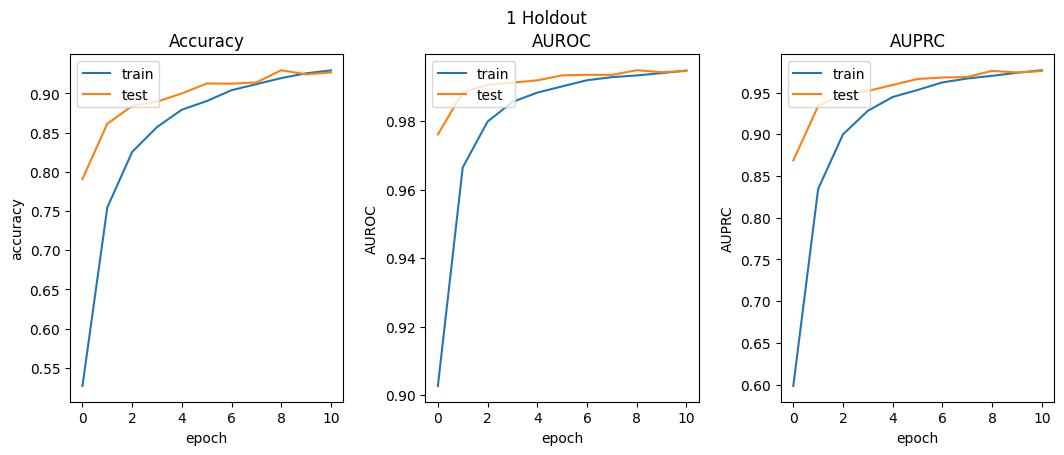

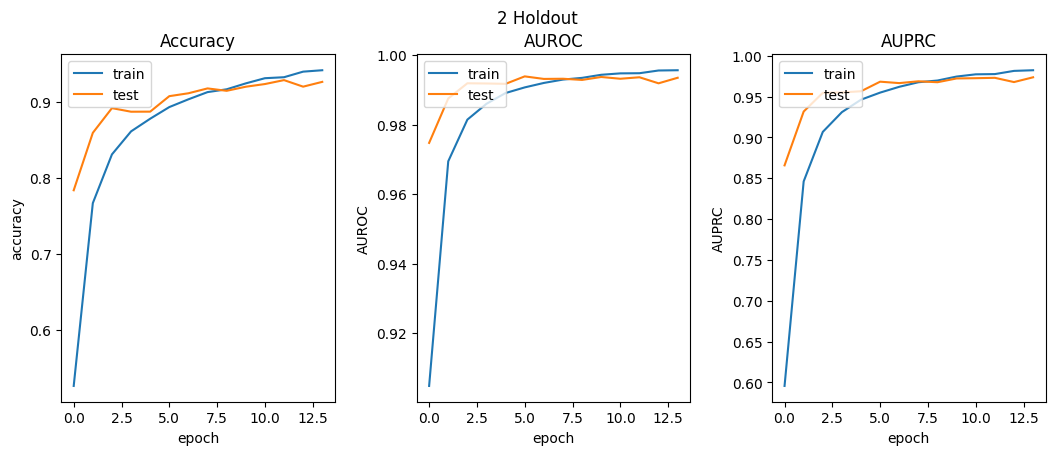

----------------------------------------------------------------------------------------------------


In [24]:
CNN_metrics_estimate = model_metrics_holdout_estimate(CNN_metrics, number_of_splits)

print(f"CNN Soccer Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : train - {CNN_metrics_estimate['accuracy_train']}  --  test - {CNN_metrics_estimate['accuracy_test']}")
print(f"AUROC : train - {CNN_metrics_estimate['AUROC_train']}  --  test - {CNN_metrics_estimate['AUROC_test']}")
print(f"AUPRC : train - {CNN_metrics_estimate['AUPRC_train']}  --  test - {CNN_metrics_estimate['AUPRC_test']}")
print("-"*80)
print("CNN Soccer - Train history:")
plot_train_history(CNN_history)
print("-"*100)

In [64]:
# Soccer CNN Metrics
CNN_metrics

[{'train_evaluation': {'loss': 0.10073351860046387,
   'accuracy': 0.9684252142906189,
   'recall': 0.9568045735359192,
   'precision': 0.9774398803710938,
   'AUROC': 0.9991887807846069,
   'AUPRC': 0.9954752922058105},
  'test_evaluation': {'loss': 0.23127177357673645,
   'accuracy': 0.9266666769981384,
   'recall': 0.9127777814865112,
   'precision': 0.9419971108436584,
   'AUROC': 0.9946945905685425,
   'AUPRC': 0.9758864641189575}},
 {'train_evaluation': {'loss': 0.08517780154943466,
   'accuracy': 0.9731243848800659,
   'recall': 0.9664807319641113,
   'precision': 0.9788526296615601,
   'AUROC': 0.9991899132728577,
   'AUPRC': 0.9960018396377563},
  'test_evaluation': {'loss': 0.23984651267528534,
   'accuracy': 0.926111102104187,
   'recall': 0.9146296381950378,
   'precision': 0.9379925727844238,
   'AUROC': 0.9935131072998047,
   'AUPRC': 0.9736381769180298}}]

In [83]:
# Save results (save dictionary to basic_CNN_metrics.pkl file)
with open('results/basic_CNN_metrics.pkl', 'wb') as fp:
    pickle.dump(CNN_metrics, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [28]:
# Save Soccer CNN
soccer_CNN = CNN_models[0]
soccer_CNN.save_weights('modelWeights/soccerCNN_Model.h5')

#### Confusion Matrix - Soccer CNN

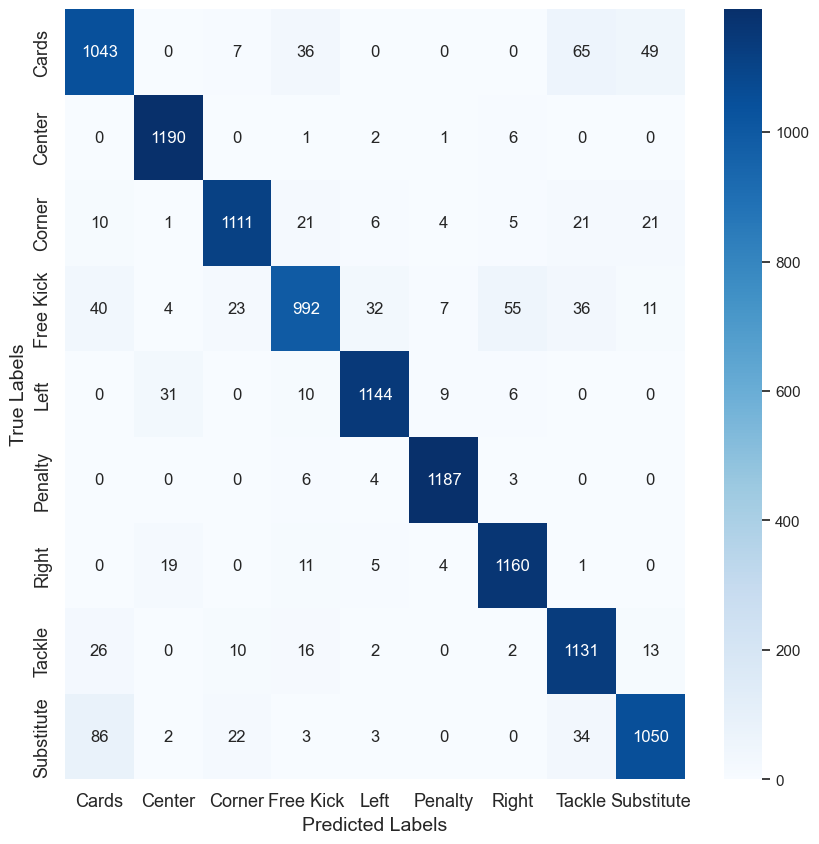

In [30]:
model_and_holdout_to_plot = 0

true_labels = tf.math.argmax(CNN_holdout_test_labels[model_and_holdout_to_plot], axis=1)
predicted_labels = tf.math.argmax(CNN_holdout_predictions[model_and_holdout_to_plot], axis=1)

confusion_matrix = tf.math.confusion_matrix(
    true_labels,
    predicted_labels,
    num_classes=9,
    weights=None,
    name=None
)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
sns.set(rc = {'figure.figsize':(10,10)})
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.yticks(np.arange(9)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute'), fontsize="13")
plt.xticks(np.arange(9)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute'), fontsize="13" )
plt.show()

### Main training loop - Soccer CNN with Data Augmentation
* Generate augmented images equal to 20% of the original test split size for training.
* Normalize images' values in 0-1 range.
* Build and train the model over the training set and test it over the test set for the different holdouts.

In [23]:
epochs = 100
batch_size = 10

In [24]:
augmentation_rate = 0.2

In [25]:
print("---- Soccer CNN with Data Augmentation ----")

CNN_metrics = []
CNN_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(data_soccer_all, labels_soccer))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data
    x_train, x_test = np.array([data_soccer_all[x] for x in train_indices]), np.array([data_soccer_all[x] for x in test_indices])
    y_train, y_test = labels_soccer.iloc[train_indices], labels_soccer.iloc[test_indices]

    ## Data Augmentation
    # Select specified % of elements
    n_data_to_augment = int(augmentation_rate * len(x_train))
    selected_indices = np.random.choice(len(x_train), n_data_to_augment, replace=False)
    selected_elements = x_train[selected_indices]
    selected_labels = y_train.values[selected_indices]

    # Apply data augmentation to the selected elements
    augmented_elements = np.array([augment_image(x) for x in selected_elements])

    # Insert the modified elements in the training data
    x_train = np.insert(x_train, selected_indices, augmented_elements, axis=0)
    y_train = pd.DataFrame(np.insert(y_train, selected_indices, selected_labels, axis=0))

    # Normalization
    x_train, x_test = np.array([x/255 for x in x_train]), np.array([x/255 for x in x_test])

    # Build CNN
    CNN = build_soccer_CNN(x_train[0].shape)

    print("- Training model:\n")
    CNN_holdout_metrics, CNN_holdout_history = train_model(
        CNN,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size
    )

    predictions = get_predictions(CNN, x_test, batch_size=batch_size)
    CNN_holdout_predictions.append(predictions)
    CNN_holdout_test_labels.append(y_test)

    CNN_metrics.append(CNN_holdout_metrics)
    CNN_history.append(CNN_holdout_history)

    CNN_models.append(CNN)

---- Soccer CNN with Data Augmentation ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Model: "Soccer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10

1it [08:12, 492.79s/it]

-- HOLDOUT 2
Model: "Soccer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10

2it [17:42, 531.15s/it]


CNN Soccer Data Augmentation - Metrics - 2-holdouts estimate:
Accuracy : train - 0.9136347770690918  --  test - 0.9051388800144196
AUROC : train - 0.9957026243209839  --  test - 0.9924991726875305
AUPRC : train - 0.9745860695838928  --  test - 0.9633217751979828
--------------------------------------------------------------------------------
CNN Soccer Data Augmentation - Train history:


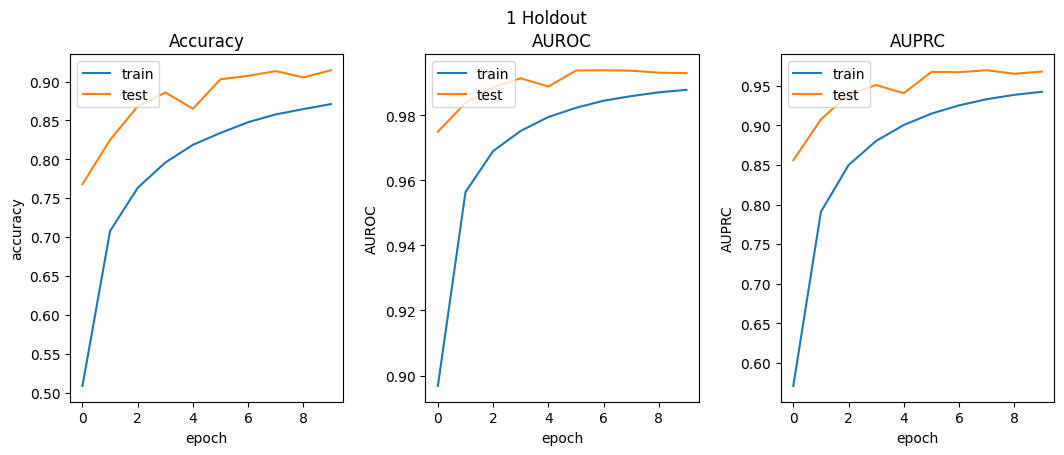

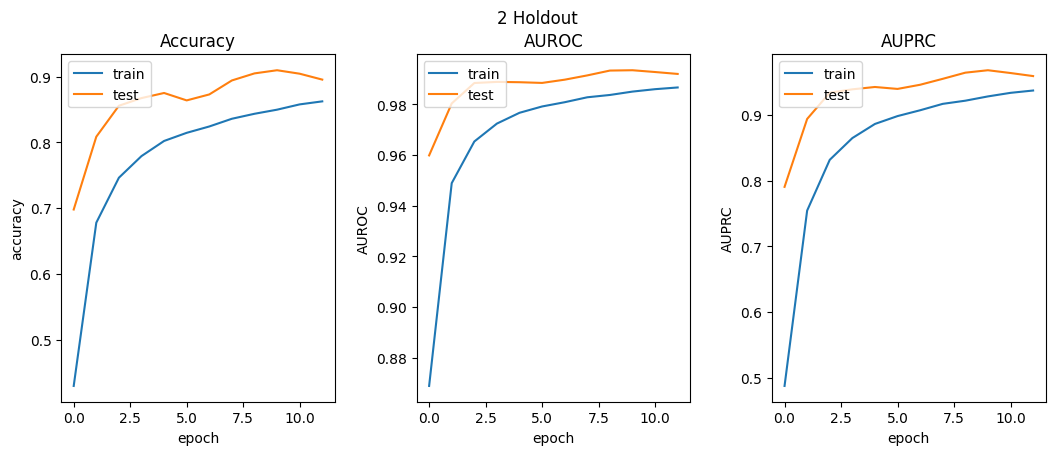

----------------------------------------------------------------------------------------------------


In [26]:
CNN_metrics_estimate = model_metrics_holdout_estimate(CNN_metrics, number_of_splits)
print(f"CNN Soccer Data Augmentation - Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : train - {CNN_metrics_estimate['accuracy_train']}  --  test - {CNN_metrics_estimate['accuracy_test']}")
print(f"AUROC : train - {CNN_metrics_estimate['AUROC_train']}  --  test - {CNN_metrics_estimate['AUROC_test']}")
print(f"AUPRC : train - {CNN_metrics_estimate['AUPRC_train']}  --  test - {CNN_metrics_estimate['AUPRC_test']}")
print("-"*80)
print("CNN Soccer Data Augmentation - Train history:")
plot_train_history(CNN_history)
print("-"*100)

In [27]:
# Soccer CNN Data augmentation Metrics
CNN_metrics

[{'train_evaluation': {'loss': 0.23024460673332214,
   'accuracy': 0.9232030510902405,
   'recall': 0.8886530995368958,
   'precision': 0.9546961784362793,
   'AUROC': 0.9964159727096558,
   'AUPRC': 0.9791415929794312},
  'test_evaluation': {'loss': 0.272890567779541,
   'accuracy': 0.9145370125770569,
   'recall': 0.896574079990387,
   'precision': 0.9341115355491638,
   'AUROC': 0.9929803609848022,
   'AUPRC': 0.9679373502731323}},
 {'train_evaluation': {'loss': 0.2823828458786011,
   'accuracy': 0.9040665030479431,
   'recall': 0.85965895652771,
   'precision': 0.9441913962364197,
   'AUROC': 0.994989275932312,
   'AUPRC': 0.9700305461883545},
  'test_evaluation': {'loss': 0.31406882405281067,
   'accuracy': 0.8957407474517822,
   'recall': 0.8651852011680603,
   'precision': 0.9244163036346436,
   'AUROC': 0.9920179843902588,
   'AUPRC': 0.9587062001228333}}]

In [85]:
# Save results (save dictionary to data_augmentation_basic_CNN_metrics.pkl file)
with open('results/data_augmentation_basic_CNN_metrics.pkl', 'wb') as fp:
    pickle.dump(CNN_metrics, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [28]:
# Save Soccer CNN with Data Augmentation
soccer_data_augmentation_CNN = CNN_models[0]
soccer_data_augmentation_CNN.save_weights('modelWeights/soccerModelDataAugmentation.h5')

## Transfer Learning
Import **ResNet50** and **VGG16** architectures pretrained (imagenet weights) and add an average pooling layer as well as a dense layer with dropout.  
* ResNet50's final 3 layers are trained as well as the added ones.  
* VGG16 is instead kept fully frozen and only the added layers are trained.

The models require three channel images, thus they are tested on *gray scale* images reshaped to have three channels as well as *RGB* images.

In [23]:
# 3 channels gray input
threeChannels_input = [cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in data_soccer_all]
image_shape = threeChannels_input[0].shape
image_shape

(80, 80, 3)

In [24]:
# RGB input

#data_soccer is a dict containing ['events'...] so put together classes to evaluate
data_soccer_rgb_all = []
for event in data_soccer_rgb:
    for element in data_soccer_rgb[event]:
        data_soccer_rgb_all.append(element)
print(f"RGB Data shape: {np.array(data_soccer_rgb_all).shape}")

rgb_input = data_soccer_rgb_all
image_shape = rgb_input[0].shape
image_shape

RGB Data shape: (53999, 80, 80, 3)


(80, 80, 3)

In [25]:
# Create the base model from the pre-trained model MobileNet V2
resNet_model = tf.keras.applications.resnet.ResNet50(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

In [26]:
# Create the base model from the pre-trained model VGG16
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

In [27]:
# Freeze pretrained layers
resNet_model.trainable = False
vgg16_model.trainable = False

In [28]:
resNet_model.trainable = True

print("Number of layers in the base model: ", len(resNet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 172

# Freeze all the layers before the `fine_tune_at` layer
for layer in resNet_model.layers[:fine_tune_at]:
  layer.trainable = False

print(f"Fine tuning from layer: {fine_tune_at}")

Number of layers in the base model:  175
Fine tuning from layer: 172


In [29]:
# Additional downstream layers on top of main model
avg_pooling = layers.GlobalAveragePooling2D()

dense1 = layers.Dense(units = 256, activation='relu')
dropout1 = layers.Dropout(0.5)

prediction_layer = layers.Dense(9, activation='softmax')

In [30]:
# Build final model ResNet
inputs = tf.keras.Input(shape=(soccer_images_dim, soccer_images_dim, 3))
x = resNet_model(inputs)
x = avg_pooling(x)
x = dense1(x)
x = dropout1(x)
outputs = prediction_layer(x)
resNet_soccer_model = tf.keras.Model(inputs, outputs)
resNet_soccer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                             

In [31]:
resNet_soccer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=get_minimal_multiclass_metrics()
)

### Main training loop - ResNet CNN (Gray and RGB images)
* Normalize images' values in 0-1 range.
* Train the unfrozen layers and additional ones of the ResNet model over the training set and test it over the test set for the different holdouts.  
* For memory and speed requirements these models are run over a single holdout and trained using checkpoints.

In [33]:
number_of_splits = 1

holdouts_generator = StratifiedShuffleSplit(
    n_splits = number_of_splits,
    test_size = 0.2,
    random_state = 42
)

In [34]:
epochs = 100
batch_size = 24

In [37]:
checkpoint_path = "training_ResNet_gray/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
interrupt = False
enable_checkpoints = True

In [38]:
# Flag to load weights if training got interrupted
interrupt = True

In [39]:
print("---- ResNet Soccer CNN Gray ----")

CNN_metrics = []
CNN_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(threeChannels_input, labels_soccer))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data + Normalization
    x_train, x_test = np.array([threeChannels_input[x]/255 for x in train_indices]), np.array([threeChannels_input[x]/255 for x in test_indices])
    y_train, y_test = labels_soccer.iloc[train_indices], labels_soccer.iloc[test_indices]

    # Get model
    model = resNet_soccer_model
    
    # Load weights if training got interrupted
    if interrupt:
        model.load_weights(checkpoint_path)

    CNN_holdout_metrics, CNN_holdout_history = train_model_cp(
        model,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size,
        cp_callback
    )

    CNN_metrics.append(CNN_holdout_metrics)
    CNN_history.append(CNN_holdout_history)
    
    CNN_models.append(model)

---- ResNet Soccer CNN ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Epoch 1/100
5400/5400 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7354 - recall: 0.6543 - precision: 0.8096 - AUROC: 0.9677 - AUPRC: 0.8299
Epoch 1: val_loss improved from inf to 0.64415, saving model to training_ResNet_gray\cp.ckpt
5400/5400 [==============================] - 85s 14ms/step - loss: 0.7055 - accuracy: 0.7354 - recall: 0.6543 - precision: 0.8096 - AUROC: 0.9677 - AUPRC: 0.8299 - val_loss: 0.6442 - val_accuracy: 0.7766 - val_recall: 0.7235 - val_precision: 0.8237 - val_AUROC: 0.9721 - val_AUPRC: 0.8570
Epoch 2/100
5396/5400 [============================>.] - ETA: 0s - loss: 0.7060 - accuracy: 0.7368 - recall: 0.6550 - precision: 0.8119 - AUROC: 0.9676 - AUPRC: 0.8302
Epoch 2: val_loss improved from 0.64415 to 0.63572, saving model to training_ResNet_gray\cp.ckpt
5400/5400 [==============================] - 71s 13ms/step - loss: 0.7061 - accuracy: 0.7367 - recall: 0.6550 - precision: 0.8119 - AUROC: 0.9676 - AUPRC: 0.8302 - val_loss

1it [09:04, 544.35s/it]


In [40]:
print(f"ResNet Soccer CNN Gray Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : test - {CNN_metrics[0]['test_evaluation']['accuracy']}")
print(f"AUROC : test - {CNN_metrics[0]['test_evaluation']['AUROC']}")
print(f"AUPRC : test - {CNN_metrics[0]['test_evaluation']['AUPRC']}")
print("-"*80)

CNN Metrics - 1-holdouts estimate:
Accuracy : test - 0.7855555415153503
AUROC : test - 0.9735950231552124
AUPRC : test - 0.8632519245147705
--------------------------------------------------------------------------------


In [42]:
# CNN ResNet - Gray images - Metrics
CNN_metrics

[{'test_evaluation': {'loss': 0.6256866455078125,
   'accuracy': 0.7855555415153503,
   'recall': 0.734074056148529,
   'precision': 0.8292887210845947,
   'AUROC': 0.9735950231552124,
   'AUPRC': 0.8632519245147705}}]

In [71]:
# Save results (save dictionary to resNet_gray_metrics.pkl file)
with open('results/resNet_gray_metrics.pkl', 'wb') as fp:
    pickle.dump(CNN_metrics, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [44]:
# Save Gray ResNet Soccer CNN
resNet_soccer_gray = CNN_models[0]
resNet_soccer_gray.save_weights('modelWeights/resNet_soccer_gray_model.h5')

In [35]:
checkpoint_path = "training_ResNet_rgb/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
interrupt = False

In [36]:
# Flag to load weights if training got interrupted
interrupt = True

In [37]:
print("---- ResNet Soccer CNN RGB ----")

CNN_metrics = []
CNN_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(rgb_input, labels_soccer))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data + Normalization
    x_train, x_test = np.array([rgb_input[x]/255 for x in train_indices]), np.array([rgb_input[x]/255 for x in test_indices])
    y_train, y_test = labels_soccer.iloc[train_indices], labels_soccer.iloc[test_indices]

    # Get model
    model = resNet_soccer_model
    
    # Load weights if training got interrupted
    if interrupt:
        model.load_weights(checkpoint_path)

    CNN_holdout_metrics, CNN_holdout_history = train_model_cp(
        model,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size,
        cp_callback
    )
    
    CNN_metrics.append(CNN_holdout_metrics)
    CNN_history.append(CNN_holdout_history)
    
    CNN_models.append(model)

---- ResNet Soccer CNN ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Epoch 1/100
1800/1800 [==============================] - ETA: 0s - loss: 0.8205 - accuracy: 0.6941 - recall: 0.5868 - precision: 0.7885 - AUROC: 0.9570 - AUPRC: 0.7813
Epoch 1: val_loss improved from inf to 0.69696, saving model to training_ResNet_rgb\cp.ckpt
1800/1800 [==============================] - 44s 19ms/step - loss: 0.8205 - accuracy: 0.6941 - recall: 0.5868 - precision: 0.7885 - AUROC: 0.9570 - AUPRC: 0.7813 - val_loss: 0.6970 - val_accuracy: 0.7419 - val_recall: 0.6651 - val_precision: 0.8115 - val_AUROC: 0.9685 - val_AUPRC: 0.8311
Epoch 2/100
1799/1800 [============================>.] - ETA: 0s - loss: 0.8157 - accuracy: 0.6990 - recall: 0.5889 - precision: 0.7887 - AUROC: 0.9575 - AUPRC: 0.7829
Epoch 2: val_loss improved from 0.69696 to 0.67831, saving model to training_ResNet_rgb\cp.ckpt
1800/1800 [==============================] - 30s 17ms/step - loss: 0.8156 - accuracy: 0.6991 - recall: 0.5890 - precision: 0.7888 - AUROC: 0.9575 - AUPRC: 0.7830 - val_loss: 

1it [03:22, 202.54s/it]


In [38]:
print(f"ResNet Soccer CNN RGB Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : test - {CNN_metrics[0]['test_evaluation']['accuracy']}")
print(f"AUROC : test - {CNN_metrics[0]['test_evaluation']['AUROC']}")
print(f"AUPRC : test - {CNN_metrics[0]['test_evaluation']['AUPRC']}")
print("-"*80)

CNN Metrics - 1-holdouts estimate:
Accuracy : test - 0.7574999928474426
AUROC : test - 0.9711117744445801
AUPRC : test - 0.8445291519165039
--------------------------------------------------------------------------------


In [39]:
# CNN ResNet - RGB images - Metrics
CNN_metrics

[{'test_evaluation': {'loss': 0.663693368434906,
   'accuracy': 0.7574999928474426,
   'recall': 0.6895370483398438,
   'precision': 0.8184415698051453,
   'AUROC': 0.9711117744445801,
   'AUPRC': 0.8445291519165039}}]

In [73]:
# Save results (save dictionary to resNet_rgb_metrics.pkl file)
with open('results/resNet_rgb_metrics.pkl', 'wb') as fp:
    pickle.dump(CNN_metrics, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [40]:
# Save RGB ResNet Soccer CNN
resNet_soccer_rgb = CNN_models[0]
resNet_soccer_rgb.save_weights('modelWeights/resNet_soccer_rgb_model.h5')

### Main training loop - VGG16 CNN (Gray and RGB images)
* Normalize images' values in 0-1 range.
* Train the additional layers of the VGG16 model over the training set and test it over the test set for the different holdouts.

In [32]:
vgg16_model.trainable = True

print("Number of layers in the base model: ", len(vgg16_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 19

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [33]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0     

In [34]:
# Additional downstream layers on top of main model
avg_pooling = layers.GlobalAveragePooling2D()
flattening = layers.Flatten()

dense1 = layers.Dense(units = 256, activation='relu')
dropout1 = layers.Dropout(0.5)
dense2 = layers.Dense(units = 128, activation='relu')
dropout2 = layers.Dropout(0.5)

prediction_layer = layers.Dense(9, activation='softmax')

In [35]:
# Build final model VGG16
inputs = tf.keras.Input(shape=(soccer_images_dim, soccer_images_dim, 3))
x = vgg16_model(inputs, training=False)
x = avg_pooling(x)
x = dense1(x)
x = dropout1(x)
outputs = prediction_layer(x)
vgg16_soccer_model = tf.keras.Model(inputs, outputs)
vgg16_soccer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 9)                 2313      
                                                           

In [36]:
vgg16_soccer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=get_minimal_multiclass_metrics()
)

### Main training loop - VGG16 CNN (Gray and RGB images)
* Normalize images' values in 0-1 range.
* Train the unfrozen layers and additional ones of the VGG16 model over the training set and test it over the test set for the different holdouts.

In [41]:
checkpoint_path = "training_vgg_gray/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
interrupt = False

In [ ]:
# Flag to load weights if training got interrupted
interrupt = True

In [42]:
print("---- VGG16 Soccer CNN Gray ----")

CNN_metrics = []
CNN_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(threeChannels_input, labels_soccer))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data + Normalization
    x_train, x_test = np.array([threeChannels_input[x]/255 for x in train_indices]), np.array([threeChannels_input[x]/255 for x in test_indices])
    y_train, y_test = labels_soccer.iloc[train_indices], labels_soccer.iloc[test_indices]

    # Get model
    model = vgg16_soccer_model
    
    # Load weights if training got interrupted
    if interrupt:
        model.load_weights(checkpoint_path)

    CNN_holdout_metrics, CNN_holdout_history = train_model_cp(
        model,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size,
        cp_callback
    )

    CNN_metrics.append(CNN_holdout_metrics)
    CNN_history.append(CNN_holdout_history)
    
    CNN_models.append(model)

---- VGG16 Soccer CNN ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Epoch 1/100
1800/1800 [==============================] - ETA: 0s - loss: 0.9374 - accuracy: 0.6603 - recall: 0.5088 - precision: 0.7808 - AUROC: 0.9453 - AUPRC: 0.7365
Epoch 1: val_loss improved from inf to 0.67921, saving model to training_vgg_gray\cp.ckpt
1800/1800 [==============================] - 41s 18ms/step - loss: 0.9374 - accuracy: 0.6603 - recall: 0.5088 - precision: 0.7808 - AUROC: 0.9453 - AUPRC: 0.7365 - val_loss: 0.6792 - val_accuracy: 0.7593 - val_recall: 0.6690 - val_precision: 0.8331 - val_AUROC: 0.9710 - val_AUPRC: 0.8434
Epoch 2/100
1798/1800 [============================>.] - ETA: 0s - loss: 0.7039 - accuracy: 0.7480 - recall: 0.6654 - precision: 0.8144 - AUROC: 0.9681 - AUPRC: 0.8307
Epoch 2: val_loss improved from 0.67921 to 0.62108, saving model to training_vgg_gray\cp.ckpt
1800/1800 [==============================] - 29s 16ms/step - loss: 0.7041 - accuracy: 0.7479 - recall: 0.6653 - precision: 0.8143 - AUROC: 0.9681 - AUPRC: 0.8306 - val_loss: 0.62

Epoch 16/100
1800/1800 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8464 - recall: 0.8161 - precision: 0.8754 - AUROC: 0.9877 - AUPRC: 0.9289
Epoch 16: val_loss did not improve from 0.41646
1800/1800 [==============================] - 28s 15ms/step - loss: 0.4174 - accuracy: 0.8464 - recall: 0.8161 - precision: 0.8754 - AUROC: 0.9877 - AUPRC: 0.9289 - val_loss: 0.4189 - val_accuracy: 0.8547 - val_recall: 0.8271 - val_precision: 0.8768 - val_AUROC: 0.9870 - val_AUPRC: 0.9290
Epoch 17/100
1800/1800 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8499 - recall: 0.8216 - precision: 0.8779 - AUROC: 0.9880 - AUPRC: 0.9309
Epoch 17: val_loss improved from 0.41646 to 0.40520, saving model to training_vgg_gray\cp.ckpt
1800/1800 [==============================] - 28s 16ms/step - loss: 0.4108 - accuracy: 0.8499 - recall: 0.8216 - precision: 0.8779 - AUROC: 0.9880 - AUPRC: 0.9309 - val_loss: 0.4052 - val_accuracy: 0.8600 - val_recall: 0.8352 - val

338/338 [==============================] - 6s 14ms/step - loss: 0.3809 - accuracy: 0.8704 - recall: 0.8531 - precision: 0.8877 - AUROC: 0.9882 - AUPRC: 0.9409


1it [15:33, 933.03s/it]


In [44]:
print(f"VGG16 Soccer CNN Gray Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : test - {CNN_metrics[0]['test_evaluation']['accuracy']}")
print(f"AUROC : test - {CNN_metrics[0]['test_evaluation']['AUROC']}")
print(f"AUPRC : test - {CNN_metrics[0]['test_evaluation']['AUPRC']}")
print("-"*80)

CNN Metrics - 1-holdouts estimate:
Accuracy : test - 0.8703703880310059
AUROC : test - 0.9881564378738403
AUPRC : test - 0.940942108631134
--------------------------------------------------------------------------------


In [45]:
# CNN VGG16 - Gray images - Metrics
CNN_metrics

[{'test_evaluation': {'loss': 0.3809435963630676,
   'accuracy': 0.8703703880310059,
   'recall': 0.8530555367469788,
   'precision': 0.8876577615737915,
   'AUROC': 0.9881564378738403,
   'AUPRC': 0.940942108631134}}]

In [75]:
# Save results (save dictionary to vgg_gray_metrics.pkl file)
with open('results/vgg_gray_metrics.pkl', 'wb') as fp:
    pickle.dump(CNN_metrics, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [46]:
# Save Gray VGG16 Soccer CNN
vgg16_soccer_gray = CNN_models[0]
vgg16_soccer_gray.save_weights('modelWeights/vgg16_soccer_gray_model.h5')

In [39]:
checkpoint_path = "training_vgg_rgb/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
interrupt = False

In [ ]:
# Flag to load weights if training got interrupted
interrupt = True

In [40]:
print("---- VGG16 Soccer CNN RGB ----")

CNN_metrics = []
CNN_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(rgb_input, labels_soccer))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data + Normalization
    x_train, x_test = np.array([rgb_input[x]/255 for x in train_indices]), np.array([rgb_input[x]/255 for x in test_indices])
    y_train, y_test = labels_soccer.iloc[train_indices], labels_soccer.iloc[test_indices]

    # Get model
    model = vgg16_soccer_model
    
    # Load weights if training got interrupted
    if interrupt:
        model.load_weights(checkpoint_path)

    CNN_holdout_metrics, CNN_holdout_history = train_model_cp(
        model,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size,
        cp_callback
    )

    CNN_metrics.append(CNN_holdout_metrics)
    CNN_history.append(CNN_holdout_history)
    
    CNN_models.append(model)

---- VGG16 Soccer CNN ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Epoch 1/100
1800/1800 [==============================] - ETA: 0s - loss: 0.8185 - accuracy: 0.7068 - recall: 0.5898 - precision: 0.8062 - AUROC: 0.9581 - AUPRC: 0.7899
Epoch 1: val_loss improved from inf to 0.56561, saving model to training_vgg_rgb\cp.ckpt
1800/1800 [==============================] - 39s 18ms/step - loss: 0.8185 - accuracy: 0.7068 - recall: 0.5898 - precision: 0.8062 - AUROC: 0.9581 - AUPRC: 0.7899 - val_loss: 0.5656 - val_accuracy: 0.8043 - val_recall: 0.7478 - val_precision: 0.8513 - val_AUROC: 0.9789 - val_AUPRC: 0.8845
Epoch 2/100
1797/1800 [============================>.] - ETA: 0s - loss: 0.5878 - accuracy: 0.7893 - recall: 0.7309 - precision: 0.8428 - AUROC: 0.9772 - AUPRC: 0.8750
Epoch 2: val_loss improved from 0.56561 to 0.49451, saving model to training_vgg_rgb\cp.ckpt
1800/1800 [==============================] - 29s 16ms/step - loss: 0.5876 - accuracy: 0.7894 - recall: 0.7310 - precision: 0.8429 - AUROC: 0.9772 - AUPRC: 0.8750 - val_loss: 0.4945

1it [12:32, 752.18s/it]


In [42]:
print(f"VGG16 Soccer CNN RGB Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : test - {CNN_metrics[0]['test_evaluation']['accuracy']}")
print(f"AUROC : test - {CNN_metrics[0]['test_evaluation']['AUROC']}")
print(f"AUPRC : test - {CNN_metrics[0]['test_evaluation']['AUPRC']}")
print("-"*80)

CNN Metrics - 1-holdouts estimate:
Accuracy : test - 0.9011111259460449
AUROC : test - 0.990019679069519
AUPRC : test - 0.9564046263694763
--------------------------------------------------------------------------------


In [43]:
# CNN VGG16 - RGB Images - Metrics
CNN_metrics

[{'test_evaluation': {'loss': 0.3251974582672119,
   'accuracy': 0.9011111259460449,
   'recall': 0.8919444680213928,
   'precision': 0.9120431542396545,
   'AUROC': 0.990019679069519,
   'AUPRC': 0.9564046263694763}}]

In [77]:
# Save results (save dictionary to vgg_rgb_metrics.pkl file)
with open('results/vgg_rgb_metrics.pkl', 'wb') as fp:
    pickle.dump(CNN_metrics, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [44]:
# Save RGB VGG16 Soccer CNN
vgg16_soccer_rgb = CNN_models[0]
vgg16_soccer_rgb.save_weights('modelWeights/vgg16_soccer_rgb_model.h5')

### Evaluation of models on the "Real Soccer" dataset
Evaluation on images not from the football analysis dataset to evaluate the generalization capabilities of the models on different kinds of soccer images.

In [37]:
image_shape_gray = (soccer_images_dim,soccer_images_dim,1)

In [53]:
## Load Models
oneDim_models = []
threeDim_models = []

# Create models
soccer = build_soccer_CNN(image_shape_gray)
soccer_data_augmentation = build_soccer_CNN(image_shape_gray)
soccer_resNet_model = resNet_soccer_model
soccer_vgg_model = vgg16_soccer_model

# Restore the weights
soccer.load_weights('modelWeights/soccerCNN_Model.h5')
soccer._name = "Basic_CNN"

soccer_data_augmentation.load_weights('modelWeights/soccerModelDataAugmentation.h5')
soccer_data_augmentation._name = "CNN_Data_Augmentation"

soccer_resNet_model.load_weights('modelWeights/resNet_soccer_gray_model.h5')
soccer_resNet_model._name = "ResNet_Soccer_Gray"

soccer_vgg_model.load_weights('modelWeights/vgg16_soccer_gray_model.h5')
soccer_vgg_model._name = "VGG16_Soccer_Gray"

oneDim_models.append(soccer)
oneDim_models.append(soccer_data_augmentation)
threeDim_models.append(soccer_resNet_model)
threeDim_models.append(soccer_vgg_model)

Model: "Soccer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 10, 10, 256)      0

In [46]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

def get_metrics(labels, predictions):
    """ Returns the AUROC and AUPRC metrics given the true labels and the model predictions.
    
    Parameters
    ------------------------
    labels: tuple
        The true labels (n_samples,).
    predictions: np.array
        The model predictions (n_samples,).
        
    Returns
    ------------------------
    accuracy: float
        The accuracy metric.
    auroc: float
        The AUROC metric.
    auprc: float
        The AUPRC metric."""
    
    # Change shape from (n_samples,) to (n_samples, n_classes)
    labels = label_binarize(labels, classes=np.unique(labels))
    predictions = label_binarize(predictions, classes=np.unique(predictions)) 
    
    # Accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # AUROC
    auroc = roc_auc_score(labels, predictions)
        
    # AUPRC
    auprc = average_precision_score(labels, predictions)

    return accuracy, auroc, auprc

In [47]:
def one_hot_max(arr):
    """ Returns the index of maximum value in the array (prediction). """ 
    max_index = np.argmax(arr)
    
    one_hot_arr = np.zeros_like(arr)
    one_hot_arr[max_index] = 1
    
    return one_hot_arr

In [48]:
# Dataset preparation
real_data_soccer_all = []
for event in real_data_soccer:
    for element in real_data_soccer[event]:
        real_data_soccer_all.append(element)

print(f"Data shape: {np.array(real_data_soccer_all).shape}")
print(f"Labels shape: {real_labels_soccer.shape}")

# 3 Channel data for resNet and VGG16
threeChannels_real_input = np.array([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in real_data_soccer_all])
threeChannels_real_input = np.array([x/255 for x in threeChannels_real_input])

Data shape: (90, 80, 80)
Labels shape: (90, 9)


In [49]:
real_data_soccer_all = np.array([np.expand_dims(x/255, axis=-1) for x in real_data_soccer_all])

45/45 [==============================] - 0s 6ms/step
Basic_CNN metrics on real dataset:
Accuracy: 0.6888888888888889
------------------------------
AUROC: 0.825
------------------------------
AUPRC: 0.5385870302536969
--------------------------------------------------------------------------------


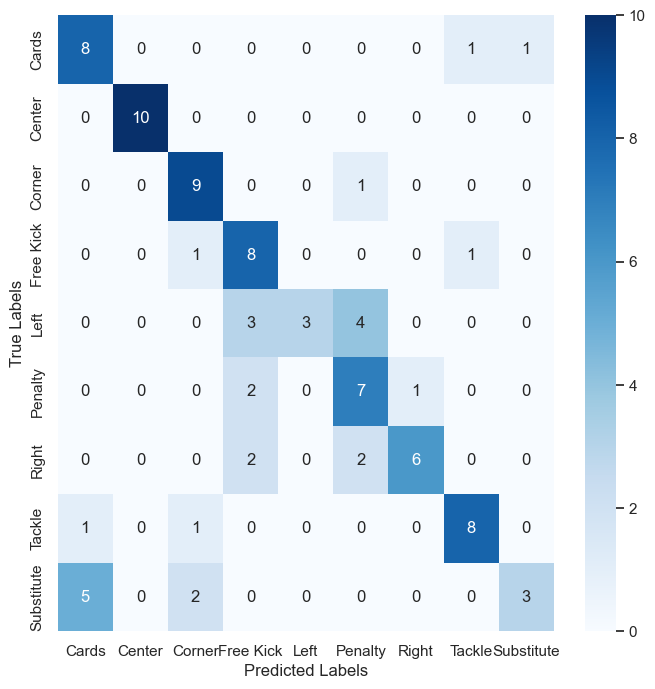

45/45 [==============================] - 0s 1ms/step
CNN_Data_Augmentation metrics on real dataset:
Accuracy: 0.7
------------------------------
AUROC: 0.83125
------------------------------
AUPRC: 0.572998366013072
--------------------------------------------------------------------------------


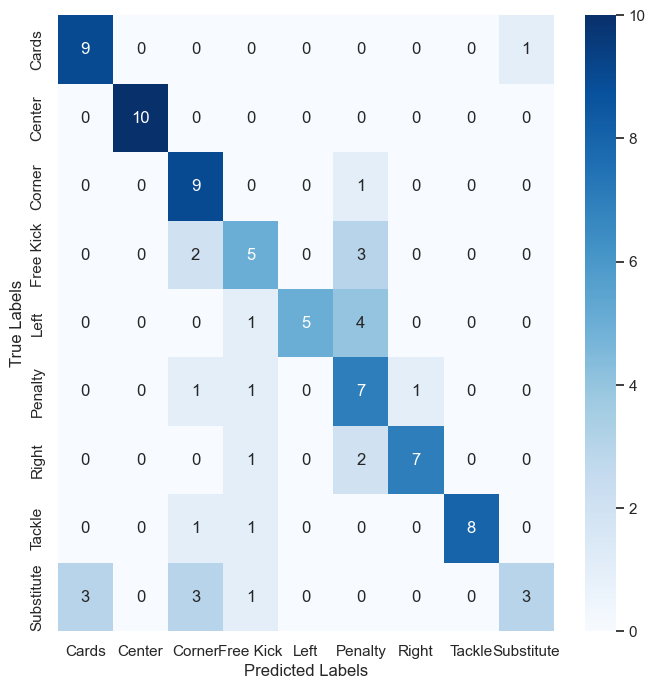

45/45 [==============================] - 0s 8ms/step
ResNet_Soccer_Gray metrics on real dataset:
Accuracy: 0.5444444444444444
------------------------------
AUROC: 0.74375
------------------------------
AUPRC: 0.39875423958757295
--------------------------------------------------------------------------------


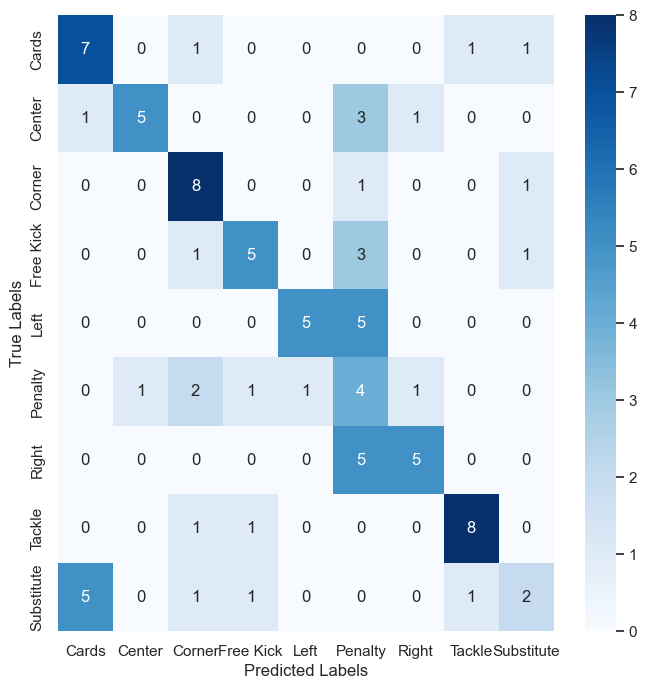

45/45 [==============================] - 0s 3ms/step
VGG16_Soccer_Gray metrics on real dataset:
Accuracy: 0.7
------------------------------
AUROC: 0.8312500000000002
------------------------------
AUPRC: 0.5530253696920363
--------------------------------------------------------------------------------


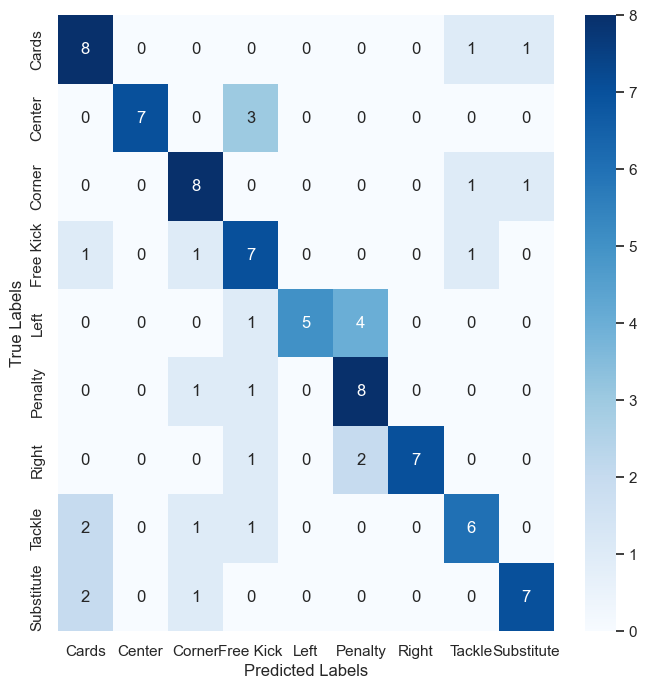

In [44]:
for model in oneDim_models:
    real_data_soccer_predictions = get_predictions(model, real_data_soccer_all, 2)
          
    # Shape (n_samples,)
    labels = np.argmax(real_labels_soccer, axis=1)
    predictions = np.argmax(real_data_soccer_predictions, axis=1)

    acc, auroc, auprc = get_metrics(
        labels = labels,
        predictions = predictions
    )
    print(f"{model.name} metrics on real dataset:")
    print(f"Accuracy: {acc}")
    print("-"*30)
    print(f"AUROC: {auroc}")
    print("-"*30)
    print(f"AUPRC: {auprc}")
    print("-"*80)
    
    true_labels = labels
    predicted_labels = predictions

    confusion_matrix = tf.math.confusion_matrix(
        true_labels,
        predicted_labels,
        num_classes=9,
        weights=None,
        name=None
    )

    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
    sns.set (rc = {'figure.figsize':(8,8)})
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.yticks(np.arange(9)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute'), fontsize="11")
    plt.xticks(np.arange(9)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute'), fontsize="11" )
    plt.show()
    
for model in threeDim_models:
    real_data_soccer_predictions = get_predictions(model, threeChannels_real_input, 2)
          
    # Shape (n_samples,)
    labels = labels
    predictions = np.argmax(real_data_soccer_predictions, axis=1)

    acc, auroc, auprc = get_metrics(
        labels = labels,
        predictions = predictions
    )
    print(f"{model.name} metrics on real dataset:")
    print(f"Accuracy: {acc}")
    print("-"*30)
    print(f"AUROC: {auroc}")
    print("-"*30)
    print(f"AUPRC: {auprc}")
    print("-"*80)
    
    true_labels = labels
    predicted_labels = predictions

    confusion_matrix = tf.math.confusion_matrix(
        true_labels,
        predicted_labels,
        num_classes=9,
        weights=None,
        name=None
    )

    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
    sns.set (rc = {'figure.figsize':(8,8)})
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.yticks(np.arange(9)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute'), fontsize="11")
    plt.xticks(np.arange(9)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute'), fontsize="11" )
    plt.show()

### Card classification (Red / Yellow)
Images previously classified as Cards are to be classified in Red vs Yellow.  
The cards classifier is a CNN taking in input **RGB images** to exploit the required color information to perform the task.

In [103]:
folderCards = r'D:\MachineLearning\Datasets\Soccer\TrainTestCards'

data_cards, labels_cards = loadData(folderCards, True)

[n.images, (width, height, depth)]
--- Red-Cards ---
shape: 6000 (80, 80, 3)
--- Yellow-Cards ---
shape: 6000 (80, 80, 3)
------------------------------
label Red-Cards


(<Axes: >, <matplotlib.image.AxesImage at 0x161fa5e7cd0>)

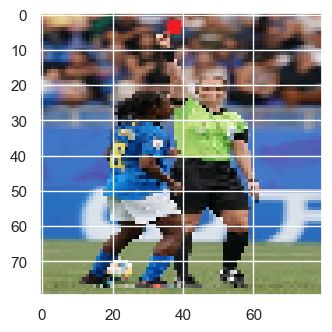

In [104]:
print("[n.images, (width, height, depth)]")
for folder in (data_cards):
    print(f"--- {folder} ---")
    print(f"shape: {len(data_cards[folder])} {data_cards[folder][1].shape}")

card_sample = data_cards['Red-Cards'][22]

print("-"*30)

print(f"label {labels_cards[22]}")

plt.subplot(1,2,1),plt.imshow(card_sample, cmap='gray', vmin=0, vmax=255)

In [105]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels_cards = pd.DataFrame(le.fit_transform(labels_cards))

print(labels_cards.sample(3))

      0
8539  1
9951  1
4806  0


In [106]:
# data_cards is a dict containing ['events'...] so group together classes to evaluate
data_cards_all = []
for event in data_cards:
    for element in data_cards[event]:
        data_cards_all.append(element)

print(f"Data shape: {np.array(data_cards_all).shape}")
print(f"Labels shape: {labels_cards.shape}")

Data shape: (12000, 80, 80, 3)
Labels shape: (12000, 1)


In [107]:
def build_cards_CNN(
    input_shape: tuple
) -> tf.keras.Model:
    """ Returns the Cards CNN model.

    Parameters
    ------------------------
    input_shape: tuple
        The shape of the input.

    Returns
    ------------------------
    model: model
        The Cards model."""

    CNN = Sequential(name="cards_CNN")
    CNN.add(layers.Input(input_shape))
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),

    CNN.add(layers.Flatten())
    
    for i in range(2):
        CNN.add(layers.Dense(units = 128, activation='relu'))
        CNN.add(layers.Dropout(0.5))
        
    CNN.add(layers.Dense(2, activation='sigmoid'))
    
    CNN.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=get_standard_binary_metrics()
    )
    
    CNN.summary()
    
    return CNN

### Main training loop - Cards CNN
* Normalize RGB images' values in 0-1 range.
* Build and train the model over the training set and test it over the test set for the different holdouts.

In [109]:
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits = number_of_splits,
    test_size = 0.2,
    random_state = 42
)

In [110]:
epochs = 100
batch_size = 32

In [111]:
print("---- CARDS CNN ----")

CNN_cards_metrics = []
CNN_cards_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(data_cards_all, labels_cards))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data + Normalization
    x_train, x_test = np.array([data_cards_all[x]/255 for x in train_indices]), np.array([data_cards_all[x]/255 for x in test_indices])
    y_train, y_test = labels_cards.iloc[train_indices], labels_cards.iloc[test_indices]
    
    # One hot encoding
    y_train = one_hot_encoding(y_train, 2)
    y_test = one_hot_encoding(y_test, 2)

    # Build CNN
    CNN = build_cards_CNN(x_train[0].shape)

    print("- Training model:\n")
    CNN_holdout_metrics, CNN_holdout_history = train_model(
        CNN,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size
    )
    
    predictions = get_predictions(CNN, x_test, batch_size=batch_size)
    CNN_holdout_predictions.append(predictions)
    CNN_holdout_test_labels.append(y_test)

    CNN_cards_metrics.append(CNN_holdout_metrics)
    CNN_cards_history.append(CNN_holdout_history)
    
    CNN_models.append(CNN)

---- CARDS CNN ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Model: "cards_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 80, 80, 128)       3584      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 10, 10,

1it [00:38, 38.92s/it]

-- HOLDOUT 2
Model: "cards_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 80, 80, 128)       3584      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 10, 10,

2it [01:16, 38.09s/it]


Red VS Yellow Card - CNN Metrics - 2-holdouts estimate:
Accuracy : train - 0.9855208396911621  --  test - 0.9558333456516266
AUROC : train - 0.9987120628356934  --  test - 0.990309476852417
AUPRC : train - 0.9986125230789185  --  test - 0.9890577793121338
--------------------------------------------------------------------------------
CNN - Train history:


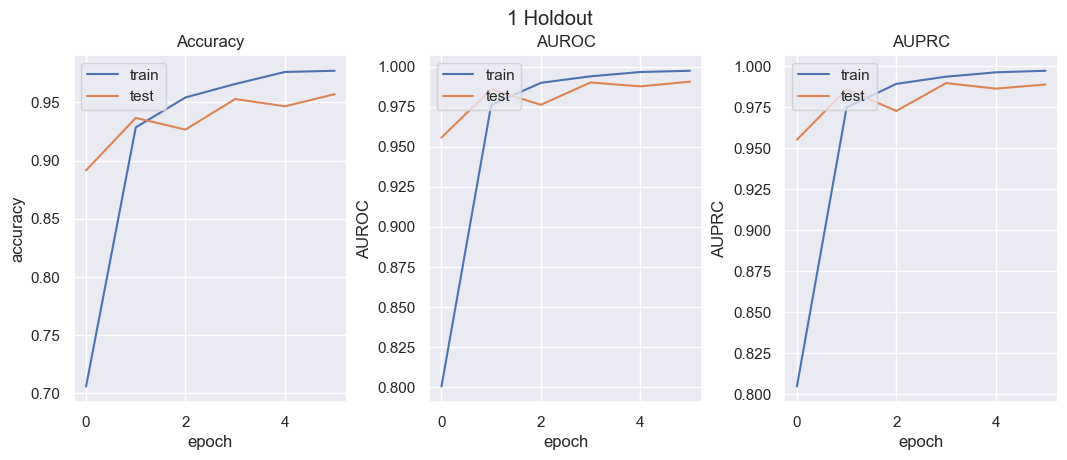

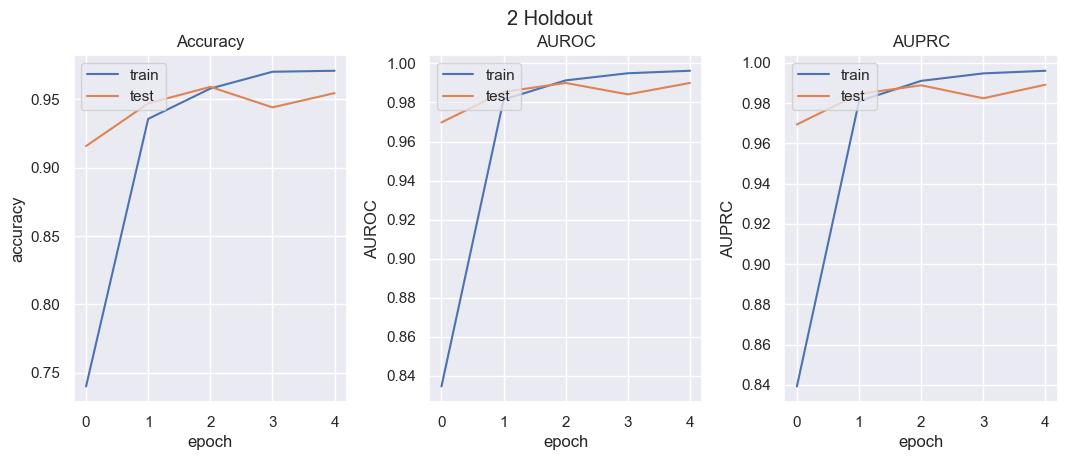

----------------------------------------------------------------------------------------------------


In [112]:
CNN_metrics_estimate = model_metrics_holdout_estimate(CNN_cards_metrics, number_of_splits)

print(f"Red VS Yellow Card - CNN Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : train - {CNN_metrics_estimate['accuracy_train']}  --  test - {CNN_metrics_estimate['accuracy_test']}")
print(f"AUROC : train - {CNN_metrics_estimate['AUROC_train']}  --  test - {CNN_metrics_estimate['AUROC_test']}")
print(f"AUPRC : train - {CNN_metrics_estimate['AUPRC_train']}  --  test - {CNN_metrics_estimate['AUPRC_test']}")
print("-"*80)
print("CNN - Train history:")
plot_train_history(CNN_cards_history)
print("-"*100)

In [113]:
# Save Cards CNN
cards_model = CNN_models[0]
cards_model.save_weights('modelWeights/cards_model.h5')

In [114]:
# Cards CNN Metrics
CNN_cards_metrics[0]

{'train_evaluation': {'loss': 0.03812405839562416,
  'accuracy': 0.9863541722297668,
  'recall': 0.9860416650772095,
  'precision': 0.9861443638801575,
  'AUROC': 0.9986873865127563,
  'AUPRC': 0.9985128045082092,
  'f1_score': 0.9860930442810059,
  'balanced_accuracy': 0.9860937595367432,
  'specificity': 0.9861458539962769,
  'miss_rate': 0.013958333060145378,
  'fall_out': 0.013854166492819786,
  'mcc': 0.9721875190734863},
 'test_evaluation': {'loss': 0.13638216257095337,
  'accuracy': 0.9570833444595337,
  'recall': 0.9579166769981384,
  'precision': 0.9571190476417542,
  'AUROC': 0.9905983209609985,
  'AUPRC': 0.9889681339263916,
  'f1_score': 0.957517683506012,
  'balanced_accuracy': 0.9574999809265137,
  'specificity': 0.9570833444595337,
  'miss_rate': 0.04208333417773247,
  'fall_out': 0.042916666716337204,
  'mcc': 0.915000319480896}}

#### Confusion Matrix of Cards CNN

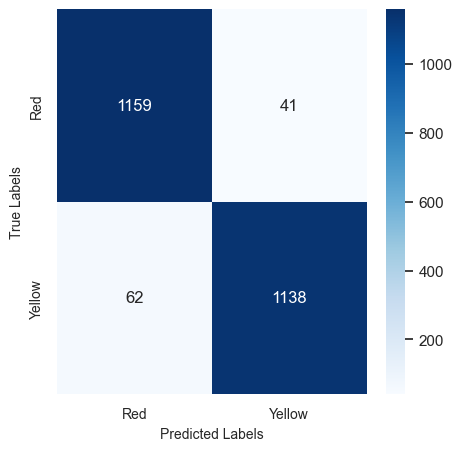

In [116]:
holdout_to_plot = 0

true_labels = tf.math.argmax(CNN_holdout_test_labels[holdout_to_plot], axis=1)
predicted_labels = tf.math.argmax(CNN_holdout_predictions[holdout_to_plot], axis=1)

confusion_matrix = tf.math.confusion_matrix(
    true_labels,
    predicted_labels,
    num_classes=2,
    weights=None,
    name=None
)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
sns.set(rc = {'figure.figsize':(5,5)})
plt.xlabel('Predicted Labels', fontsize=10)
plt.ylabel('True Labels', fontsize=10)
plt.yticks(np.arange(2)+0.5,('Red','Yellow'), fontsize="10")
plt.xticks(np.arange(2)+0.5,('Red','Yellow'), fontsize="10" )
plt.show()

### Generic soccer images classification
To distinguish between generic soccer images and soccer images belonging to a particular event a CNN is designed.  
The model takes as input event and generic soccer images and considers the generic soccer event as an additional class.

In [24]:
epochs = 100
batch_size = 32

In [25]:
#data_soccer is a dict containing ['events'...] so group together classes to evaluate
data_soccer_with_generic_all = []
for event in data_soccer:
    for element in data_soccer[event]:
        data_soccer_with_generic_all.append(element)
        
for element in data_generic_events["Soccer"]:
    data_soccer_with_generic_all.append(element)

print(f"Data shape: {np.array(data_soccer_with_generic_all).shape}")
print(f"Labels shape: {labels_soccer_with_generic.shape}")

Data shape: (55199, 80, 80)
Labels shape: (55199, 10)


In [26]:
data_soccer_with_generic_all = [np.expand_dims(x, axis=-1) for x in data_soccer_with_generic_all]

In [27]:
def build_soccer_CNN_with_generic(
    input_shape: tuple
) -> tf.keras.Model:
    """ Returns the generic soccer CNN model.

    Parameters
    ------------------------
    input_shape: tuple
        The shape of the input.

    Returns
    ------------------------
    model: model
        The generic soccer model."""

    CNN = Sequential(name="Soccer_with_generic_CNN")
    CNN.add(layers.Input(input_shape))
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),

    CNN.add(layers.Flatten())
    
    for i in range(2):
        CNN.add(layers.Dense(units = 128, activation='relu'))
        CNN.add(layers.Dropout(0.5))
        
    CNN.add(layers.Dense(10, activation='softmax'))
    
    CNN.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=get_minimal_multiclass_metrics()
    )
    
    CNN.summary()
    
    return CNN

### Main training loop - Soccer CNN + generic event
* Normalize images' values in 0-1 range.
* Build and train the model over the training set and test it over the test set for the different holdouts.

In [68]:
print("---- Soccer+generic CNN ----")

CNN_metrics = []
CNN_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(data_soccer_with_generic_all, labels_soccer_with_generic))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data + Normalization
    x_train, x_test = np.array([data_soccer_with_generic_all[x]/255 for x in train_indices]), np.array([data_soccer_with_generic_all[x]/255 for x in test_indices])
    y_train, y_test = labels_soccer_with_generic.iloc[train_indices], labels_soccer_with_generic.iloc[test_indices]

    # Build CNN
    CNN = build_soccer_CNN_with_generic(x_train[0].shape)

    print("- Training model:\n")
    CNN_holdout_metrics, CNN_holdout_history = train_model(
        CNN,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size
    )
    
    predictions = get_predictions(CNN, x_test, batch_size=batch_size)
    CNN_holdout_predictions.append(predictions)
    CNN_holdout_test_labels.append(y_test)

    CNN_metrics.append(CNN_holdout_metrics)
    CNN_history.append(CNN_holdout_history)
    
    CNN_models.append(CNN)

---- Soccer+generic CNN ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Model: "Soccer_with_generic_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  

1it [04:49, 289.95s/it]

-- HOLDOUT 2
Model: "Soccer_with_generic_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_18 (MaxPoolin  

2it [13:13, 396.60s/it]


In [69]:
print(f"Soccer+Generic CNN Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : test - {CNN_metrics[0]['test_evaluation']['accuracy']}")
print(f"AUROC : test - {CNN_metrics[0]['test_evaluation']['AUROC']}")
print(f"AUPRC : test - {CNN_metrics[0]['test_evaluation']['AUPRC']}")
print("-"*80)

CNN Metrics - 2-holdouts estimate:
Accuracy : test - 0.9334239363670349
AUROC : test - 0.9935887455940247
AUPRC : test - 0.9748353958129883
--------------------------------------------------------------------------------


#### Confusion Matrix - Soccer CNN + generic event
Note that the generic class has fewer examples and only 206 test samples.

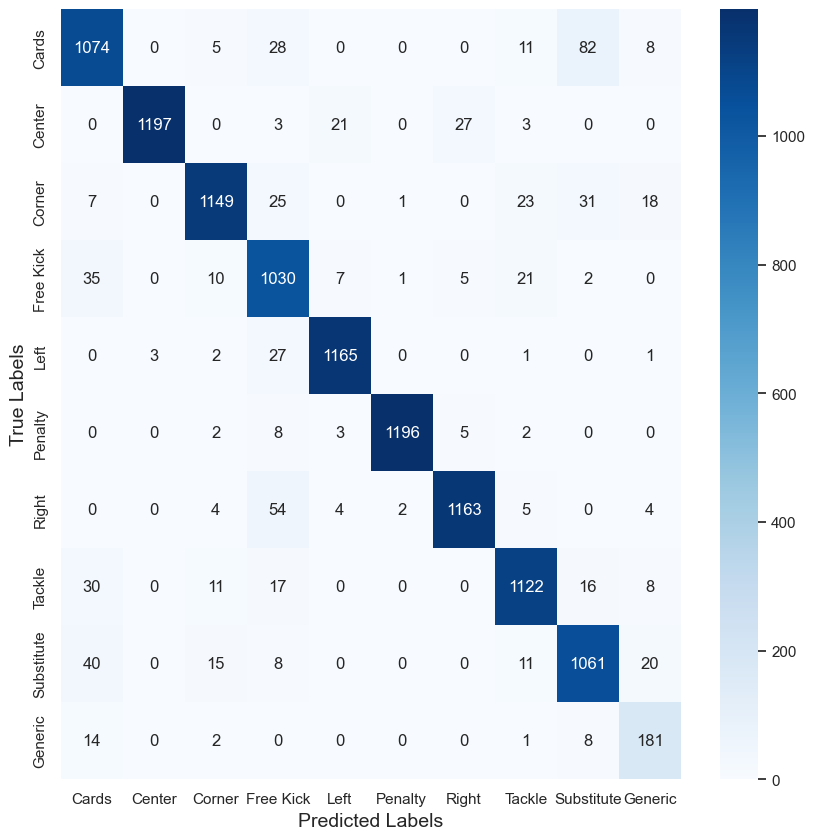

In [75]:
true_labels = tf.math.argmax(CNN_holdout_predictions[1], axis=1)
predicted_labels = tf.math.argmax(CNN_holdout_test_labels[1], axis=1)

confusion_matrix = tf.math.confusion_matrix(
    true_labels,
    predicted_labels,
    num_classes=10,
    weights=None,
    name=None
)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
sns.set (rc = {'figure.figsize':(10,10)})
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.yticks(np.arange(10)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute', 'Generic'), fontsize="11")
plt.xticks(np.arange(10)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute', 'Generic'), fontsize="11" )
plt.show()

In [73]:
# Save Soccer CNN with generic class
soccerAndGeneric_model = CNN_models[1]
soccerAndGeneric_model.save_weights('modelWeights/soccerAndGeneric_model.h5')

In [72]:
# Soccer+generic CNN metrics
CNN_metrics[1]

{'test_evaluation': {'loss': 0.22106623649597168,
  'accuracy': 0.936413049697876,
  'recall': 0.9294384121894836,
  'precision': 0.9471109509468079,
  'AUROC': 0.9938239455223083,
  'AUPRC': 0.976667046546936}}

In [79]:
# Save results (save dictionary to soccer_with_generic_metrics.pkl file)
with open('results/soccer_with_generic_metrics.pkl', 'wb') as fp:
    pickle.dump(CNN_metrics, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


#### Evaluation on real dataset

In [46]:
image_shape_gray = (soccer_images_dim,soccer_images_dim,1)
image_shape_rgb = (soccer_images_dim,soccer_images_dim,3)

In [76]:
## Load Model
# Create models
soccer_events_and_generic = build_soccer_CNN_with_generic(image_shape_gray)

# Restore the weights
soccer_events_and_generic.load_weights('modelWeights/soccerAndGeneric_model.h5')
soccer_events_and_generic._name = "soccer_events_and_generic"

Model: "Soccer_with_generic_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 10, 10

In [61]:
folderMyTestDataset = r'D:\MachineLearning\Datasets\Soccer\myDataset' # RealSoccer + events and genericSoccer images

data_myTest_t, _ = loadData(folderMyTestDataset, False)

In [62]:
soccer_generic_data = []

for folder in data_myTest_t:
    if folder != "Events" and folder != "Generic":
        for i in range(len(data_myTest_t[folder])):
            soccer_generic_data.append(data_myTest_t[folder][i])

for folder in data_myTest_t:
    if folder == "Generic":
        for i in range(len(data_myTest_t[folder])):
            soccer_generic_data.append(data_myTest_t[folder][i])

In [63]:
soccer_generic_data = np.array([np.expand_dims(x/255, axis=-1) for x in soccer_generic_data])

In [64]:
print(f"Data shape: {soccer_generic_data.shape}")
print(f"Labels shape: {soccer_generic_labels.shape}")

Data shape: (100, 80, 80, 1)
Labels shape: (100, 10)


50/50 [==============================] - 0s 5ms/step
soccer_events_and_generic metrics on real dataset:
Accuracy: 0.62
------------------------------
AUROC: 0.7888888888888889
------------------------------
AUPRC: 0.45661860361860357
--------------------------------------------------------------------------------


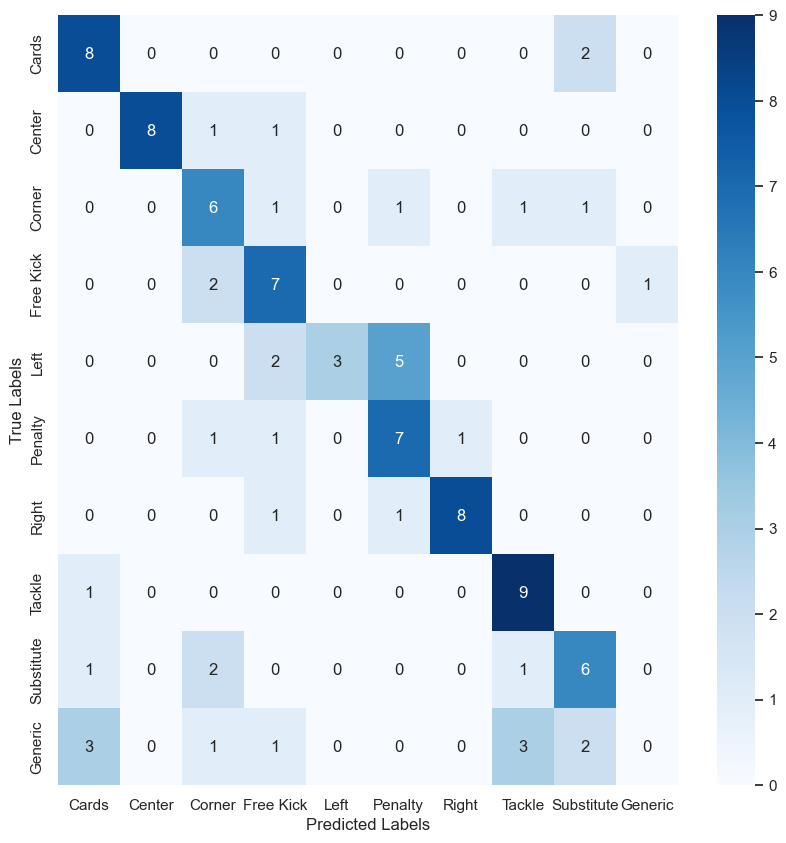

In [77]:
soccer_generic_predictions = get_predictions(soccer_events_and_generic, soccer_generic_data, 2)
          
# Shape (n_samples,)
labels = np.argmax(soccer_generic_labels, axis=1)
predictions = np.argmax(soccer_generic_predictions, axis=1)

acc, auroc, auprc = get_metrics(
    labels = labels,
    predictions = predictions
)

print(f"{soccer_events_and_generic.name} metrics on real dataset:")
print(f"Accuracy: {acc}")
print("-"*30)
print(f"AUROC: {auroc}")
print("-"*30)
print(f"AUPRC: {auprc}")
print("-"*80)

true_labels = labels
predicted_labels = predictions

confusion_matrix = tf.math.confusion_matrix(
    true_labels,
    predicted_labels,
    num_classes=10,
    weights=None,
    name=None
)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
sns.set (rc = {'figure.figsize':(8,8)})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.yticks(np.arange(10)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute', 'Generic'), fontsize="11")
plt.xticks(np.arange(10)+0.5,('Cards','Center','Corner', 'Free Kick', 'Left', 'Penalty', 'Right', 'Tackle', 'Substitute', 'Generic'), fontsize="11" )
plt.show()

## Complete classification pipeline definition

So far a few models were developed soccer event detection:
* Soccer CNN
* Soccer CNN with Data Augmentation
* ResNet
* VGG16
* Soccer CNN + generic event

The basic soccer CNN and soccer CNN with generic class show the best results under these specific test conditions.

A model for Cards binary classification was also deployed:
* Cards CNN

Here is a comparison of the various models performances on the event soccer detection task.

In [1]:
results = {"model":[], "accuracy":[], "AUROC":[], "AUPRC":[]}

In [4]:
# Load Results (Read dictionary pkl file)
with open('results/basic_CNN_metrics.pkl', 'rb') as fp:
    basic_CNN_metrics = pickle.load(fp)
with open('results/data_augmentation_basic_CNN_metrics.pkl', 'rb') as fp:
    data_augmentation_basic_CNN_metrics = pickle.load(fp)
with open('results/resNet_gray_metrics.pkl', 'rb') as fp:
    resNet_gray_metrics = pickle.load(fp)
with open('results/resNet_rgb_metrics.pkl', 'rb') as fp:
    resNet_rgb_metrics = pickle.load(fp)
with open('results/vgg_gray_metrics.pkl', 'rb') as fp:
    vgg_gray_metrics = pickle.load(fp)
with open('results/vgg_rgb_metrics.pkl', 'rb') as fp:
    vgg_rgb_metrics = pickle.load(fp)
with open('results/soccer_with_generic_metrics.pkl', 'rb') as fp:
    soccer_with_generic_metrics = []
    soccer_with_generic_metrics.append(pickle.load(fp))

In [6]:
# CNN metrics
for metrics, model in ((basic_CNN_metrics, "basic CNN"), (data_augmentation_basic_CNN_metrics, "data augmentation basic CNN"), (resNet_gray_metrics, "resNet gray CNN"), (resNet_rgb_metrics, "resNet rgb CNN"), (vgg_gray_metrics, "vgg gray CNN"), (vgg_rgb_metrics, "vgg rgb CNN"), (soccer_with_generic_metrics, "soccer with generic CNN")):
    i = 0
    for holdout in metrics:
        results["model"].append(model)
        results["accuracy"].append(holdout["test_evaluation"]["accuracy"])
        results["AUROC"].append(holdout["test_evaluation"]["AUROC"])
        results["AUPRC"].append(holdout["test_evaluation"]["AUPRC"])

In [8]:
import pandas as pd

In [9]:
results_df = pd.DataFrame(results)

In [ ]:
#TODO make nice graph

[(<Figure size 2400x420 with 1 Axes>,
  array([<Axes: title={'center': 'AUROC'}, xlabel='AUROC'>], dtype=object)),
 (<Figure size 2400x420 with 1 Axes>,
  array([<Axes: title={'center': 'AUPRC'}, xlabel='AUPRC'>], dtype=object)),
 (<Figure size 2400x420 with 1 Axes>,
  array([<Axes: title={'center': 'Accuracy'}, xlabel='Accuracy'>],
        dtype=object))]

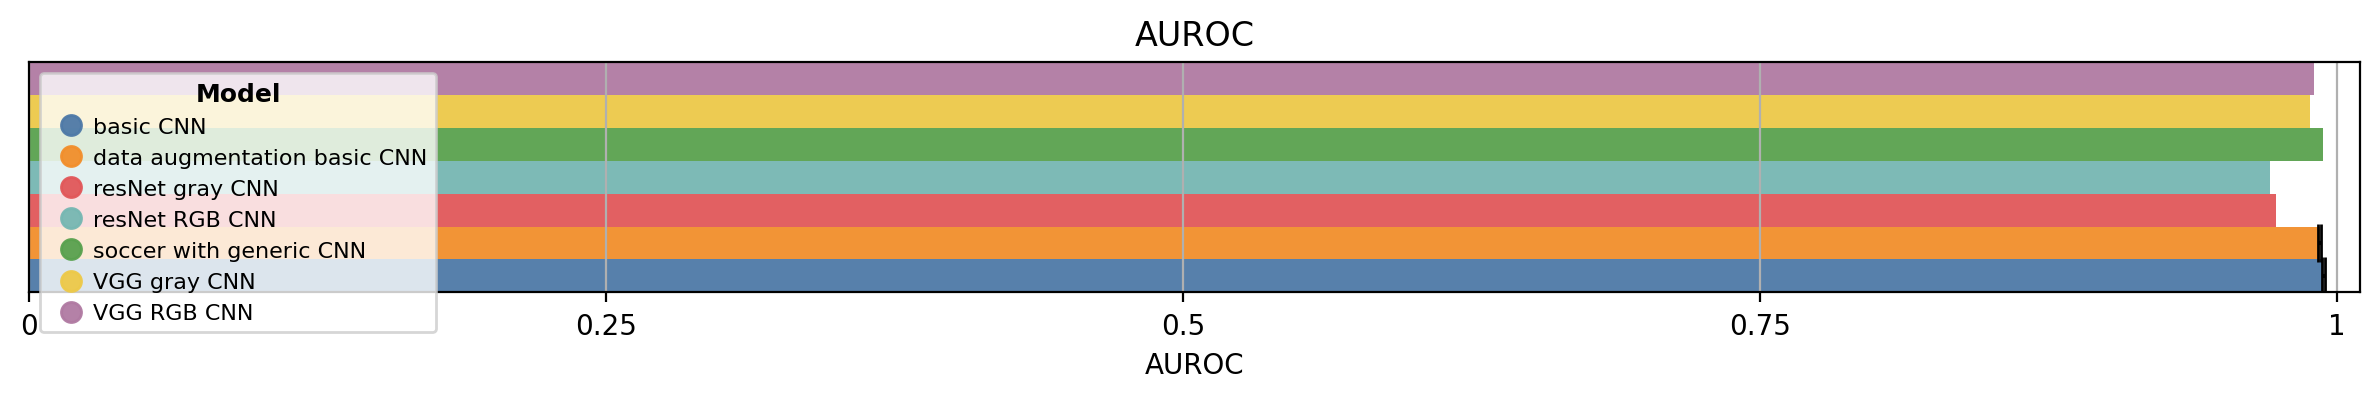

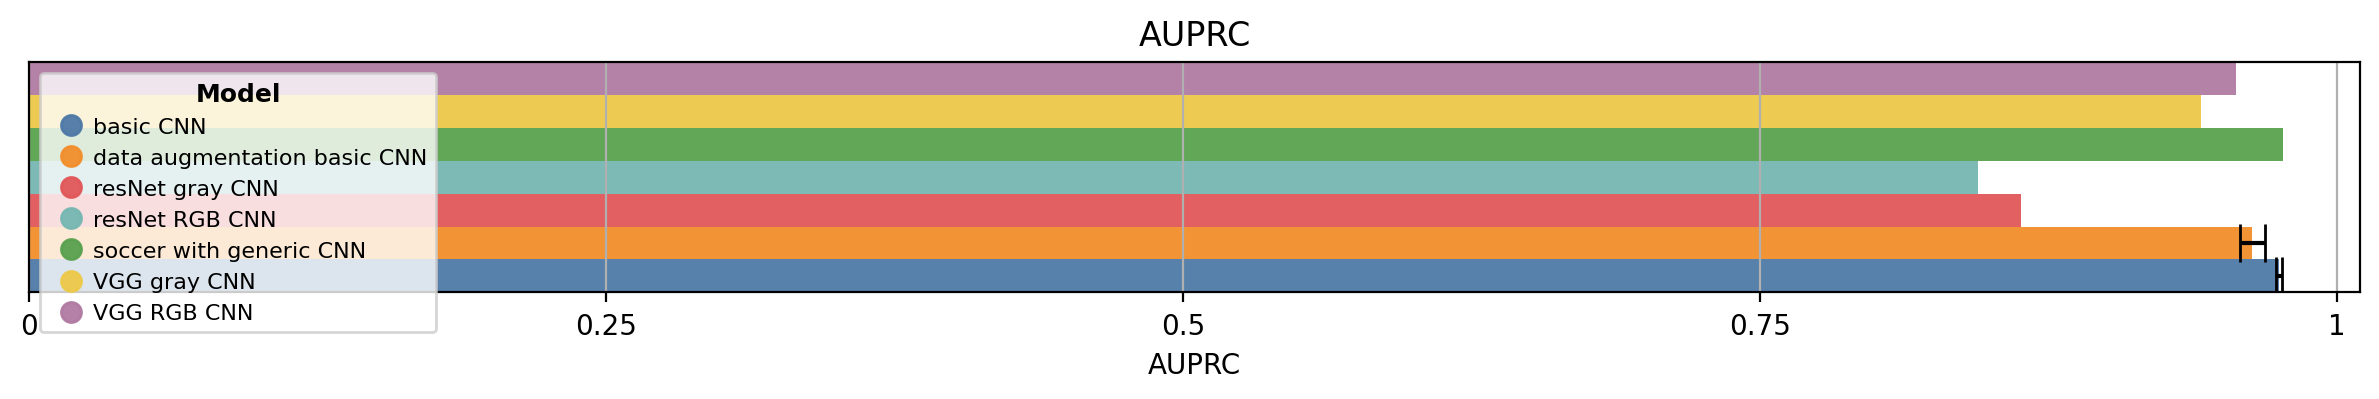

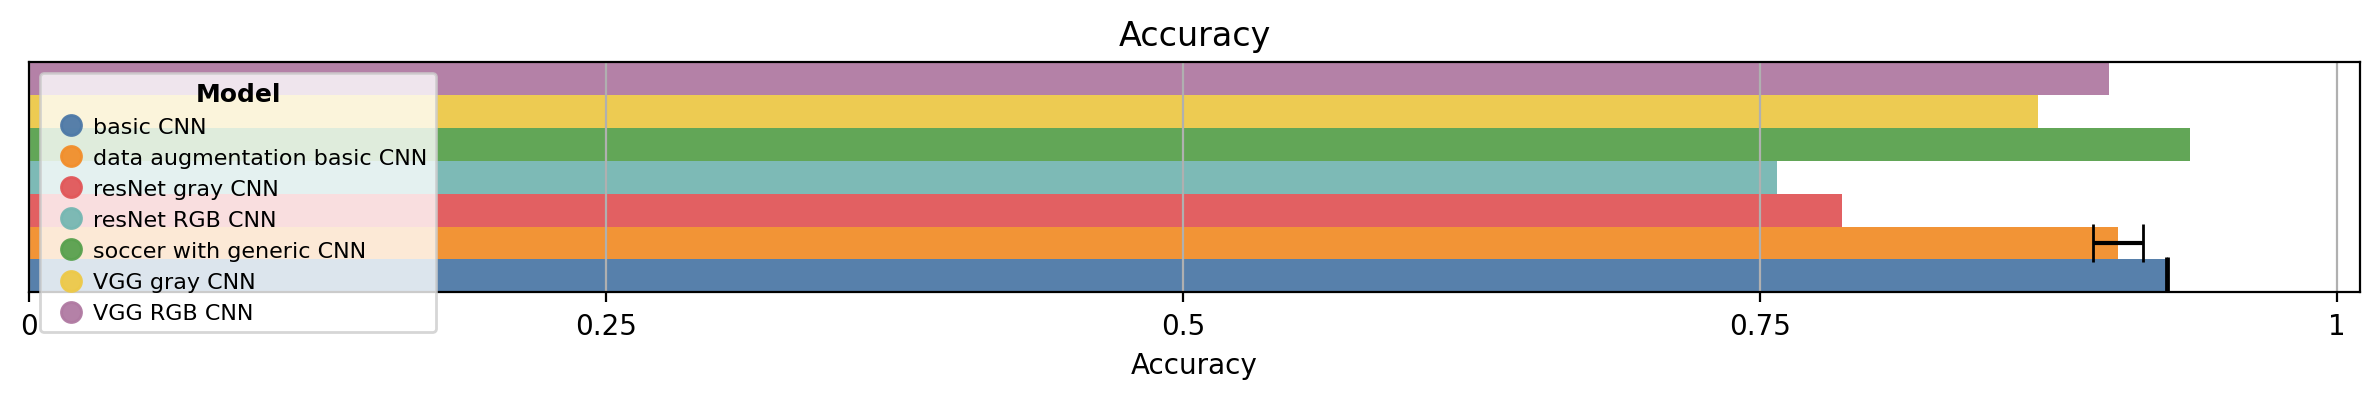

In [17]:
from barplots import barplots

barplots(
    results_df,
    groupby=["model"],
    orientation="horizontal",
    height=12,
    legend_position="upper left"
)

The next task to tackle is:
* Random image classification: filter out non soccer-related images.

This problem is studied with two approaches, generiting two different classification pipelines.  

**Approach A: Supervised Learning**  
Soccer VS Random classification CNN > Soccer Event Classification CNN > Cards Classification CNN.  

**Approach B: Unupervised Learning**  
Soccer VS Random clustering > Soccer Event Classification CNN > Cards Classification CNN.  

## Approach A - Supervised Learning
Design a CNN model for the binary classification on soccer related images and random images.

In [26]:
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits = number_of_splits,
    test_size = 0.2,
    random_state = 42
)

In [27]:
epochs = 100
batch_size = 32

In [29]:
# Create dataset (random soccer samples and event samples)
data_soccer_vs_events = []
labels_soccer_vs_events = []

# 1000 soccer images from soccer events
data_soccer_events = [np.squeeze(x, axis=-1) for x in data_soccer_all]
soccer_elements = random.sample(data_soccer_events, 1000)
data_soccer_vs_events.extend(soccer_elements)

# 400 soccer images from general soccer
general_soccer_elements = random.sample(data_generic_events["Soccer"], 400)
data_soccer_vs_events.extend(general_soccer_elements)

# 1400 images from generic events
data_soccer_vs_events.extend(data_generic_events["Random"])

for i in range(1400):
    labels_soccer_vs_events.append(0)
    
for i in range(1400):
    labels_soccer_vs_events.append(1)
    
labels_soccer_vs_events = one_hot_encoding(labels_soccer_vs_events, 2)
        

print(f"Data shape: {np.array(data_soccer_vs_events).shape}")
print(f"Labels shape: {labels_soccer_vs_events.shape}")

Data shape: (2800, 80, 80)
Labels shape: (2800, 2)


In [30]:
data_soccer_vs_events = [np.expand_dims(x, axis=-1) for x in data_soccer_vs_events]

In [31]:
def build_soccer_nonSoccer_CNN(
    input_shape: tuple
) -> tf.keras.Model:
    """ Returns the basic soccer CNN model.

    Parameters
    ------------------------
    input_shape: tuple
        The shape of the input.

    Returns
    ------------------------
    model: model
        The soccer vs random model."""

    CNN = Sequential(name="Soccer_Events_CNN")
    CNN.add(layers.Input(input_shape))
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),
    
    CNN.add(layers.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding='same',
        activation='relu'))
    CNN.add(layers.MaxPooling2D()),

    CNN.add(layers.Flatten())
    
    for i in range(2):
        CNN.add(layers.Dense(units = 128, activation='relu'))
        CNN.add(layers.Dropout(0.5))
        
    CNN.add(layers.Dense(2, activation='softmax'))
    
    CNN.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=get_standard_binary_metrics()
    )
    
    CNN.summary()
    
    return CNN

### Main training loop - Soccer vs Non-Soccer CNN
* Normalize images' values in 0-1 range.
* Build and train the model over the training set and test it over the test set for the different holdouts.

In [39]:
print("---- Soccer vs Non-Soccer CNN ----")

CNN_metrics = []
CNN_history = []

CNN_holdout_predictions = []
CNN_holdout_test_labels = []

CNN_models = []

# Generate holdouts
for holdout_number, (train_indices, test_indices) in enumerate(tqdm(holdouts_generator.split(data_soccer_vs_events, labels_soccer_vs_events))):
    print(f"-- HOLDOUT {holdout_number+1}")
    # Train/Test data + Normalization
    x_train, x_test = np.array([data_soccer_vs_events[x]/255 for x in train_indices]), np.array([data_soccer_vs_events[x]/255 for x in test_indices])
    y_train, y_test = labels_soccer_vs_events.iloc[train_indices], labels_soccer_vs_events.iloc[test_indices]

    # Build CNN
    CNN = build_soccer_nonSoccer_CNN(x_train[0].shape)

    print("- Training model:\n")
    CNN_holdout_metrics, CNN_holdout_history = train_model(
        CNN,
        x_train,
        x_test,
        y_train.values,
        y_test.values,
        epochs,
        batch_size
    )
    
    predictions = get_predictions(CNN, x_test, batch_size=batch_size)
    CNN_holdout_predictions.append(predictions)
    CNN_holdout_test_labels.append(y_test)

    CNN_metrics.append(CNN_holdout_metrics)
    CNN_history.append(CNN_holdout_history)
    
    CNN_models.append(CNN)

---- Soccer vs Non-Soccer CNN ----


0it [00:00, ?it/s]

-- HOLDOUT 1
Model: "Soccer_Events_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 128)       147584    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None,

1it [00:08,  8.43s/it]

-- HOLDOUT 2
Model: "Soccer_Events_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 128)       147584    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None,

2it [00:17,  8.68s/it]


Soccer VS Events - CNN Metrics - 2-holdouts estimate:
Accuracy : train - 0.9705357253551483  --  test - 0.9625000059604645
AUROC : train - 0.9916850328445435  --  test - 0.982855498790741
AUPRC : train - 0.9897907674312592  --  test - 0.9784724414348602
--------------------------------------------------------------------------------
CNN - Train history:


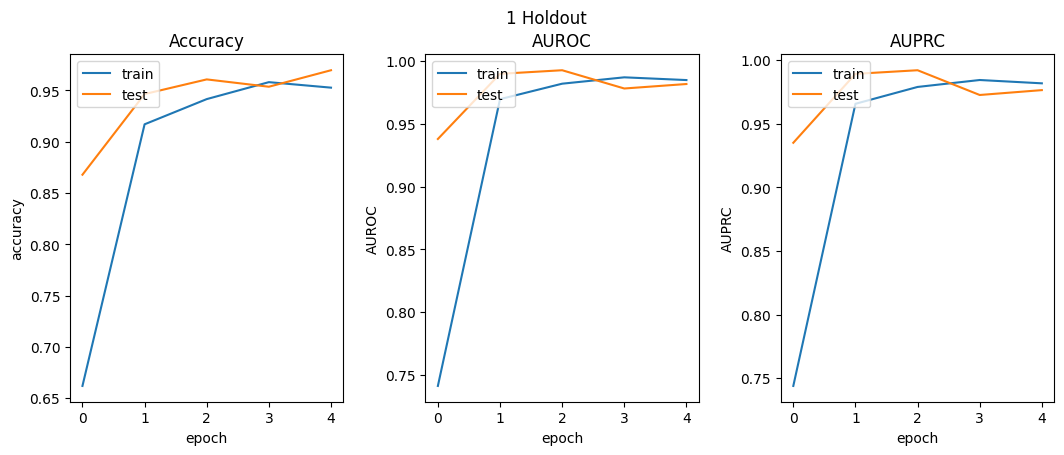

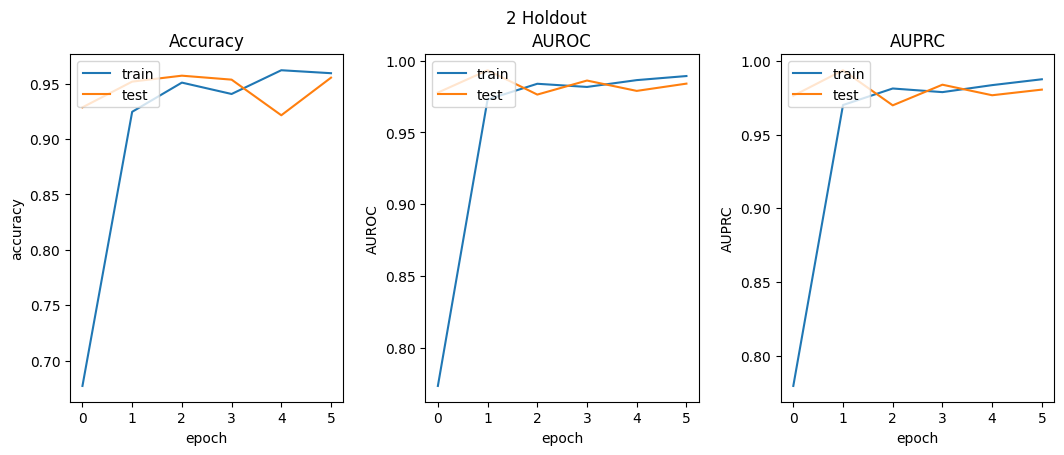

----------------------------------------------------------------------------------------------------


In [40]:
CNN_metrics_estimate = model_metrics_holdout_estimate(CNN_metrics, number_of_splits)

print(f"Soccer VS Events - CNN Metrics - {number_of_splits}-holdouts estimate:")
print(f"Accuracy : train - {CNN_metrics_estimate['accuracy_train']}  --  test - {CNN_metrics_estimate['accuracy_test']}")
print(f"AUROC : train - {CNN_metrics_estimate['AUROC_train']}  --  test - {CNN_metrics_estimate['AUROC_test']}")
print(f"AUPRC : train - {CNN_metrics_estimate['AUPRC_train']}  --  test - {CNN_metrics_estimate['AUPRC_test']}")
print("-"*80)
print("CNN - Train history:")
plot_train_history(CNN_history)
print("-"*100)

In [42]:
# Soccer vs Non-Soccer CNN Metrics
CNN_metrics[0]

{'train_evaluation': {'loss': 0.0713760033249855,
  'accuracy': 0.9741071462631226,
  'recall': 0.9741071462631226,
  'precision': 0.9741071462631226,
  'AUROC': 0.9940677881240845,
  'AUPRC': 0.9928805828094482,
  'f1_score': 0.9741071462631226,
  'balanced_accuracy': 0.9741071462631226,
  'specificity': 0.9741071462631226,
  'miss_rate': 0.02589285746216774,
  'fall_out': 0.02589285746216774,
  'mcc': 0.9482142925262451},
 'test_evaluation': {'loss': 0.11834557354450226,
  'accuracy': 0.9696428775787354,
  'recall': 0.9696428775787354,
  'precision': 0.9696428775787354,
  'AUROC': 0.9816644787788391,
  'AUPRC': 0.9764835834503174,
  'f1_score': 0.9696428775787354,
  'balanced_accuracy': 0.9696428775787354,
  'specificity': 0.9696428775787354,
  'miss_rate': 0.03035714291036129,
  'fall_out': 0.03035714291036129,
  'mcc': 0.9392856955528259}}

In [43]:
# Save Soccer CNN 
soccer_nonSoccer_model = CNN_models[0]
soccer_nonSoccer_model.save_weights('modelWeights/soccer_nonSoccer_model.h5')

#### Evaluation on myDataset

In [47]:
## Load Model
# Create models
events_vs_soccer = build_soccer_nonSoccer_CNN(image_shape_gray)

# Restore the weights
events_vs_soccer.load_weights('modelWeights/events_vs_soccer_model.h5')
events_vs_soccer._name = "events_vs_soccer"

Model: "Soccer_Events_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 40, 40, 128)       147584    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 20, 128)       147584    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 10, 10, 128)

In [48]:
#data_soccer is a dict containing ['events'...] so group together classes to evaluate
data_myTest_all = []
for event in data_myTest:
    for element in data_myTest[event]:
        data_myTest_all.append(element)

print(f"Data shape: {np.array(data_myTest_all).shape}")
print(f"Labels shape: {labels_myTest.shape}")

Data shape: (110, 80, 80)
Labels shape: (110, 11)


In [49]:
data_myTest_all = np.array([np.expand_dims(x/255, axis=-1) for x in data_myTest_all])

In [50]:
# Adjust labels for each step (only for final evaluation and confrontation)
# Events VS Soccer
events_vs_soccer_labels = pd.DataFrame(columns=[0,1])

event_value = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

for index, row in labels_myTest.iterrows():
    if np.array_equal(row.values, event_value):
        new_row = {0: 0.0, 1: 1.0}
        events_vs_soccer_labels.loc[index] = new_row
    else:
        new_row = {0: 1.0, 1: 0.0}
        events_vs_soccer_labels.loc[index] = new_row
        
events_vs_soccer_labels.sample(2)

0    1
17  1.0  0.0
92  1.0  0.0

55/55 [==============================] - 0s 1ms/step
events_vs_soccer metrics on real dataset:
Accuracy: 0.7181818181818181
------------------------------
AUROC: 0.7999999999999999
------------------------------
AUPRC: 0.2167832167832168
--------------------------------------------------------------------------------


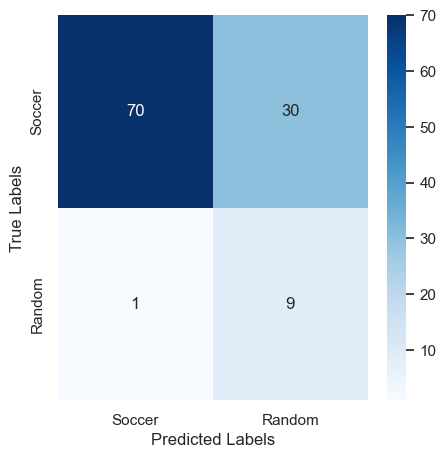

In [56]:
event_vs_soccer_predictions = get_predictions(events_vs_soccer, data_myTest_all, batch_size=2)
          
# Shape (n_samples,)
labels = np.argmax(events_vs_soccer_labels, axis=1)
predictions = np.argmax(event_vs_soccer_predictions, axis=1)

acc, auroc, auprc = get_metrics(
    labels = labels,
    predictions = predictions
)

print(f"{events_vs_soccer.name} metrics on real dataset:")
print(f"Accuracy: {acc}")
print("-"*30)
print(f"AUROC: {auroc}")
print("-"*30)
print(f"AUPRC: {auprc}")
print("-"*80)

true_labels = labels
predicted_labels = predictions

confusion_matrix = tf.math.confusion_matrix(
    true_labels,
    predicted_labels,
    num_classes=2,
    weights=None,
    name=None
)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
sns.set (rc = {'figure.figsize':(5,5)})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.yticks(np.arange(2)+0.5,('Soccer','Random'), fontsize="11")
plt.xticks(np.arange(2)+0.5,('Soccer','Random'), fontsize="11" )
plt.show()

## Approach B - Unsupervised Learning
Evaluate the clustering algorithms of **KMeans** and **Agglomerative Clustering** for the binary task of distinguishing soccer related images and random images.

In [138]:
n_labels = np.argmax(labels_generic_events, axis=-1)

In [139]:
from sklearn.cluster import KMeans, AgglomerativeClustering

def clustering(
    data: np.array,
    n_clusters: int
):
    "Return clustering predictions with Kmeans and Agglomerative Clustering."
    
    clustering_predictions = {}
    clustering_predictions["KMeans"] = []
    clustering_predictions["Agglomerative"] = []
    
    K_clust = KMeans(n_clusters = n_clusters, random_state = 42, n_init="auto").fit(data)
    A_clust = AgglomerativeClustering(n_clusters = n_clusters).fit(data)

    clustering_predictions["KMeans"].append(K_clust.fit_predict(data))
    clustering_predictions["Agglomerative"].append(A_clust.fit_predict(data))
    
    return clustering_predictions

In [140]:
from sklearn.decomposition import PCA

def get_pca_decomposition(
    X: np.array
) -> pd.DataFrame:
    """Return the 2D PCA decomposition of the given data."""
    
    return PCA(n_components=2).fit_transform(X)

In [141]:
# RGB images
folderGenericEvents = r'D:\MachineLearning\Datasets\Soccer\GenericEvents' # Generic soccer and random events

data_generic_events_rgb, labels_generic_events_rgb = loadData(folderGenericEvents, True)

unsupervised_input_data_rgb_all = []
for event in data_generic_events_rgb:
    for element in data_generic_events_rgb[event]:
        unsupervised_input_data_rgb_all.append(element)
        
unsupervised_input_data_rgb_all = np.array(unsupervised_input_data_rgb_all)

# Gray scale images
unsupervised_input_data_all = []
for event in data_generic_events:
    for element in data_generic_events[event]:
        unsupervised_input_data_all.append(element)
        
unsupervised_input_data_all = np.array(unsupervised_input_data_all)

In [142]:
print("-- Input data for clustering --")
# Raw pixel values
raw_input = unsupervised_input_data_all.reshape(2600, -1)
print(f"Raw pixel values: {raw_input.shape}")

# Raw pixel values (PCA -> 2)
PCA_raw_input = get_pca_decomposition(raw_input)
print(f"Raw pixel values (PCA -> 2): {PCA_raw_input.shape}")

# Raw pixel values RGB
raw_input_rgb = unsupervised_input_data_rgb_all.reshape(2600, -1)
print(f"Raw pixel values RGB: {raw_input_rgb.shape}")

# Raw pixel values (PCA -> 2)
PCA_raw_input_rgb = get_pca_decomposition(raw_input_rgb)
print(f"Raw pixel values RGB (PCA -> 2): {PCA_raw_input_rgb.shape}")

# Representation extracted from pre trained model
threeChannels_input = np.array([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in unsupervised_input_data_all])
image_shape = threeChannels_input.shape[1:]

resNet_feature_extraction = tf.keras.applications.resnet.ResNet50(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
resNet_feature_extraction.trainable = False

# Gray images
features = get_predictions(resNet_feature_extraction, threeChannels_input, 64).reshape(2600, -1)
print(f"CNN features: {features.shape}")

# RGB images
features_rgb = get_predictions(resNet_feature_extraction, unsupervised_input_data_rgb_all, 64).reshape(2600, -1)
print(f"CNN features RGB: {features_rgb.shape}")

# Representation extracted from pre trained model + avg pooling
inputs = tf.keras.Input(shape=image_shape)
x = resNet_feature_extraction(inputs)
outputs = layers.GlobalAveragePooling2D()(x)
resNet_feature_extraction_pool = tf.keras.Model(inputs, outputs)

# Gray images
features_pooling = get_predictions(resNet_feature_extraction_pool, threeChannels_input, 64).reshape(2600, -1)
print(f"CNN features + pooling: {features_pooling.shape}")

# RGB images
features_pooling_rgb = get_predictions(resNet_feature_extraction_pool, unsupervised_input_data_rgb_all, 64).reshape(2600, -1)
print(f"CNN features + pooling: {features_pooling_rgb.shape}")

# (PCA -> 2) features
PCA_features = get_pca_decomposition(features)
print(f"CNN features (PCA -> 2): {PCA_features.shape}")

PCA_features_pooling = get_pca_decomposition(features_pooling)
print(f"CNN features + pooling (PCA -> 2): {PCA_features_pooling.shape}")

PCA_features_rgb = get_pca_decomposition(features_rgb)
print(f"CNN features RGB (PCA -> 2): {PCA_features_rgb.shape}")

PCA_features_pooling_rgb = get_pca_decomposition(features_pooling_rgb)
print(f"CNN features + pooling RGB (PCA -> 2): {PCA_features_pooling_rgb.shape}")

import skimage.feature

matrix_features = []
hog_features = []
for image in unsupervised_input_data_all:
    # Texture Features to capture texture patterns.
    # Calculate the co-occurrence matrix for the image and extract texture features
    co_matrix = skimage.feature.graycomatrix(image, [5], [0], levels=256)

    image_matrix_features = []
    contrast = skimage.feature.graycoprops(co_matrix, 'contrast')
    correlation = skimage.feature.graycoprops(co_matrix, 'correlation')
    energy = skimage.feature.graycoprops(co_matrix, 'energy')
    homogeneity = skimage.feature.graycoprops(co_matrix, 'homogeneity')
    
    image_matrix_features.append(contrast)
    image_matrix_features.append(correlation)
    image_matrix_features.append(energy)
    image_matrix_features.append(homogeneity)
    matrix_features.append(image_matrix_features)
    
    # Hog Features to capture object shapes and structures.
    from skimage.feature import hog
    from skimage import data, exposure

    hog_image = hog(
        image,
        orientations=5,
        pixels_per_cell=(10, 10),
        cells_per_block=(1, 1)
    )
    hog_features.append(hog_image)
    
matrix_features = np.array(matrix_features)
matrix_features = matrix_features.squeeze()
print(f"Co-occurrence matrix features {matrix_features.shape}")

PCA_matrix_features = get_pca_decomposition(matrix_features)
print(f"Co-occurrence matrix features (PCA -> 2) {PCA_matrix_features.shape}")

hog_features = np.array(hog_features)
print(f"HOG features {hog_features.shape}")

PCA_hog_features = get_pca_decomposition(hog_features)
print(f"HOG features (PCA -> 2) {PCA_hog_features.shape}")

-- Input data for clustering --
Raw pixel values: (2600, 6400)
Raw pixel values (PCA -> 2): (2600, 2)
Raw pixel values RGB: (2600, 19200)
Raw pixel values RGB (PCA -> 2): (2600, 2)
41/41 [==============================] - 1s 21ms/step
CNN features: (2600, 18432)
41/41 [==============================] - 1s 13ms/step
CNN features RGB: (2600, 18432)
41/41 [==============================] - 1s 14ms/step
CNN features + pooling: (2600, 2048)
41/41 [==============================] - 1s 14ms/step
CNN features + pooling: (2600, 2048)
CNN features (PCA -> 2): (2600, 2)
CNN features + pooling (PCA -> 2): (2600, 2)
CNN features RGB (PCA -> 2): (2600, 2)
CNN features + pooling RGB (PCA -> 2): (2600, 2)
Co-occurrence matrix features (2600, 4)
Co-occurrence matrix features (PCA -> 2) (2600, 2)
HOG features (2600, 320)
HOG features (PCA -> 2) (2600, 2)


In [143]:
predictions = {}
for input_data_name, input_data in (
    ("Raw", raw_input),
    ("PCA_raw", PCA_raw_input),
    ("Raw_rgb", raw_input_rgb),
    ("PCA_raw_rgb", PCA_raw_input_rgb),
    ("Features", features),
    ("Features+Pooling", features_pooling),
    ("Features_rgb", features_rgb),
    ("Features+Pooling_rgb", features_pooling_rgb),
    ("PCA_features", PCA_features),
    ("PCA_features_pooling", PCA_features_pooling),
    ("PCA_features_rgb", PCA_features_rgb),
    ("PCA_features_pooling_rgb", PCA_features_pooling_rgb),
    ("Matrix_features", matrix_features),
    ("PCA_matrix_features", PCA_matrix_features),
    ("Hog_features", hog_features),
    ("PCA_hog_features", PCA_hog_features)):
    
    predictions[input_data_name] = []
    predictions[input_data_name].append(clustering(input_data, 2))

#### Labels mismatch
This is binary clustering and the clustering algorithms are given the n_clusters=2 and always try to group datapoints (e.i don't output the same cluster for all datapoints).  
Hence the label mismatch fix can be applied for an extrinsic evaluation by mapping clusters containing a majority of preditions of a label to that label.

In [144]:
import numpy as np

def fix_clustering_label_mismatch(true_labels, predicted_labels):
    """ Returns the predictions with the proper labels, a cluster represents the label most present in it."""

    swap = False
    
    # Change shape from (n_samples,) to (n_samples, n_classes)
    labels = label_binarize(true_labels, classes=np.unique(true_labels))
    predictions = label_binarize(predicted_labels, classes=np.unique(predicted_labels)) 
        
    # Check if there is a label mismatch (below 50% accuracy)
    if accuracy_score(labels, predictions) < 0.5:
        # Swapping label encoding to match majority in clusters
        fixed_predicted_labels = 1 - predicted_labels
        swap = True
        return true_labels, fixed_predicted_labels, swap
    
    return true_labels, predicted_labels, swap

In [145]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

n_labels = np.argmax(labels_generic_events, axis=-1)

swap_list = {}
swap_list["KMeans"] = []
swap_list["Agglomerative"] = []

clustering_ex_results_KMeans = {"features":[], "accuracy":[], "AUROC":[], "AUPRC":[]}
clustering_ex_results_Agglomerative = {"features":[], "accuracy":[], "AUROC":[], "AUPRC":[]}

clustering_in_results_KMeans = {"features":[], "mif":[], "ars":[], "silhouette":[], "MSE":[]}
clustering_in_results_Agglomerative = {"features":[], "mif":[], "ars":[], "silhouette":[], "MSE":[]}

for data_type in predictions:
    print(f"-- Results for {data_type} input data --")
    for algorithm in predictions[data_type][0]:
        print(f"\n- Algorithm {algorithm}")
        
        true_labels = n_labels
        predicted_labels = predictions[data_type][0][algorithm][0]
        
        # Assign label to cluster where it's more present
        true_labels, predicted_labels, swap = fix_clustering_label_mismatch(true_labels, predicted_labels)
        
        # To visualize the correct labels in plot
        if "PCA" in data_type:
            swap_list[algorithm].append(swap)
        
        acc, auroc, auprc = get_metrics(
            labels = true_labels,
            predictions = predicted_labels
        )

        print("Extrinsic evaluation:")
        print("-"*40)
        print(f"Accuracy: {acc}")
        print("-"*30)
        print(f"AUROC: {auroc}")
        print("-"*30)
        print(f"AUPRC: {auprc}")
        print("-"*30)

        print("Intrinsic evaluation:")
        print("-"*40)
        mif = mutual_info_score(true_labels, predicted_labels)
        print(f"Mutual info score:   {mif}")
        ars = adjusted_rand_score(true_labels, predicted_labels)
        print(f"Adjusted rand score: {ars}")
        silhouette = silhouette_score(true_labels.reshape(-1, 1), predicted_labels)
        print(f"Silhouette score:    {silhouette}")
        MSE = mean_squared_error(true_labels, predicted_labels)
        print(f"Mean squared error:  {MSE}")
        
        if algorithm == "KMeans":
            clustering_ex_results_KMeans["features"].append(data_type)
            clustering_ex_results_KMeans["accuracy"].append(acc)
            clustering_ex_results_KMeans["AUROC"].append(auroc)
            clustering_ex_results_KMeans["AUPRC"].append(auprc)
            
            clustering_in_results_KMeans["features"].append(data_type)
            clustering_in_results_KMeans["mif"].append(mif)
            clustering_in_results_KMeans["ars"].append(ars)
            clustering_in_results_KMeans["silhouette"].append(silhouette)
            clustering_in_results_KMeans["MSE"].append(MSE)
        elif algorithm == "Agglomerative":
            clustering_ex_results_Agglomerative["features"].append({data_type})
            clustering_ex_results_Agglomerative["accuracy"].append(acc)
            clustering_ex_results_Agglomerative["AUROC"].append(auroc)
            clustering_ex_results_Agglomerative["AUPRC"].append(auprc)
            
            clustering_in_results_Agglomerative["features"].append({data_type})
            clustering_in_results_Agglomerative["mif"].append(mif)
            clustering_in_results_Agglomerative["ars"].append(ars)
            clustering_in_results_Agglomerative["silhouette"].append(silhouette)
            clustering_in_results_Agglomerative["MSE"].append(MSE)
                    
    print("-"*60)
    print("")

-- Results for Raw input data --

- Algorithm KMeans
Extrinsic evaluation:
----------------------------------------
Accuracy: 0.595
------------------------------
AUROC: 0.596845238095238
------------------------------
AUPRC: 0.5193937701662944
------------------------------
Intrinsic evaluation:
----------------------------------------
Mutual info score:   0.01880166161812219
Adjusted rand score: 0.035725338741475494
Silhouette score:    0.06044244678260578
Mean squared error:  0.405

- Algorithm Agglomerative
Extrinsic evaluation:
----------------------------------------
Accuracy: 0.6
------------------------------
AUROC: 0.5920238095238095
------------------------------
AUPRC: 0.5189239383804601
------------------------------
Intrinsic evaluation:
----------------------------------------
Mutual info score:   0.01775557547950879
Adjusted rand score: 0.03937162945708509
Silhouette score:    0.06613334601984541
Mean squared error:  0.4
--------------------------------------------------

Silhouette score:    0.1346832120122245
Mean squared error:  0.35115384615384615
------------------------------------------------------------

-- Results for PCA_features_pooling input data --

- Algorithm KMeans
Extrinsic evaluation:
----------------------------------------
Accuracy: 0.6303846153846154
------------------------------
AUROC: 0.6151785714285715
------------------------------
AUPRC: 0.5429844238330477
------------------------------
Intrinsic evaluation:
----------------------------------------
Mutual info score:   0.03205224661615563
Adjusted rand score: 0.06676229538776672
Silhouette score:    0.10729766349124768
Mean squared error:  0.3696153846153846

- Algorithm Agglomerative
Extrinsic evaluation:
----------------------------------------
Accuracy: 0.5834615384615385
------------------------------
AUROC: 0.5777380952380953
------------------------------
AUPRC: 0.5078864368140262
------------------------------
Intrinsic evaluation:
--------------------------------------

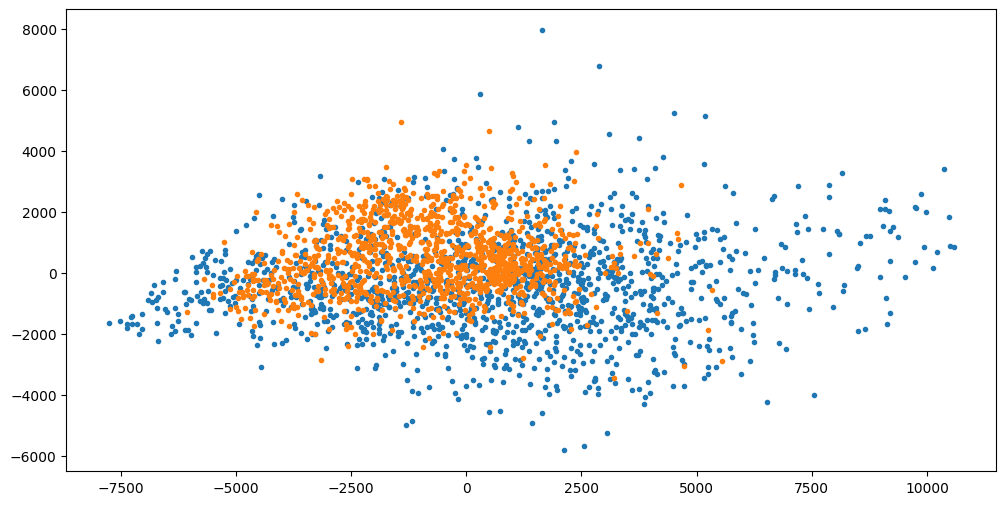

- KMeans predictions on PCA_raw_input -


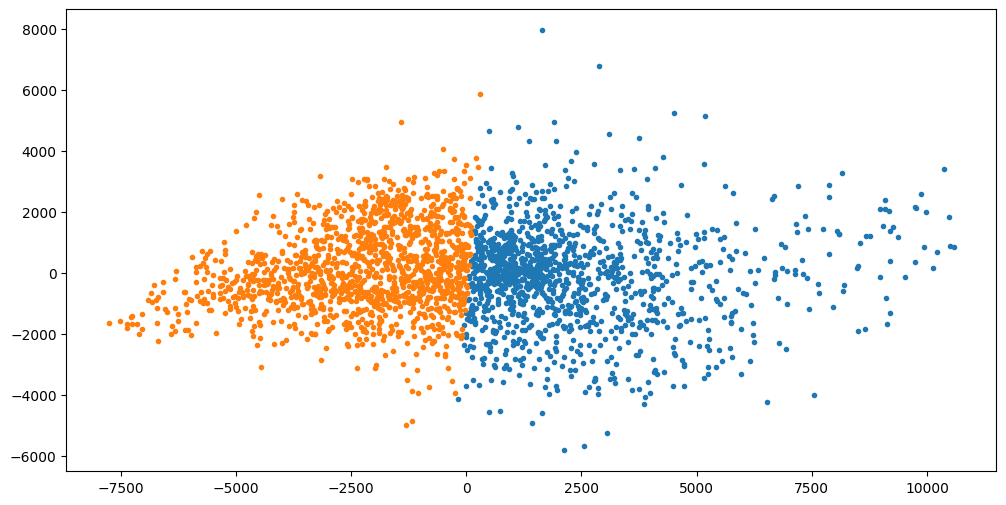

----------------------------------------------------------------------------------------------------


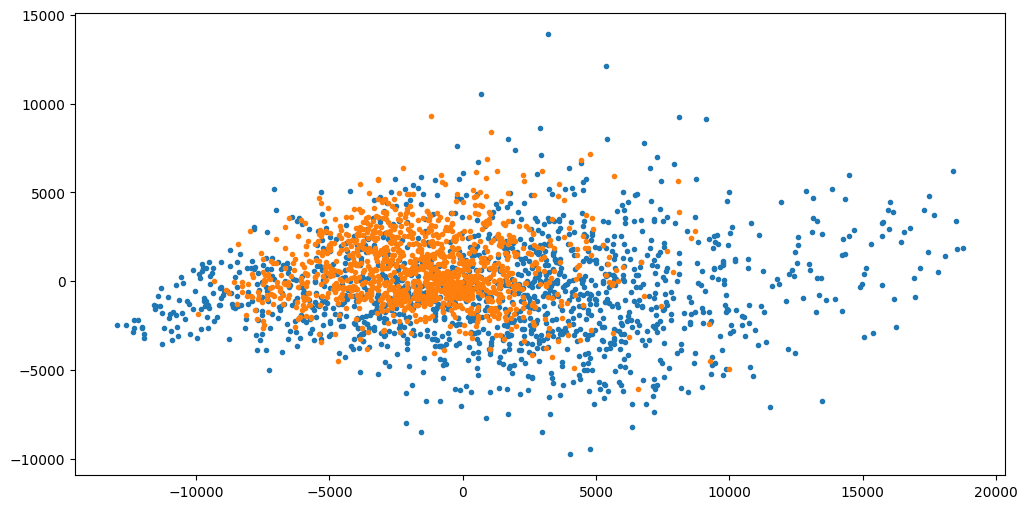

- KMeans predictions on PCA_raw_input_rgb -


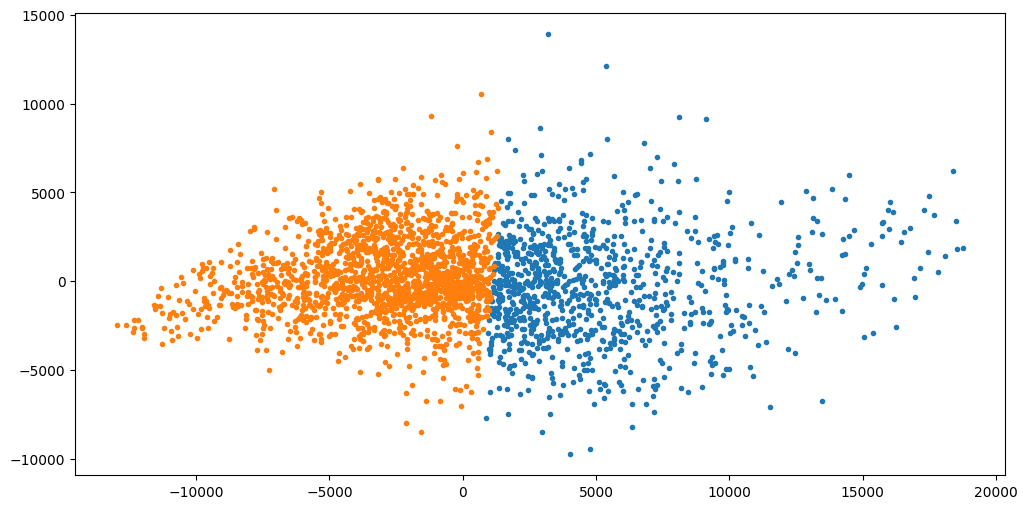

----------------------------------------------------------------------------------------------------


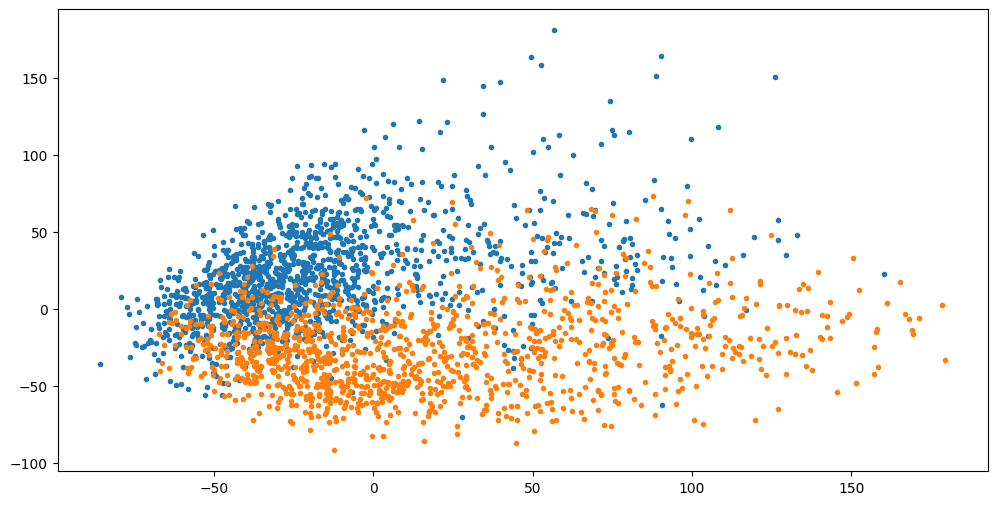

- KMeans predictions on PCA_features -


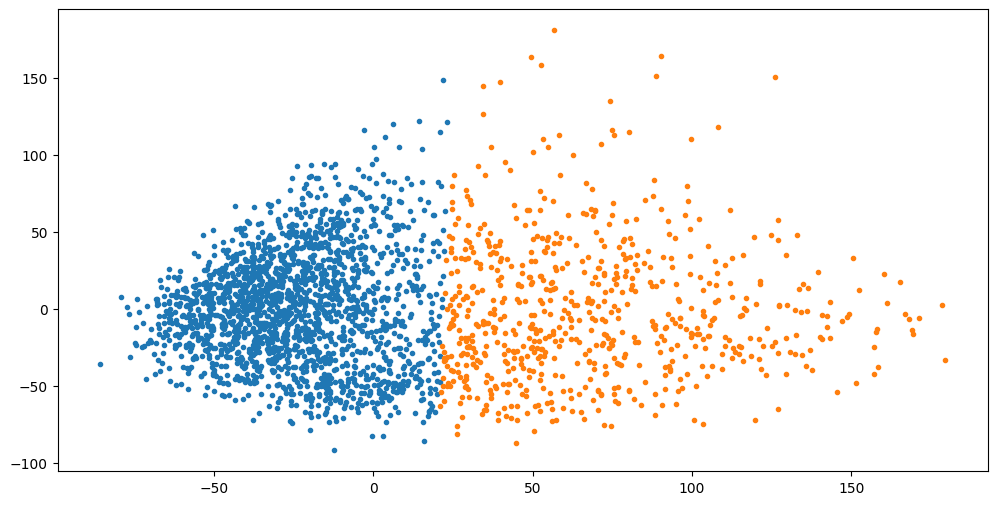

----------------------------------------------------------------------------------------------------


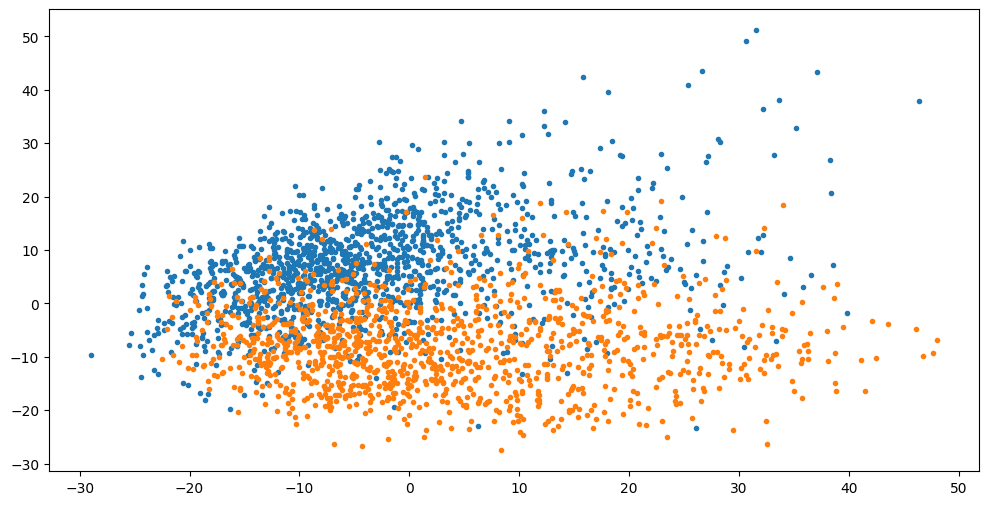

- KMeans predictions on PCA_features_pooling -


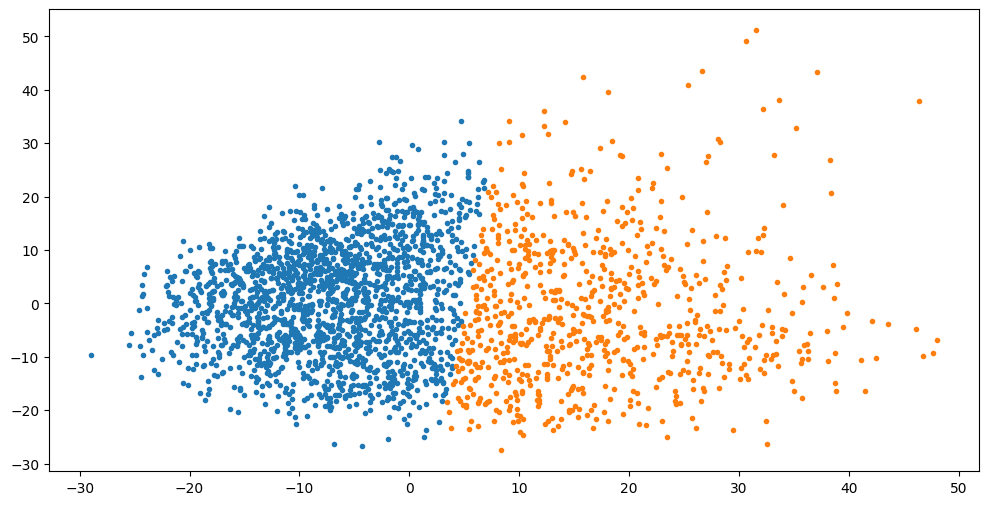

----------------------------------------------------------------------------------------------------


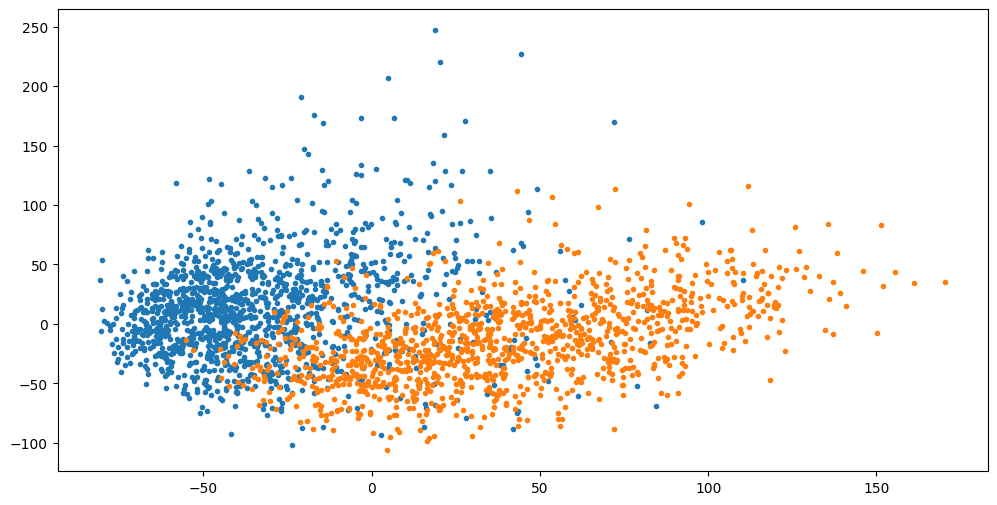

- KMeans predictions on PCA_features_rgb -


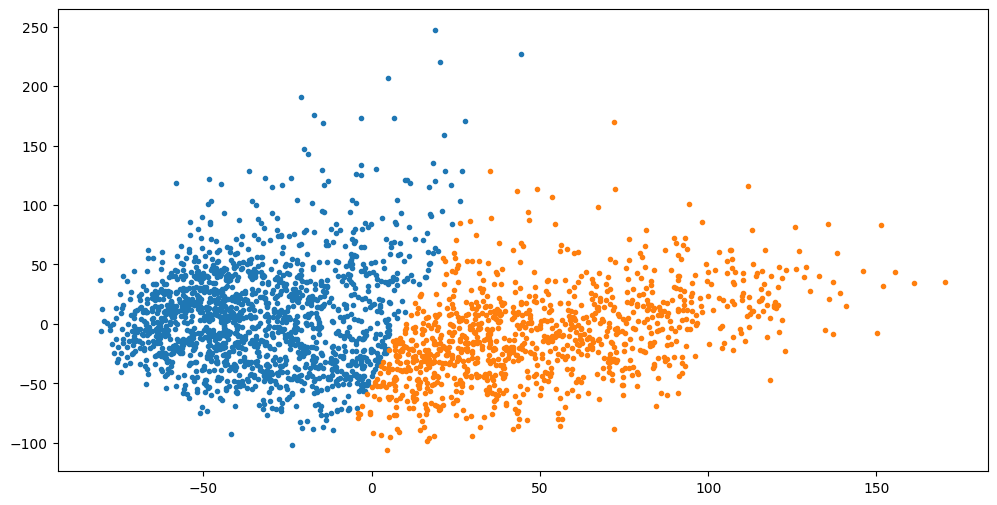

----------------------------------------------------------------------------------------------------


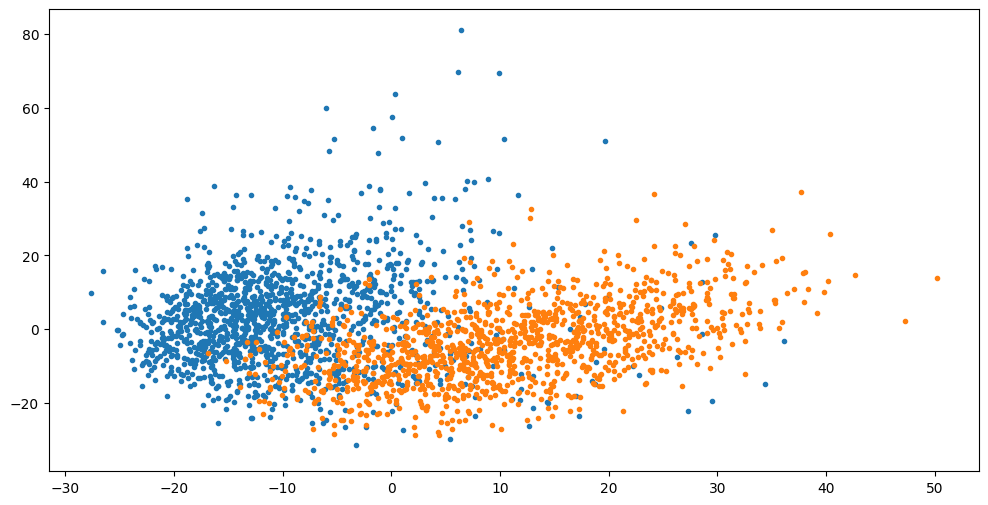

- KMeans predictions on PCA_features_pooling_rgb -


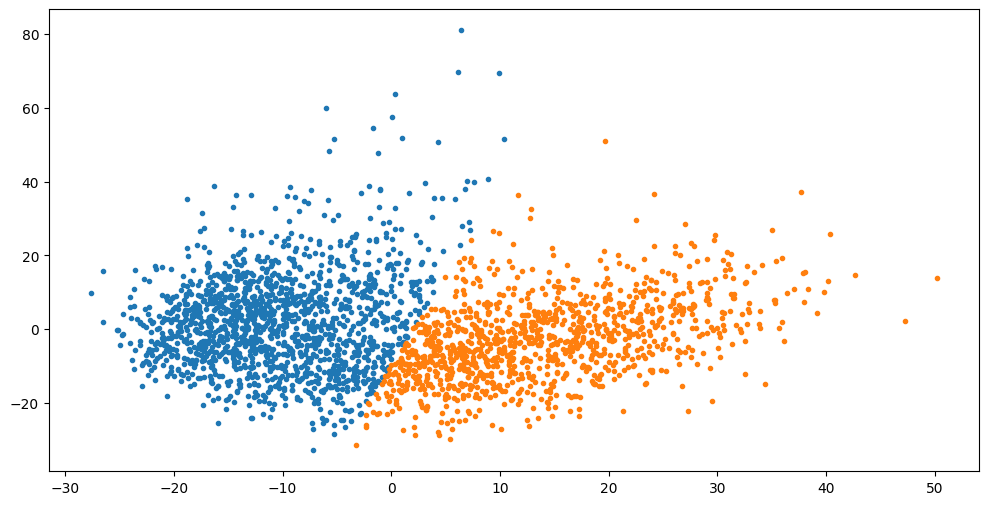

----------------------------------------------------------------------------------------------------


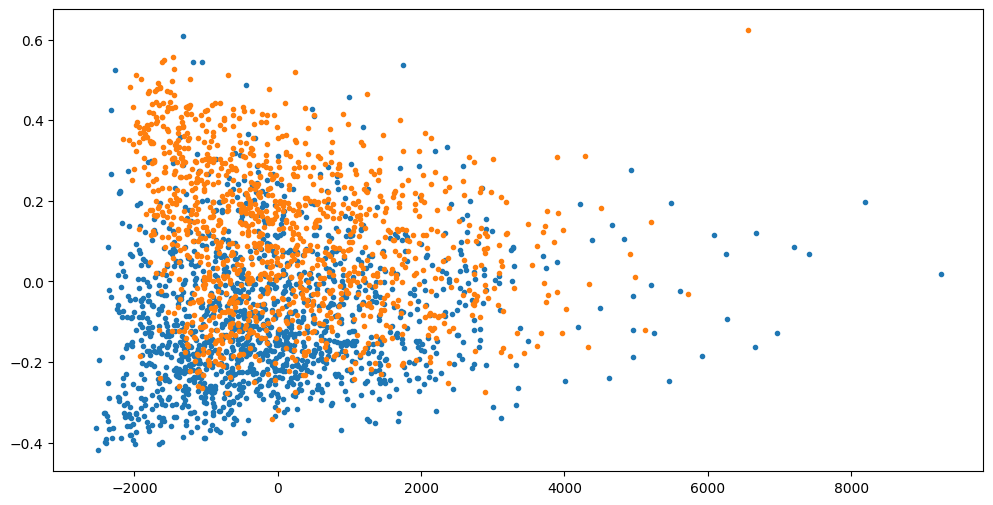

- KMeans predictions on PCA_matrix_features -


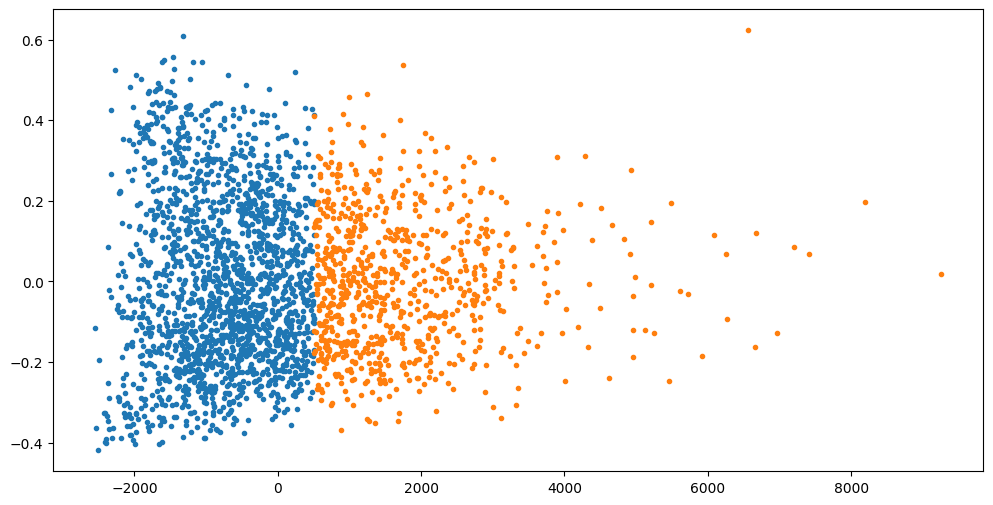

----------------------------------------------------------------------------------------------------


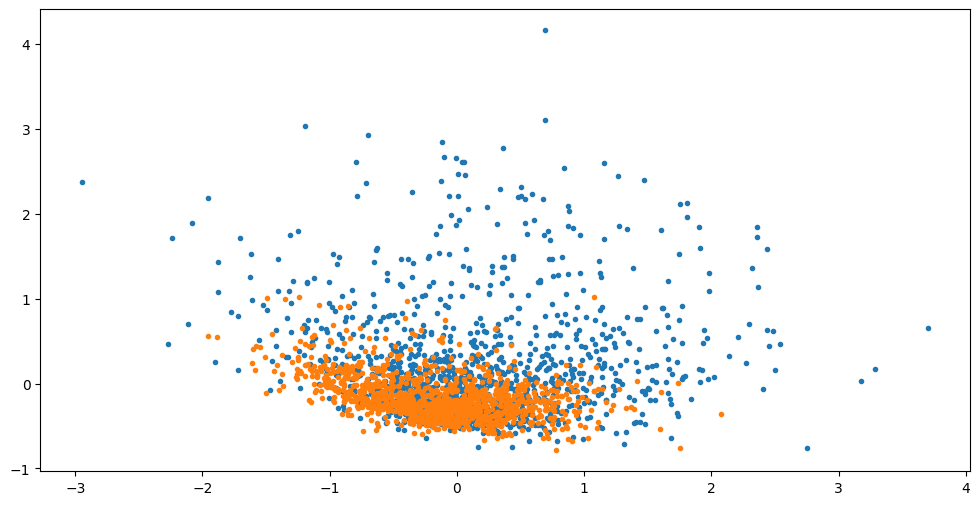

- KMeans predictions on PCA_hog_features -


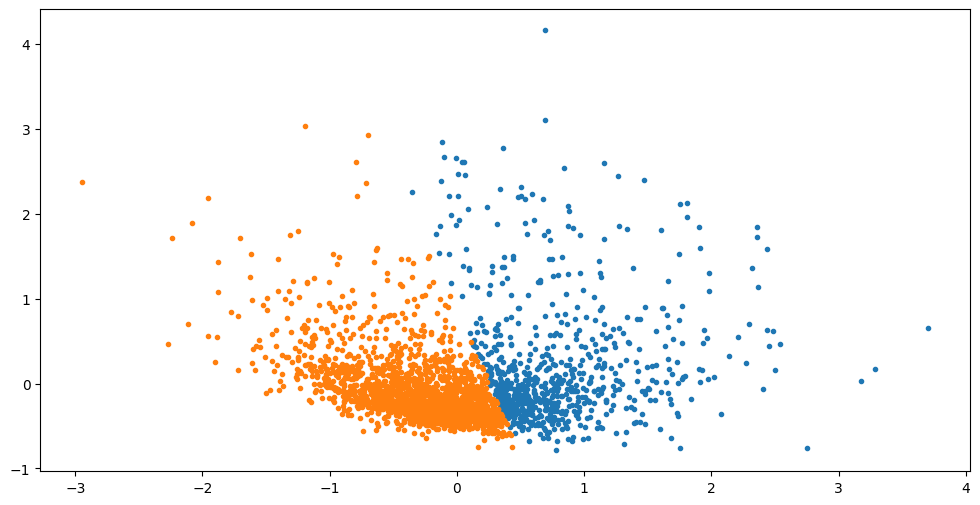

----------------------------------------------------------------------------------------------------


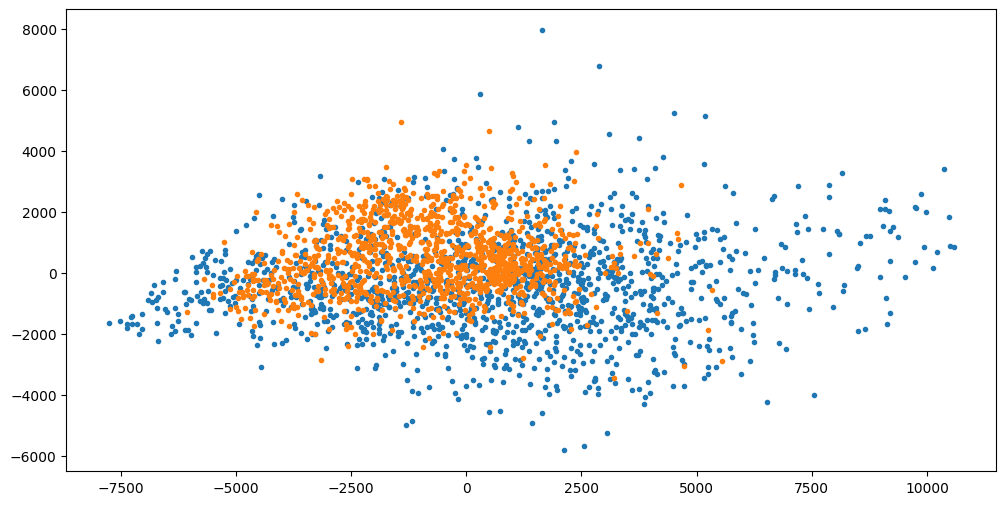

- Agglomerative predictions on PCA_raw_input -


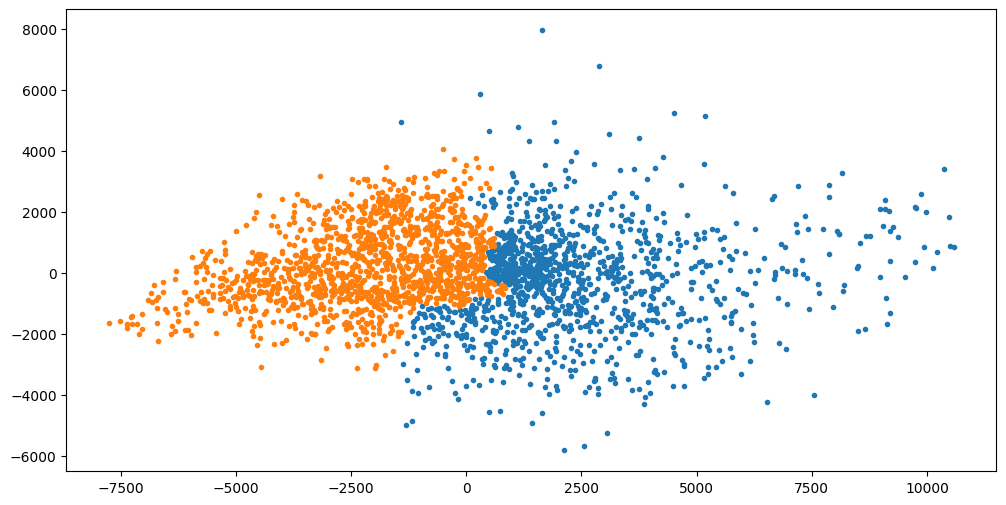

----------------------------------------------------------------------------------------------------


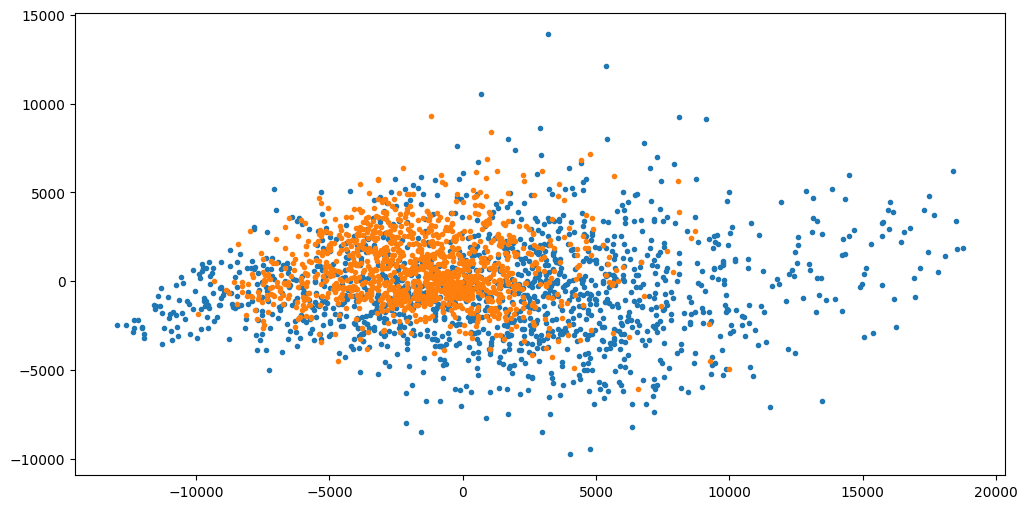

- Agglomerative predictions on PCA_raw_input_rgb -


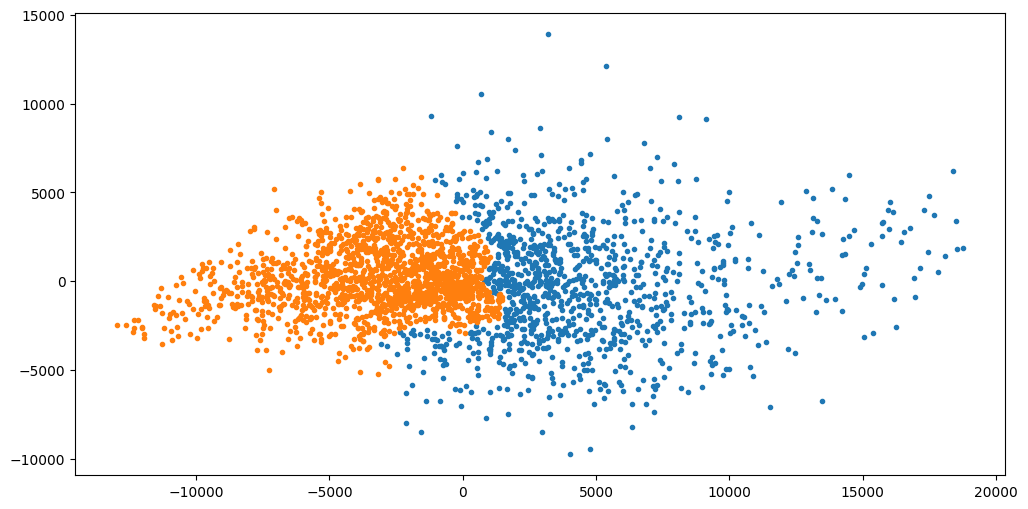

----------------------------------------------------------------------------------------------------


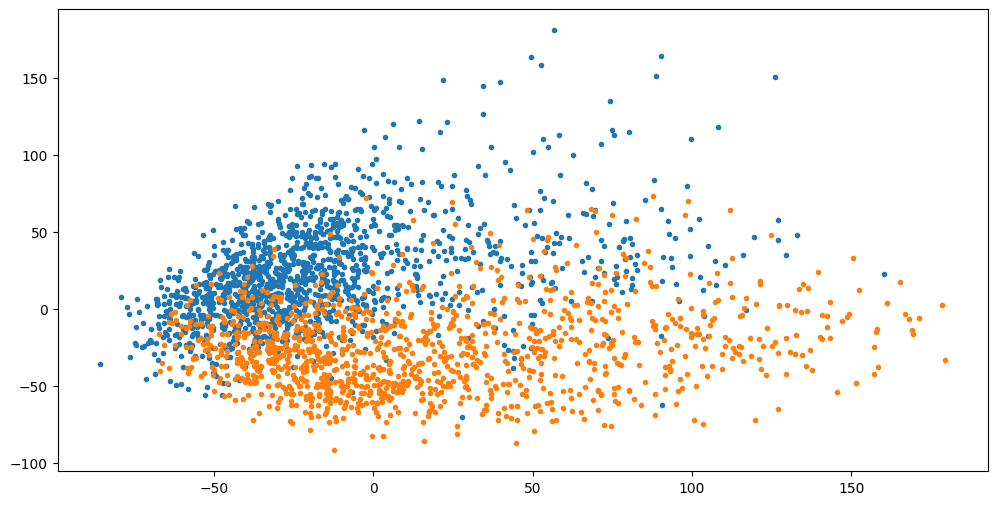

- Agglomerative predictions on PCA_features -


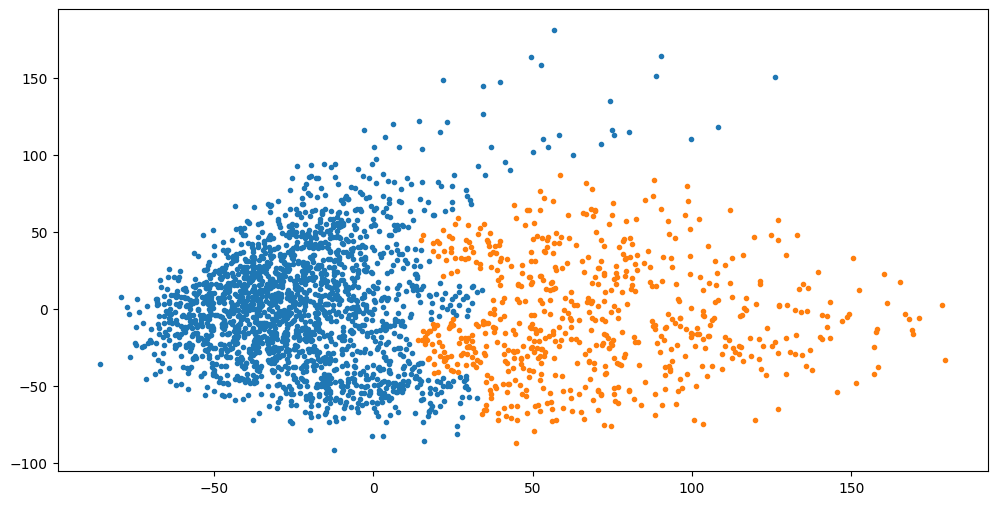

----------------------------------------------------------------------------------------------------


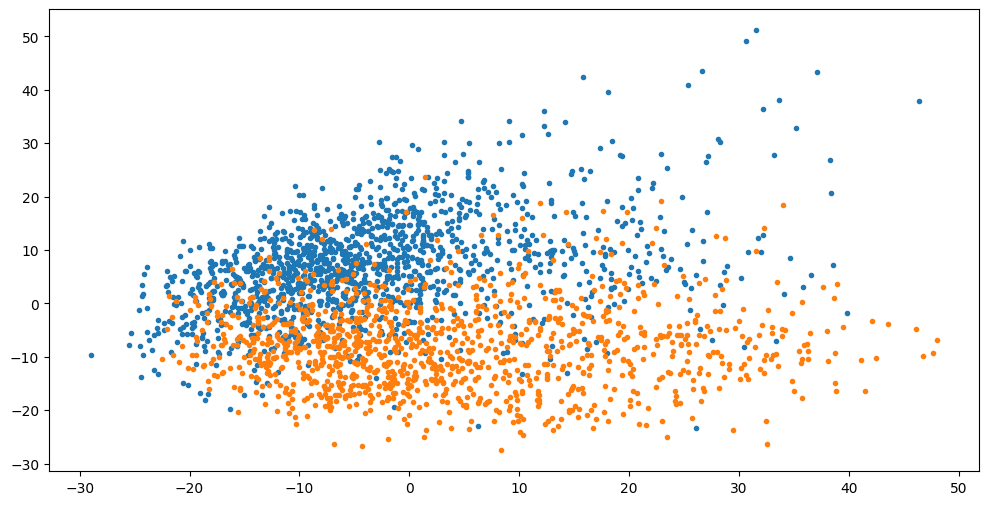

- Agglomerative predictions on PCA_features_pooling -


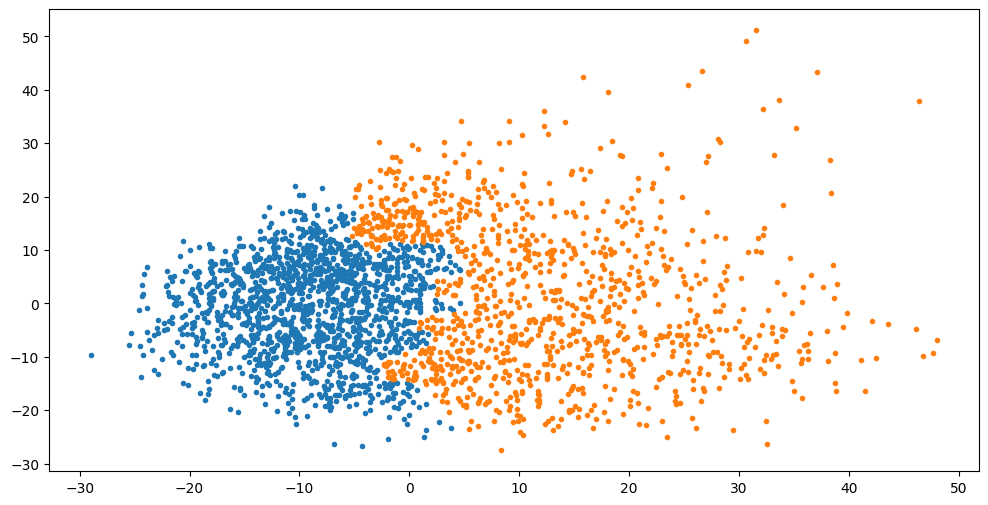

----------------------------------------------------------------------------------------------------


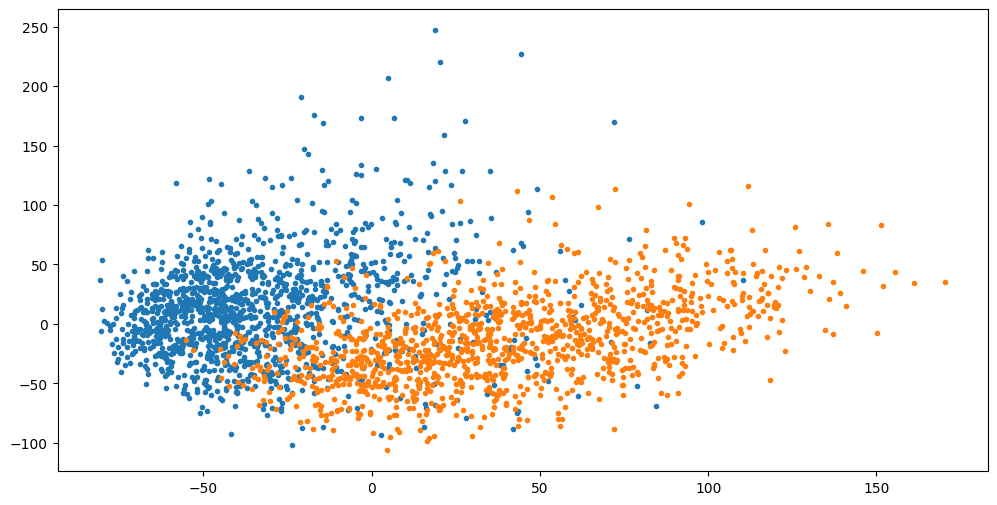

- Agglomerative predictions on PCA_features_rgb -


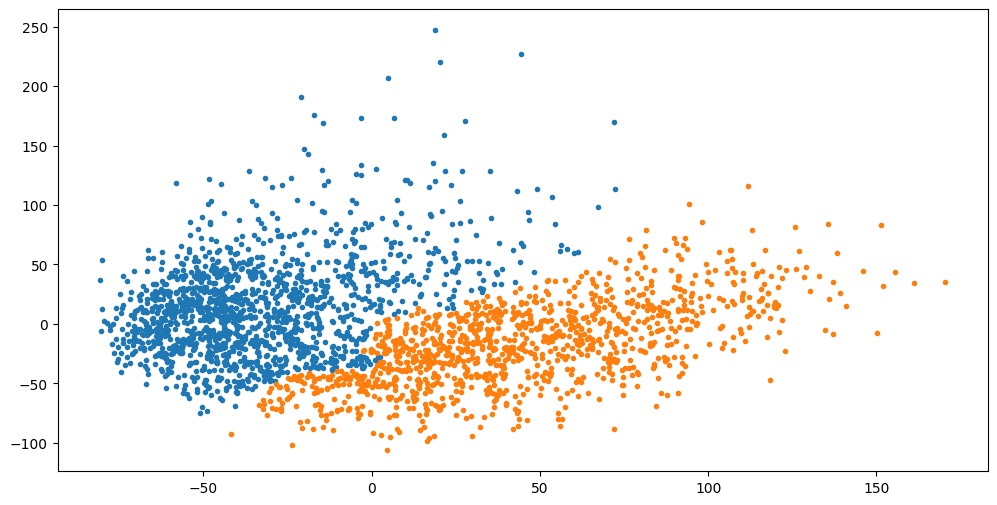

----------------------------------------------------------------------------------------------------


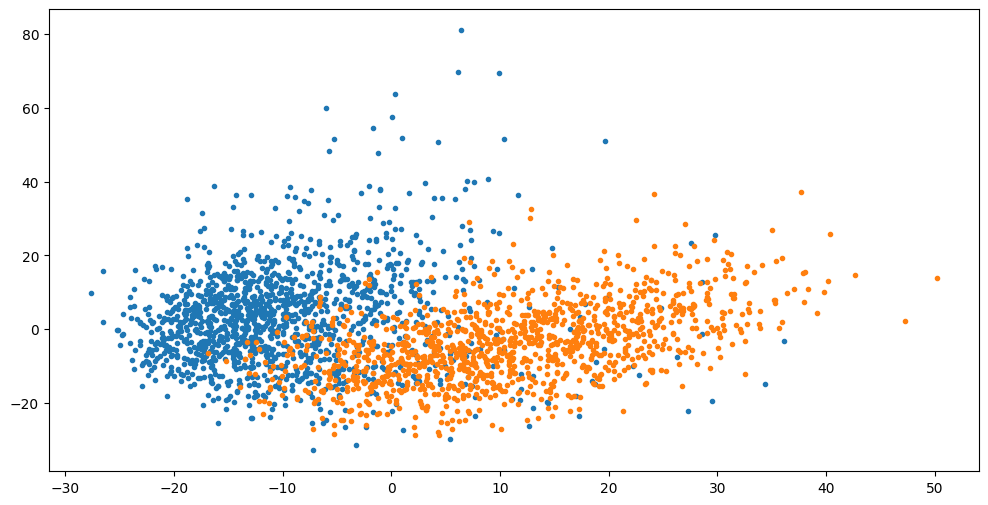

- Agglomerative predictions on PCA_features_pooling_rgb -


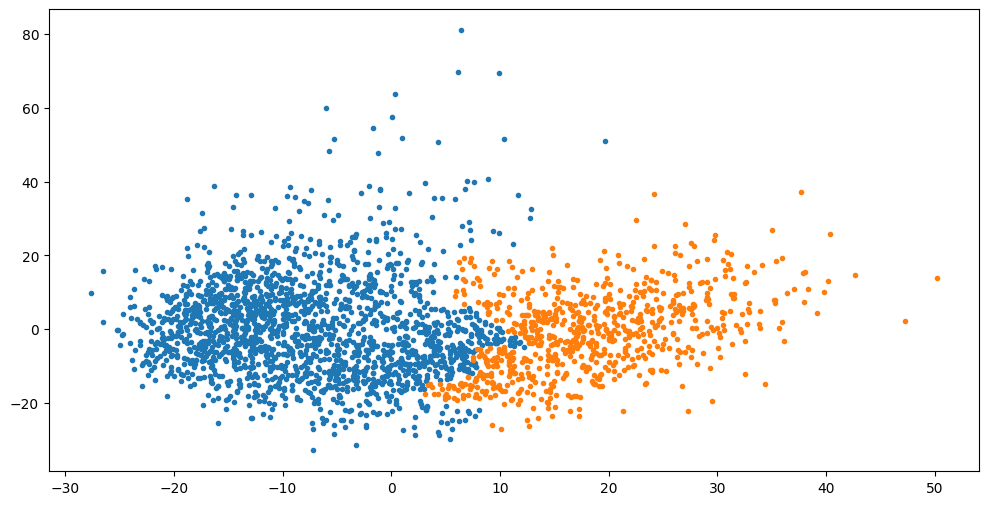

----------------------------------------------------------------------------------------------------


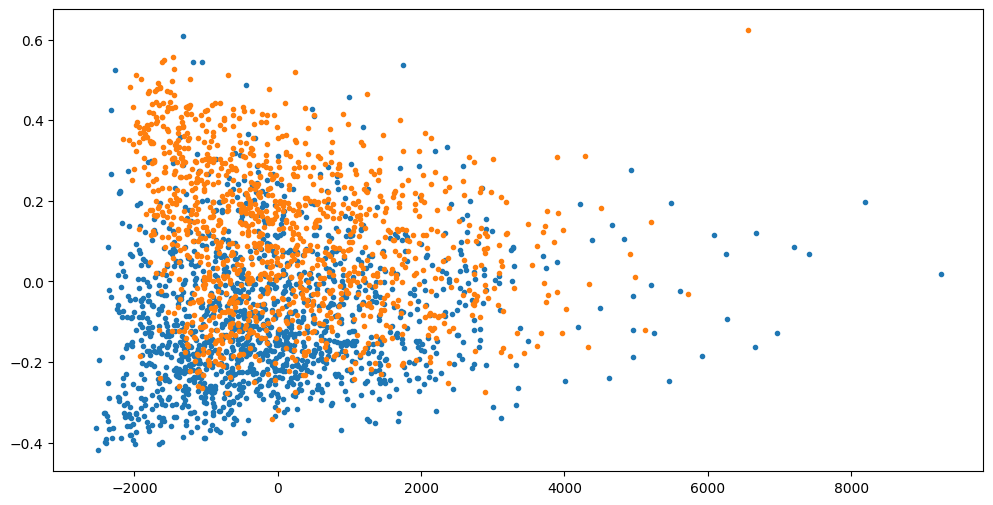

- Agglomerative predictions on PCA_matrix_features -


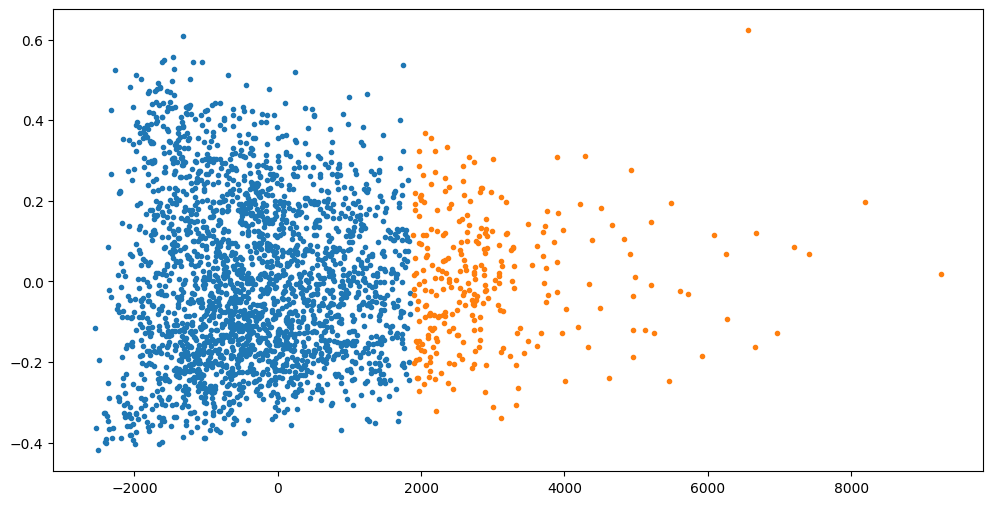

----------------------------------------------------------------------------------------------------


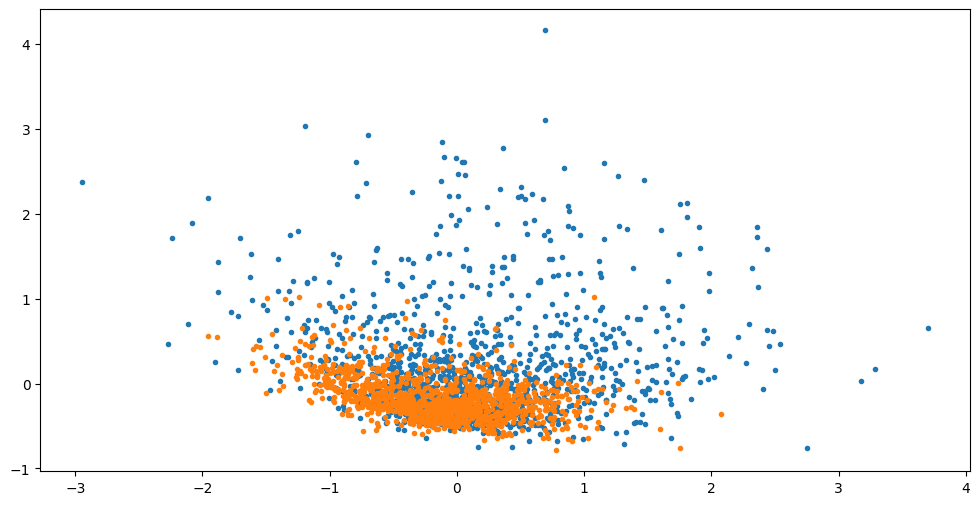

- Agglomerative predictions on PCA_hog_features -


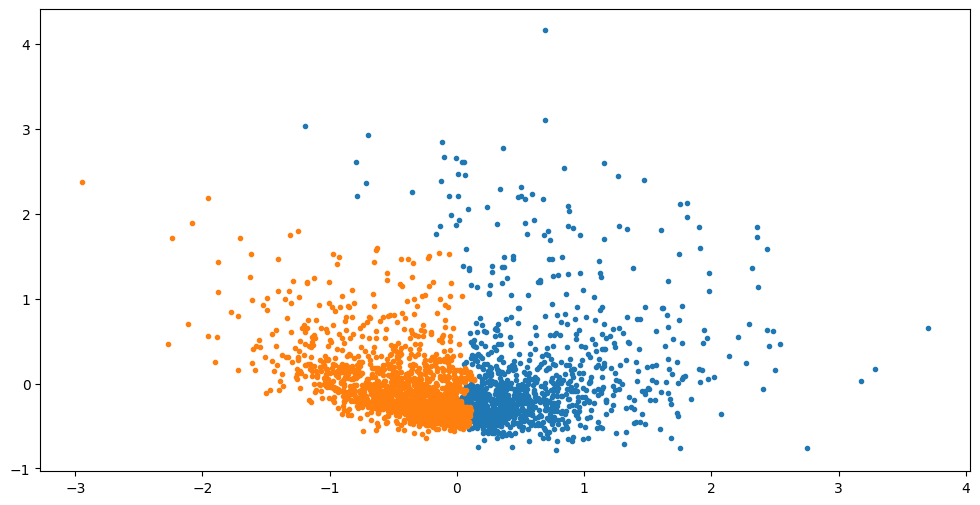

----------------------------------------------------------------------------------------------------


In [146]:
# 2D Plots
labels = np.unique(n_labels)

for algorithm in ("KMeans", "Agglomerative"):
    for data_type, decomposed_data, clustering_predictions, swap in (
        ("PCA_raw_input", PCA_raw_input, predictions["PCA_raw"][0][algorithm][0], swap_list[algorithm][0]),
        ("PCA_raw_input_rgb", PCA_raw_input_rgb, predictions["PCA_raw_rgb"][0][algorithm][0], swap_list[algorithm][1]),
        ("PCA_features", PCA_features, predictions["PCA_features"][0][algorithm][0], swap_list[algorithm][2]),
        ("PCA_features_pooling", PCA_features_pooling, predictions["PCA_features_pooling"][0][algorithm][0], swap_list[algorithm][3]),
        ("PCA_features_rgb", PCA_features_rgb, predictions["PCA_features_rgb"][0][algorithm][0], swap_list[algorithm][4]),
        ("PCA_features_pooling_rgb", PCA_features_pooling_rgb, predictions["PCA_features_pooling_rgb"][0][algorithm][0], swap_list[algorithm][5]),
        ("PCA_matrix_features", PCA_matrix_features, predictions["PCA_matrix_features"][0][algorithm][0], swap_list[algorithm][6]),
        ("PCA_hog_features", PCA_hog_features, predictions["PCA_hog_features"][0][algorithm][0], swap_list[algorithm][7])):


        plt.figure(figsize=(12,6))
        for l in labels:
            plt.scatter(decomposed_data[np.squeeze(n_labels == l), 0], decomposed_data[np.squeeze(n_labels == l), 1], label = l, marker = ".")
        plt.show()

        print(f"- {algorithm} predictions on {data_type} -")
        if swap:
            plt.figure(figsize=(12,6))
            for l in labels:
                plt.scatter(decomposed_data[clustering_predictions == 1-l, 0], decomposed_data[clustering_predictions == 1-l, 1], label = l, marker =".")
            plt.show() 
        else:
            plt.figure(figsize=(12,6))
            for l in labels:
                plt.scatter(decomposed_data[clustering_predictions == l, 0], decomposed_data[clustering_predictions == l, 1], label = l, marker =".")
            plt.show()

        print("-"*100)

In [147]:
results_ex_clusteringDF_KMeans = pd.DataFrame(clustering_ex_results_KMeans)
results_ex_clusteringDF_Agglomerative = pd.DataFrame(clustering_ex_results_Agglomerative)

results_in_clusteringDF_KMeans = pd.DataFrame(clustering_in_results_KMeans)
results_in_clusteringDF_Agglomerative = pd.DataFrame(clustering_in_results_Agglomerative)

[(<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'AUROC'}, xlabel='AUROC'>], dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'Accuracy'}, xlabel='Accuracy'>],
        dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'AUPRC'}, xlabel='AUPRC'>], dtype=object))]

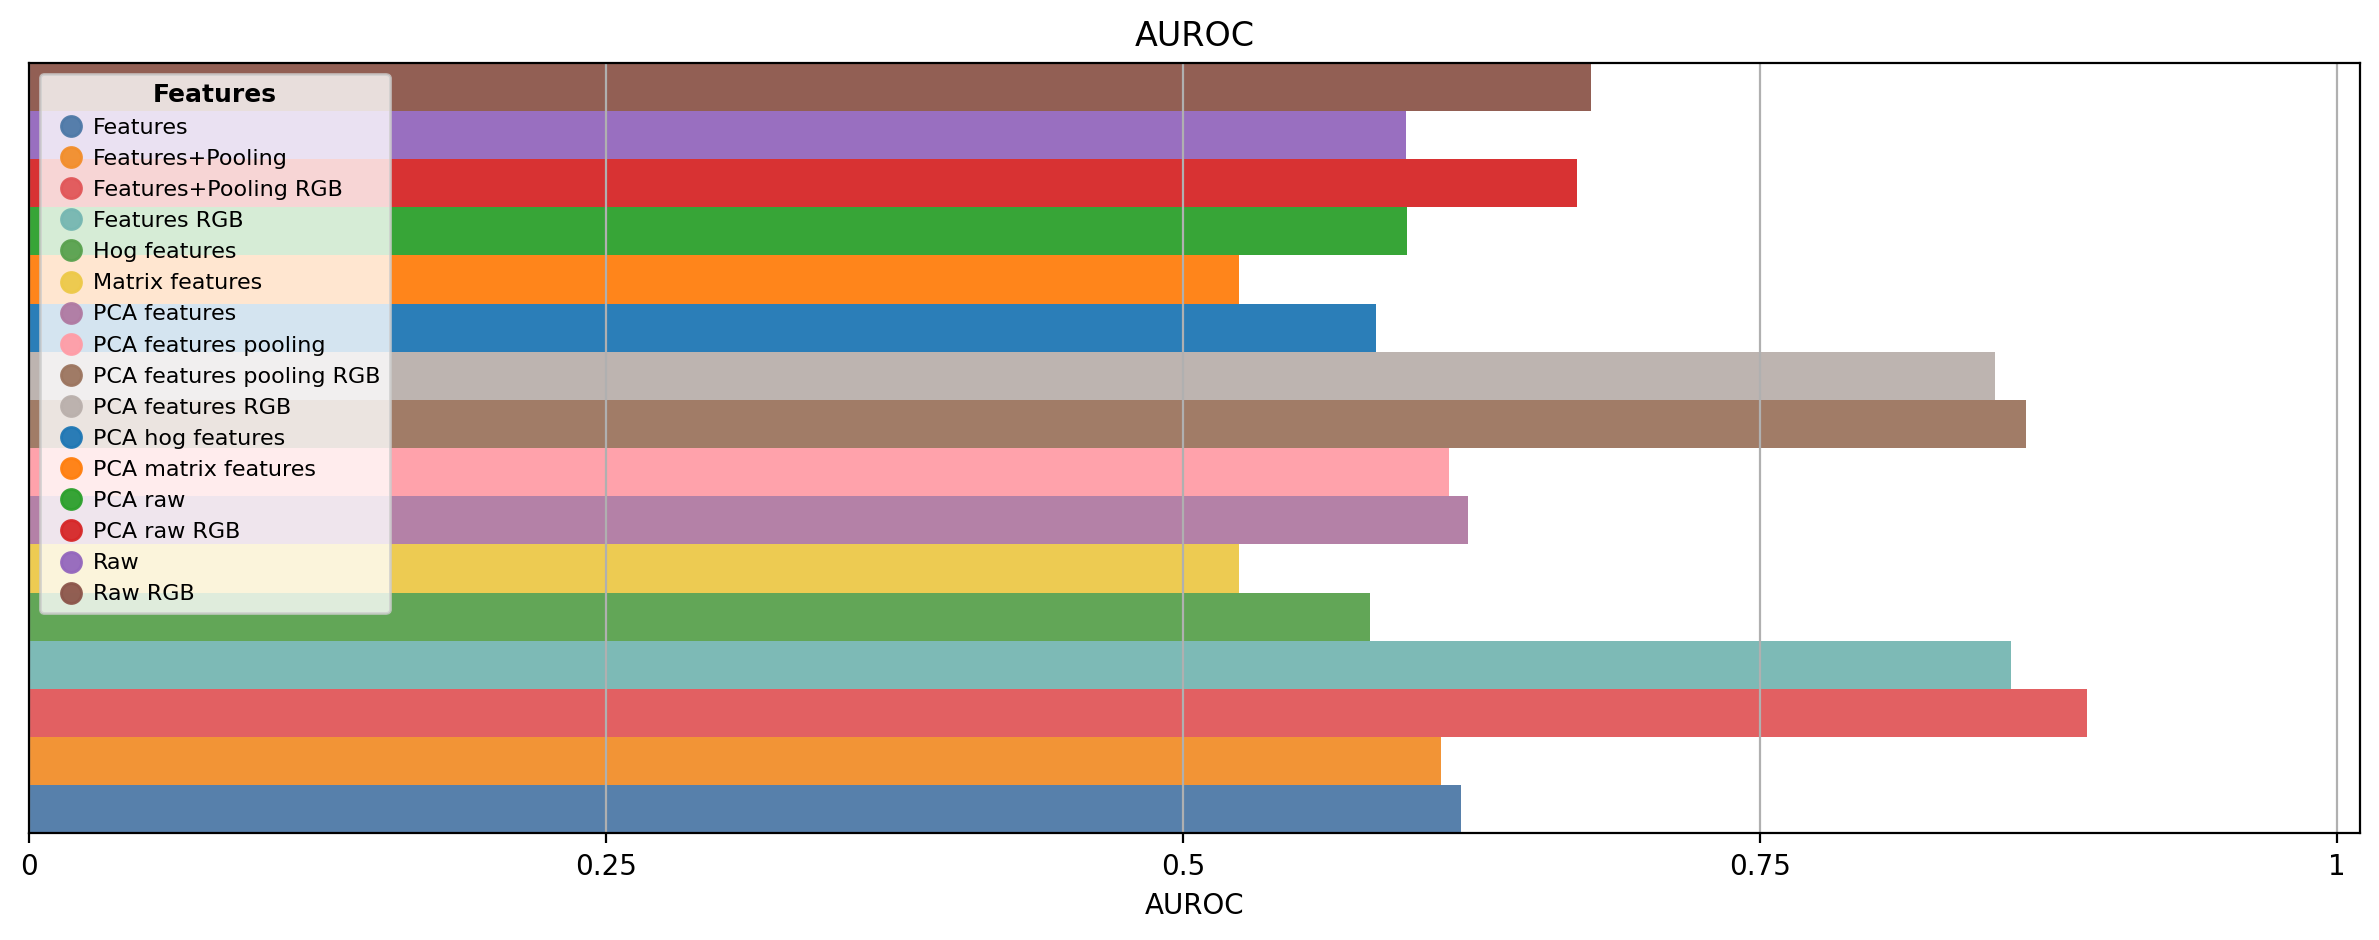

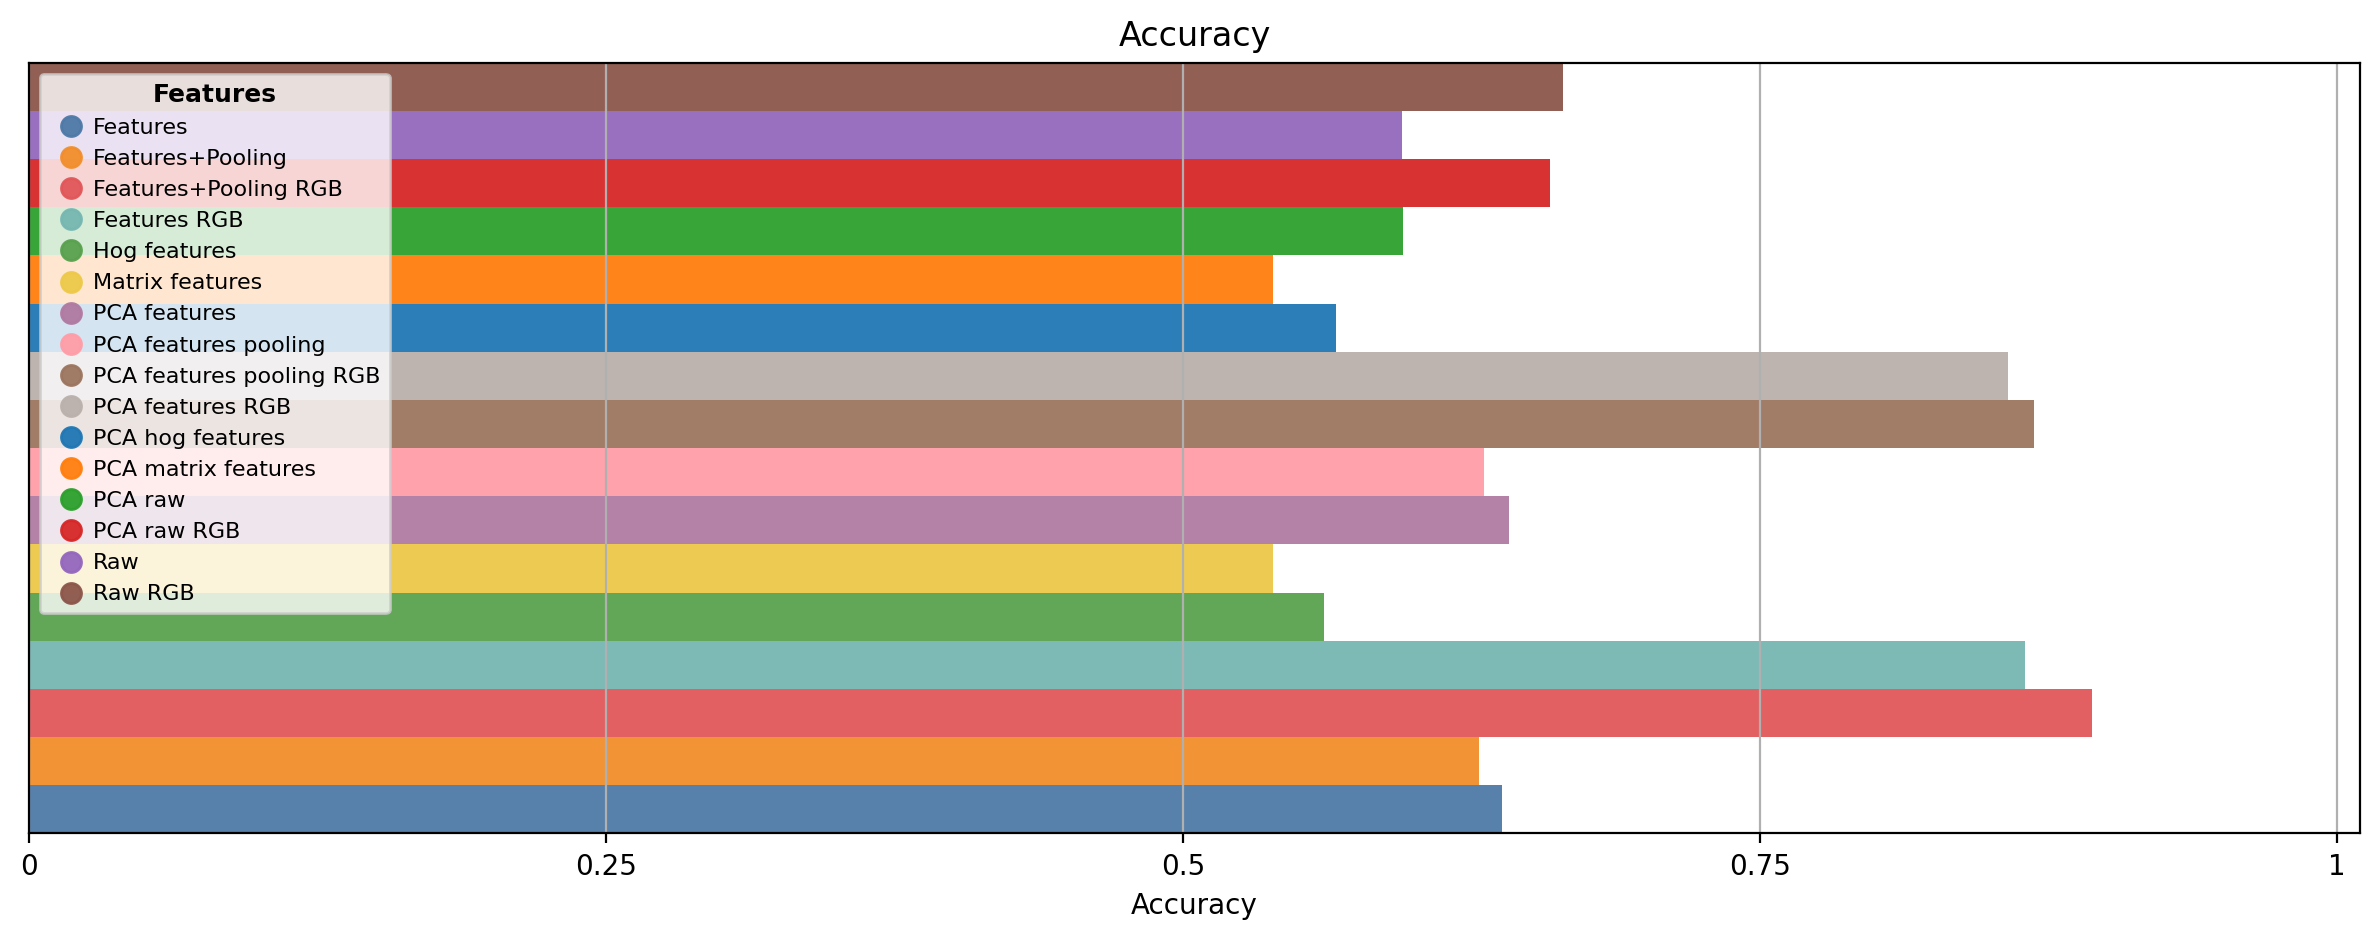

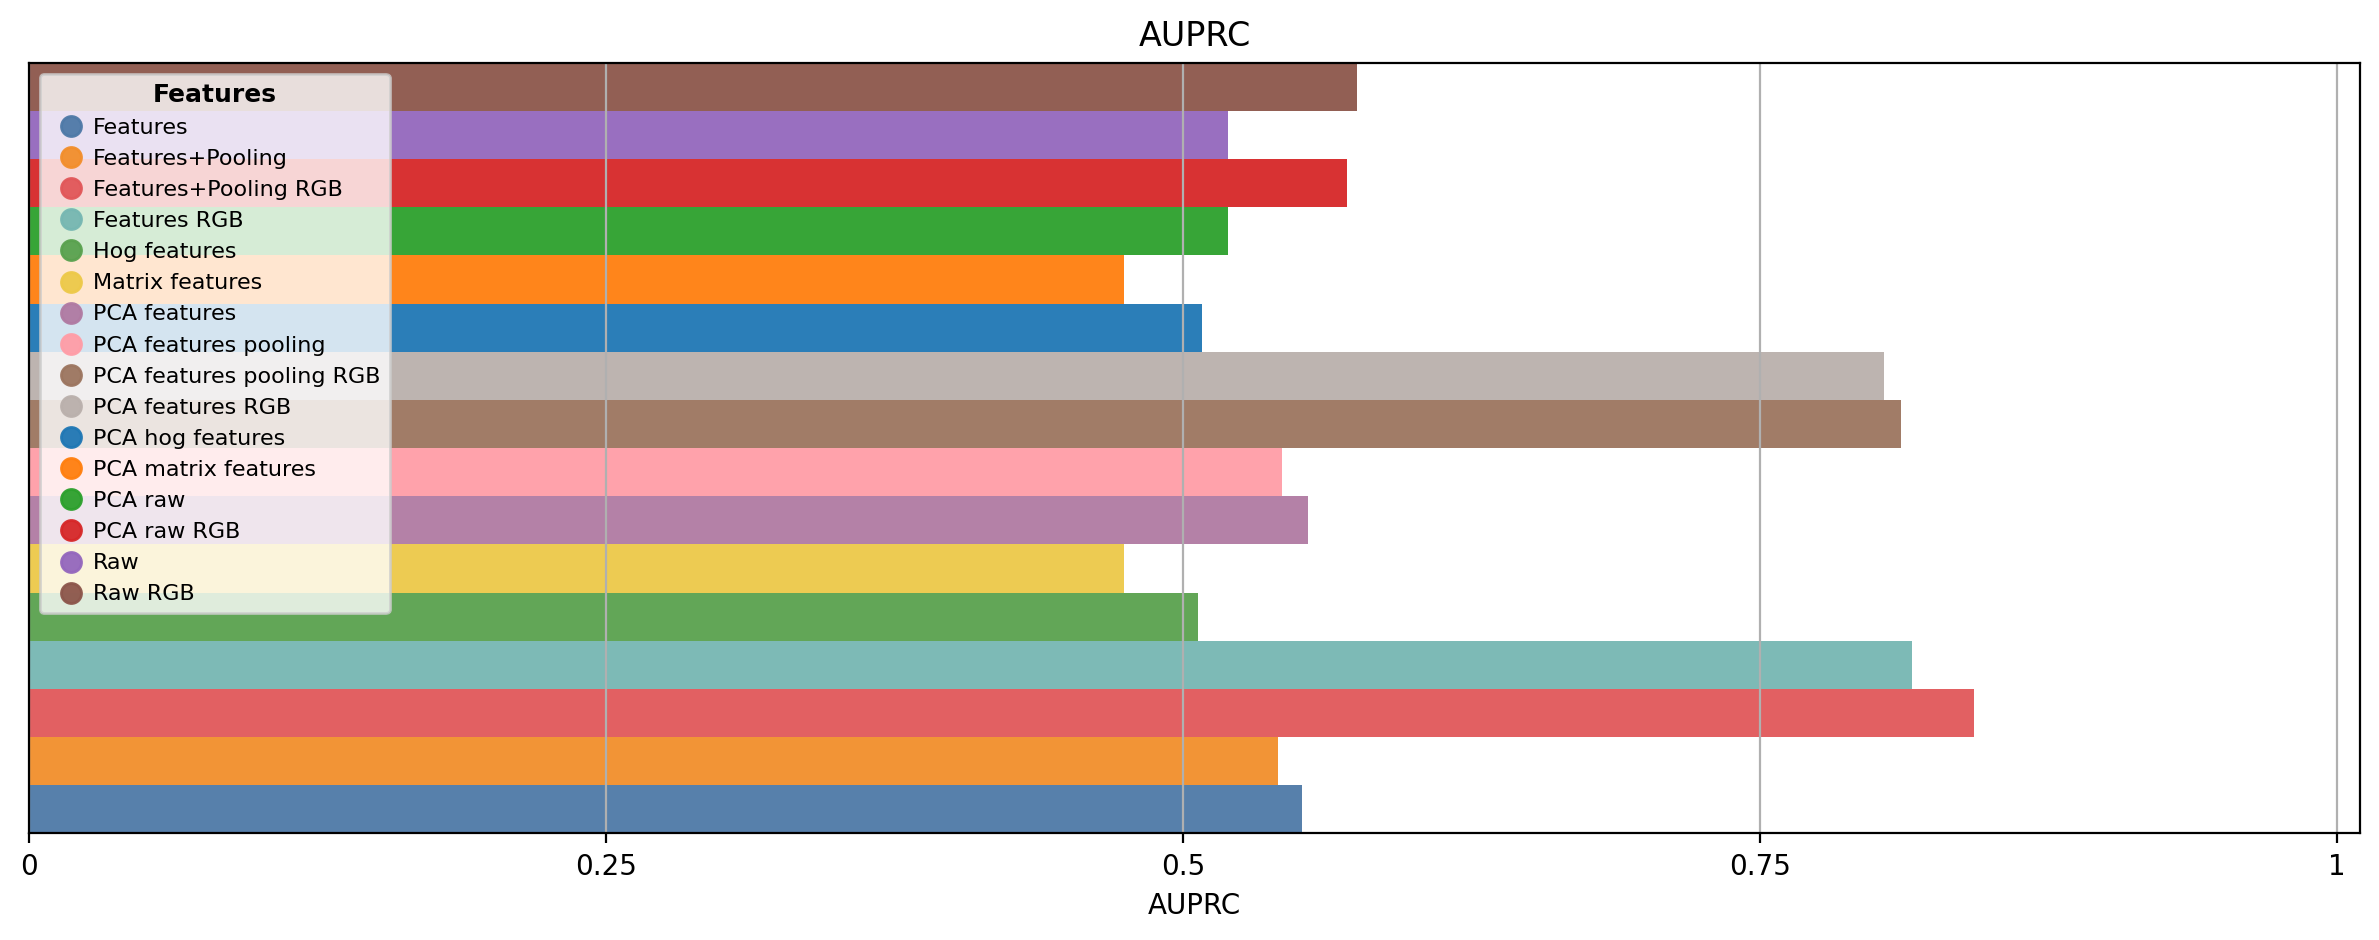

In [148]:
from barplots import barplots

barplots(
    results_ex_clusteringDF_KMeans,
    groupby=["features"],
    orientation="horizontal",
    height=12,
    legend_position="upper left"
)

[(<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'AUROC'}, xlabel='AUROC'>], dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'Accuracy'}, xlabel='Accuracy'>],
        dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'AUPRC'}, xlabel='AUPRC'>], dtype=object))]

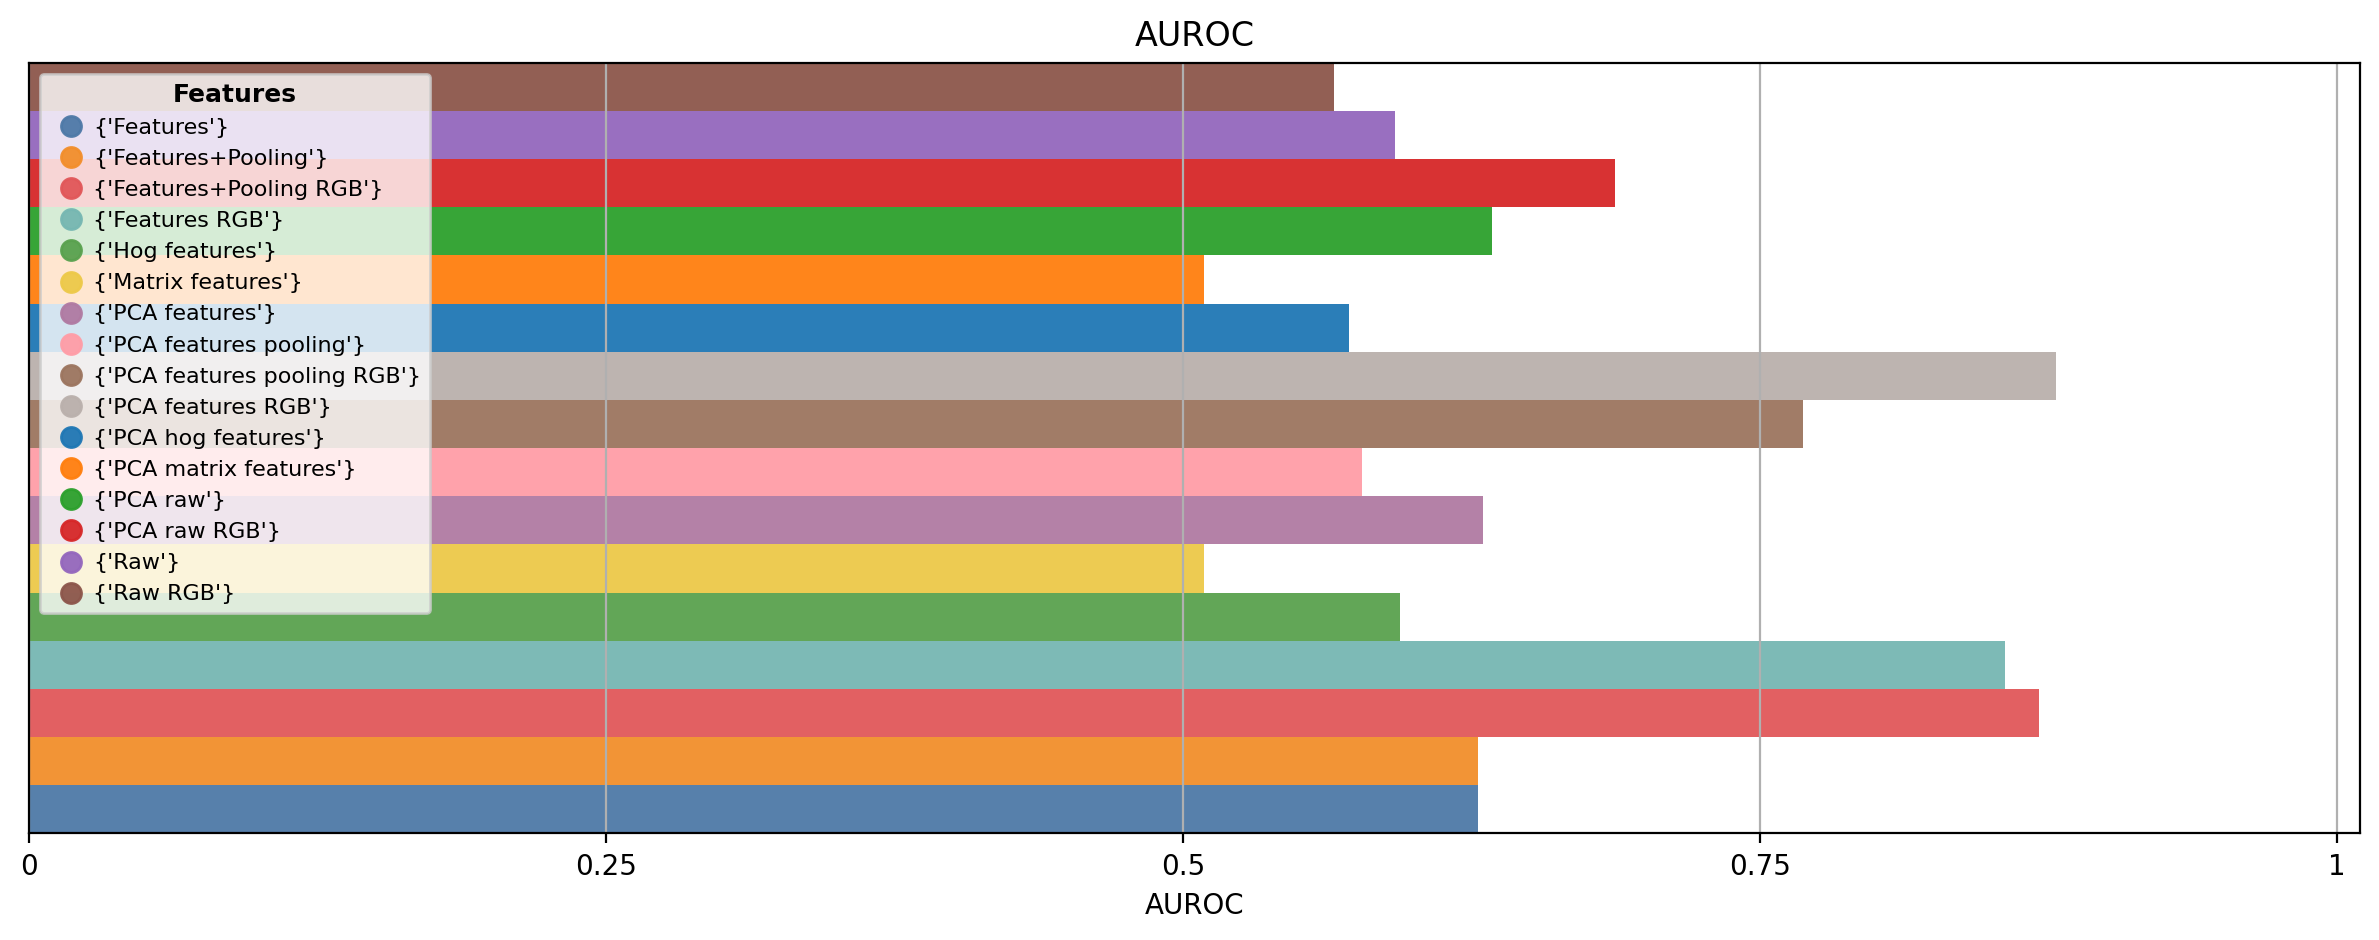

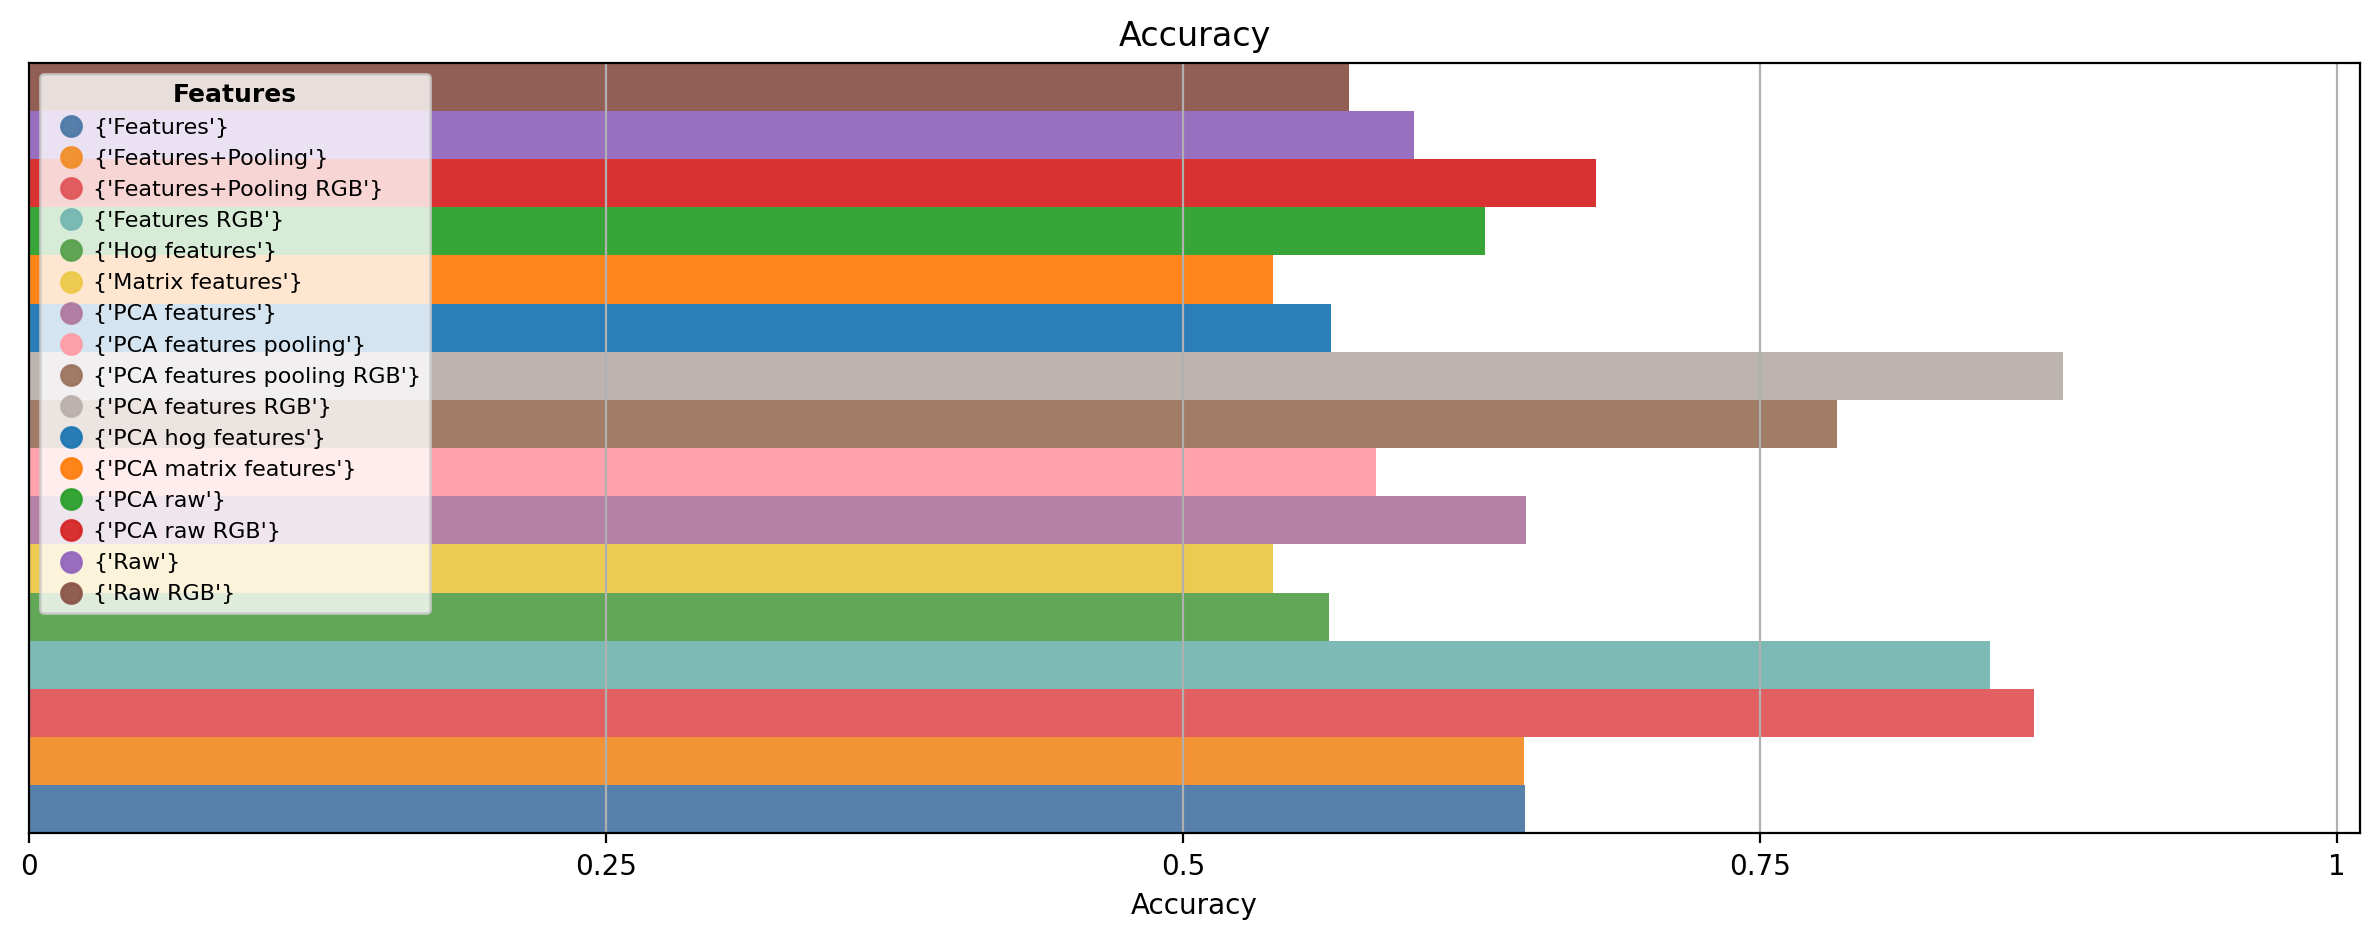

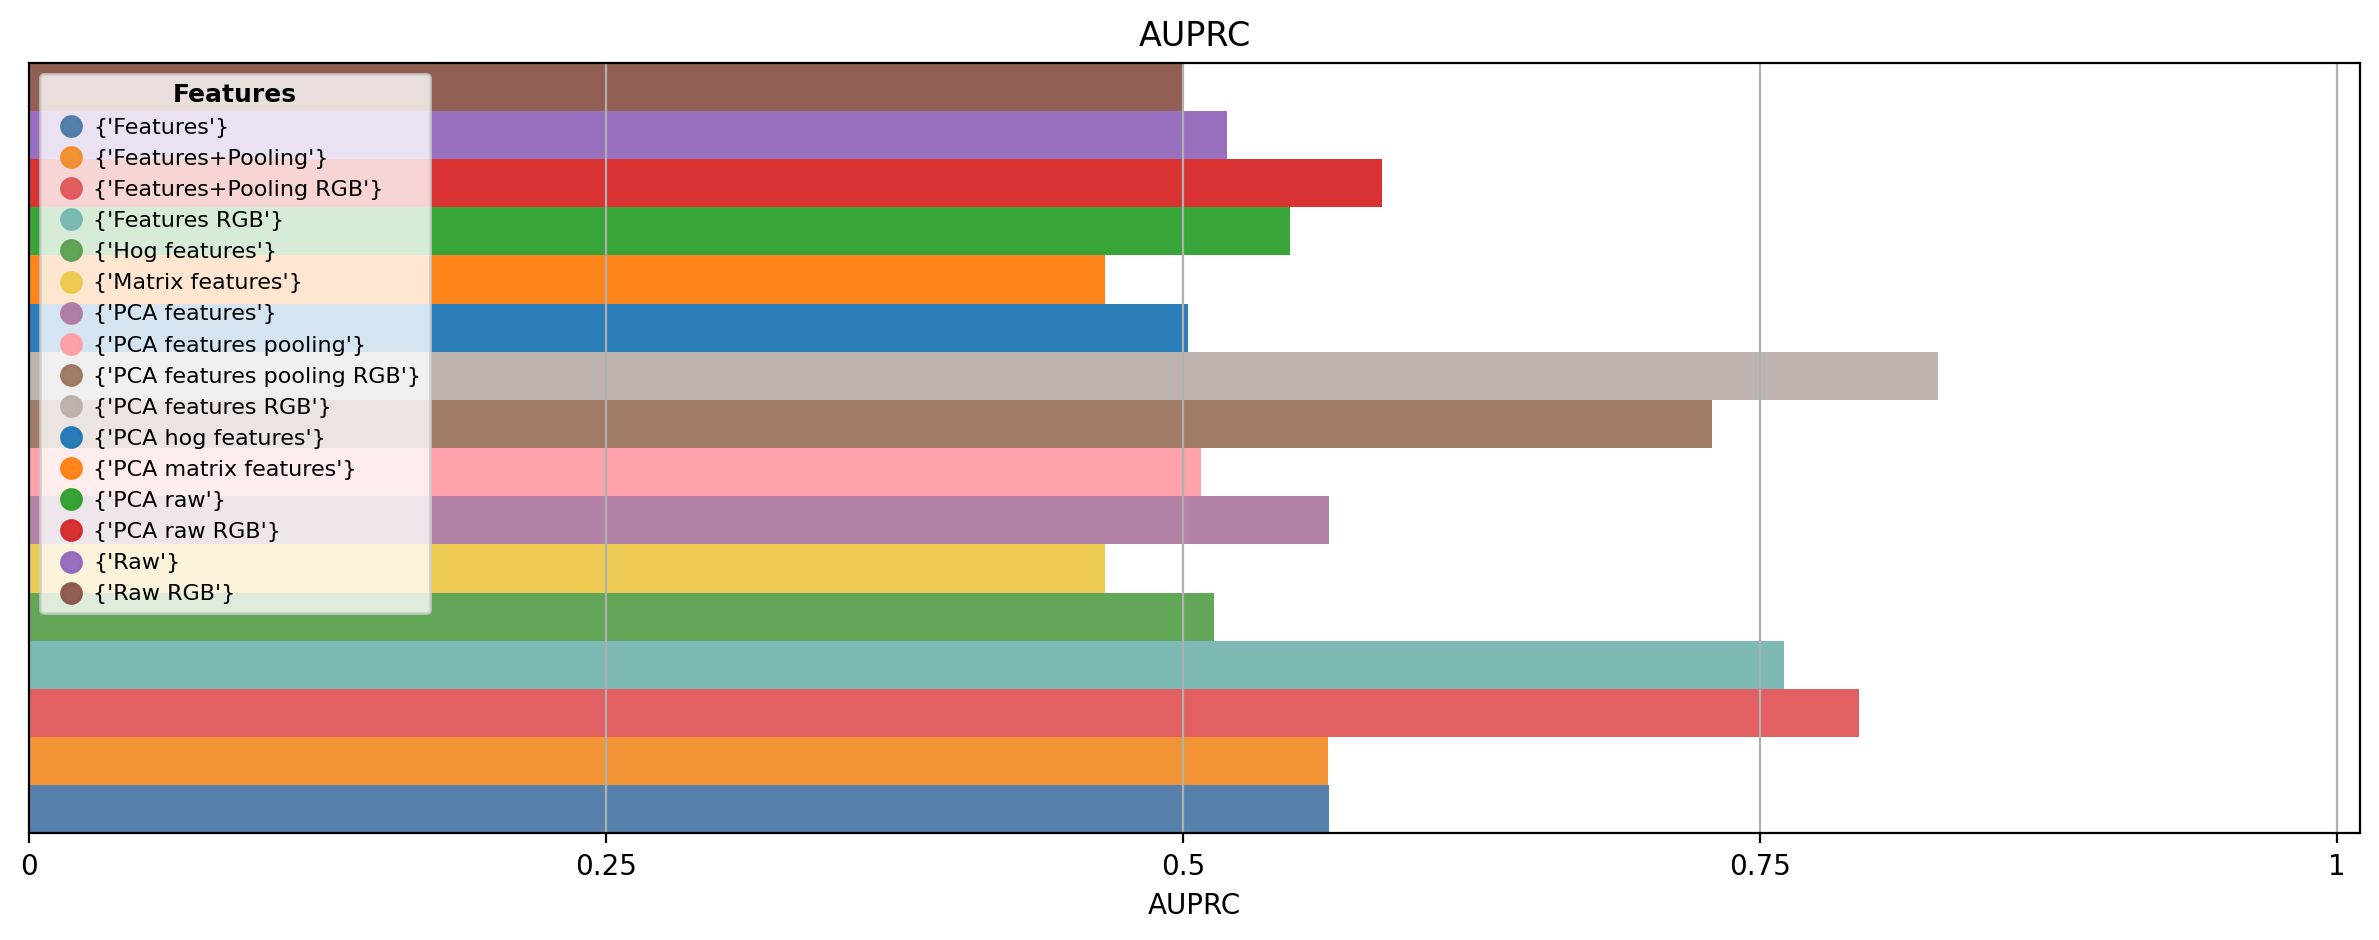

In [149]:
from barplots import barplots

barplots(
    results_ex_clusteringDF_Agglomerative,
    groupby=["features"],
    orientation="horizontal",
    height=12,
    legend_position="upper left"
)

[(<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'MSE'}, xlabel='MSE'>], dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'Silhouette'}, xlabel='Silhouette'>],
        dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'Ars'}, xlabel='Ars'>], dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'Mif'}, xlabel='Mif'>], dtype=object))]

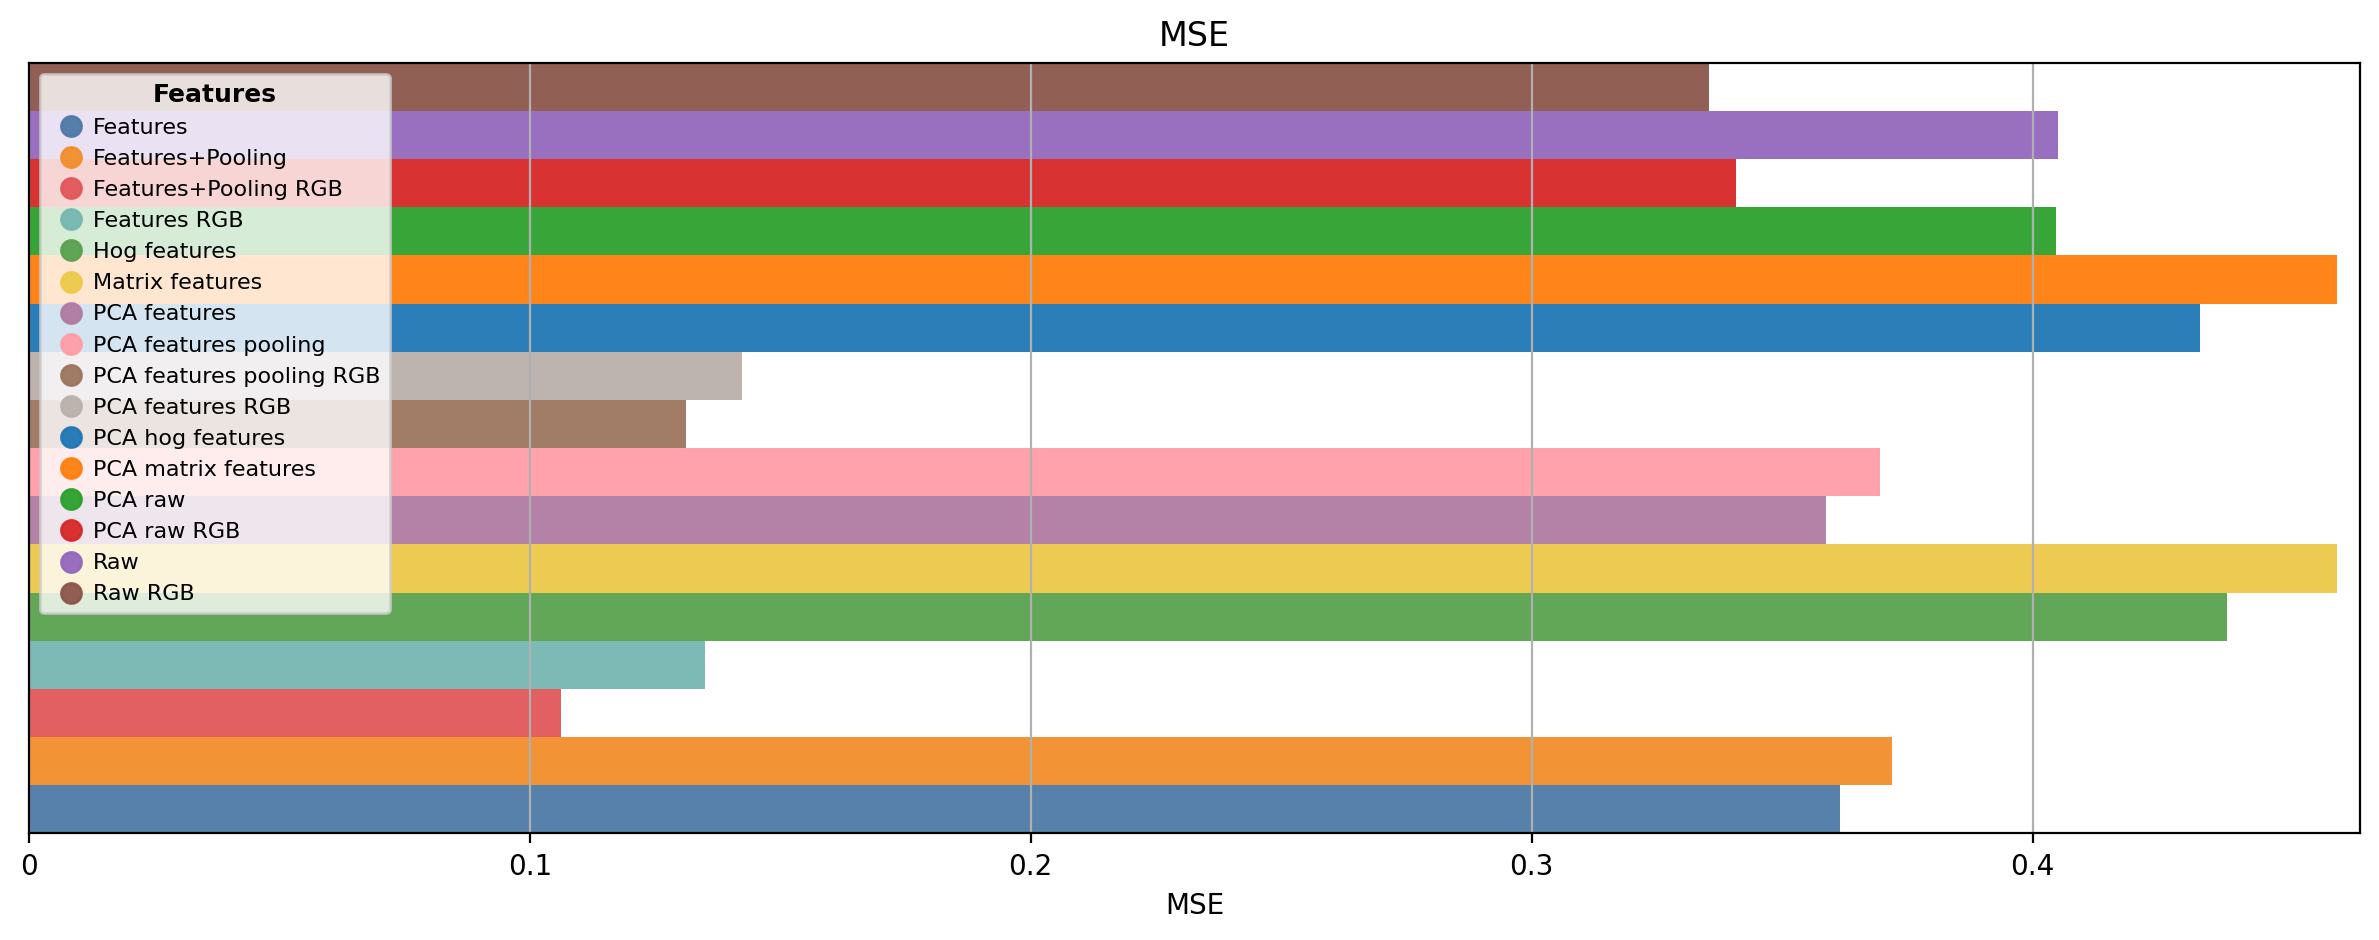

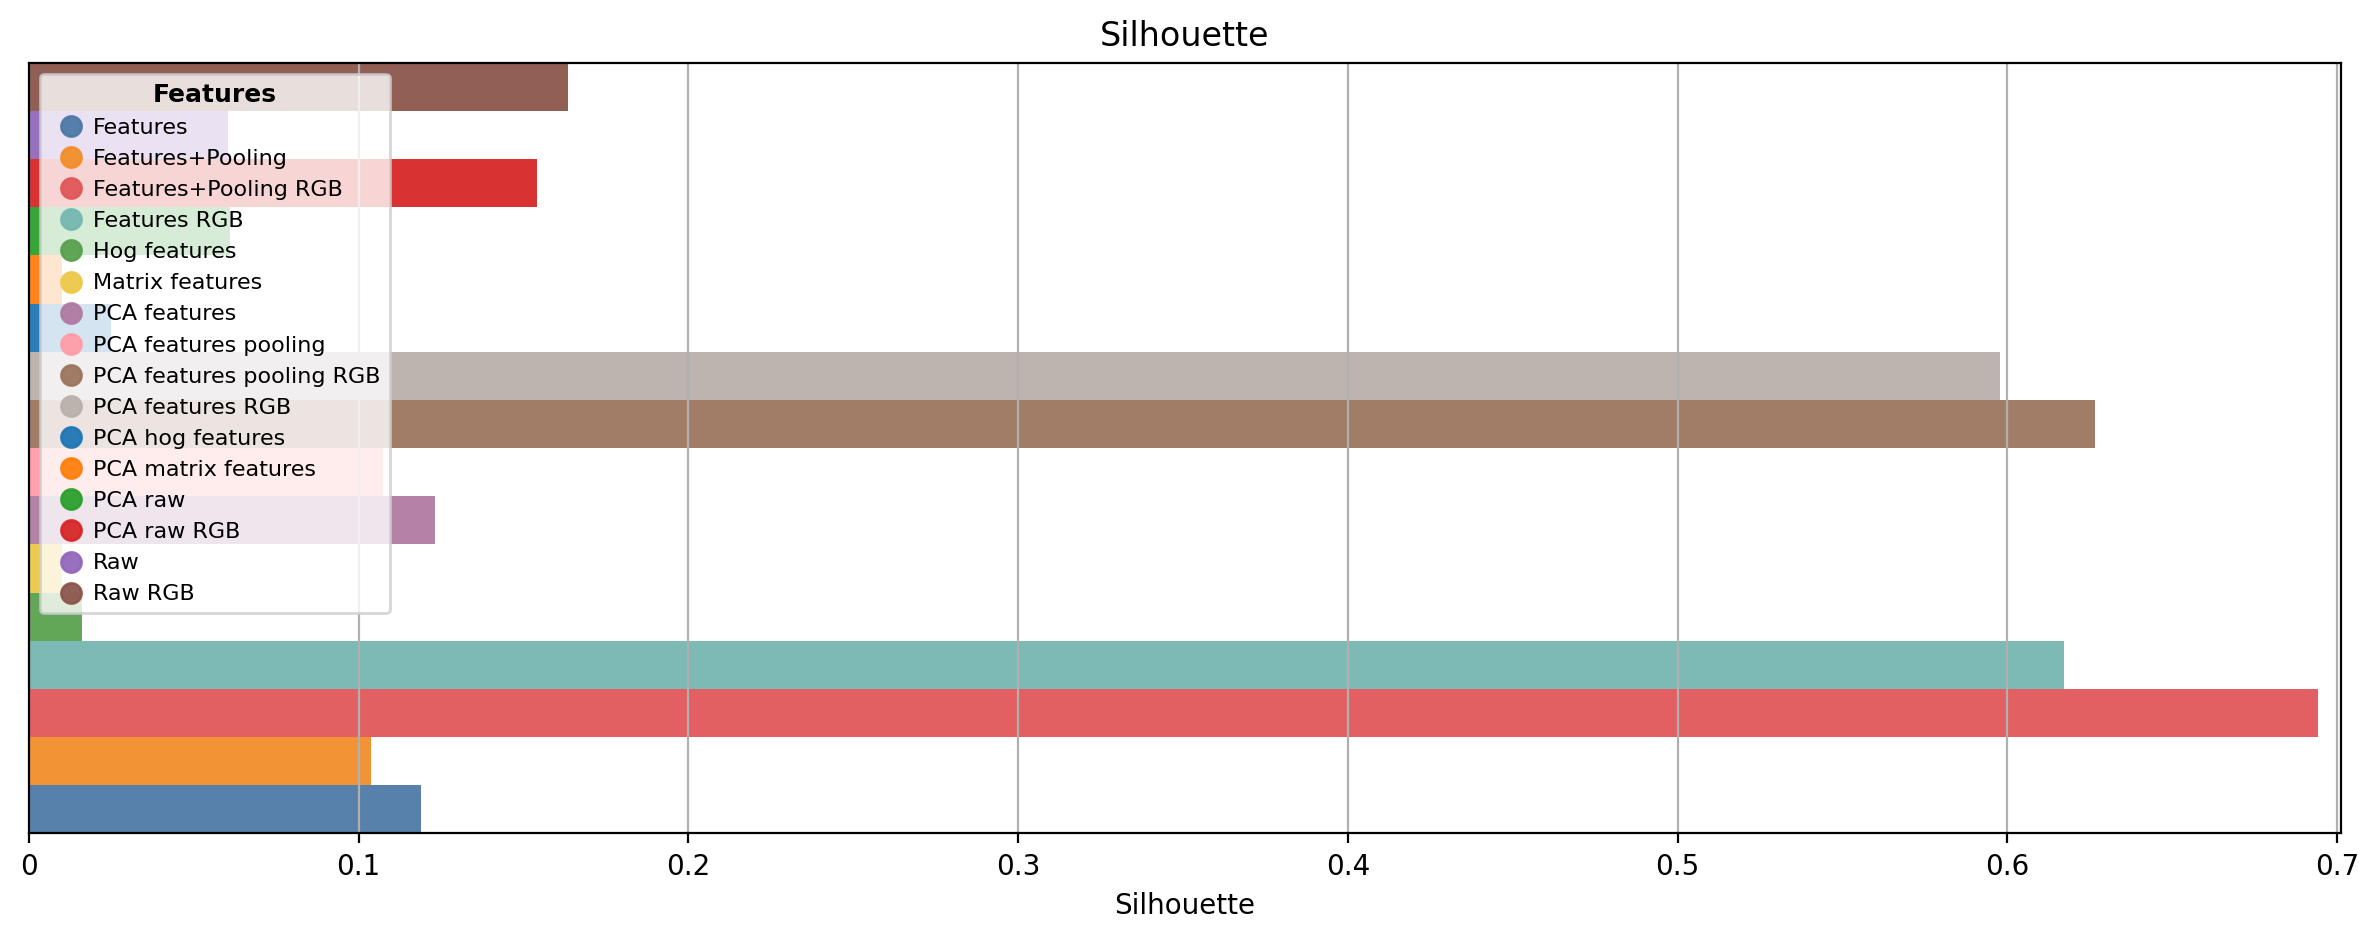

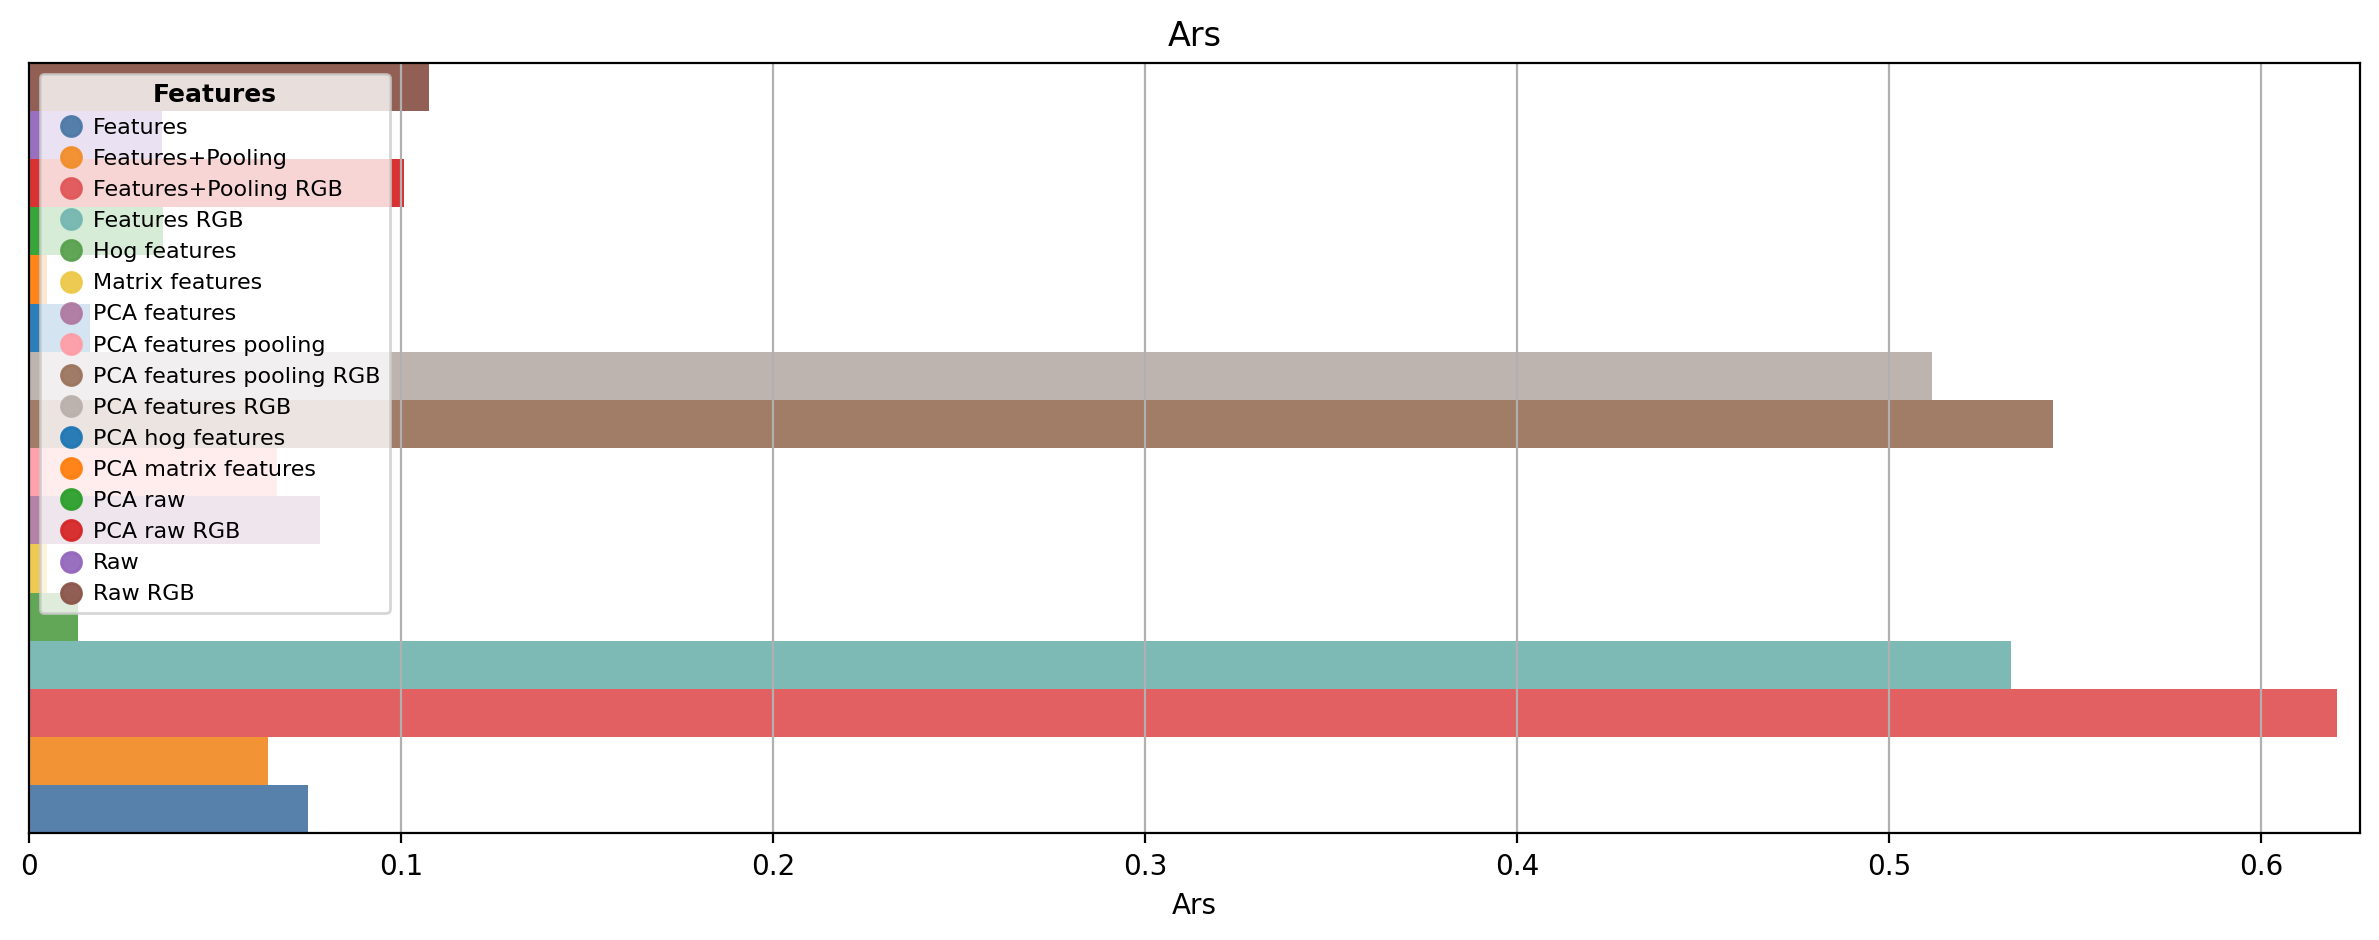

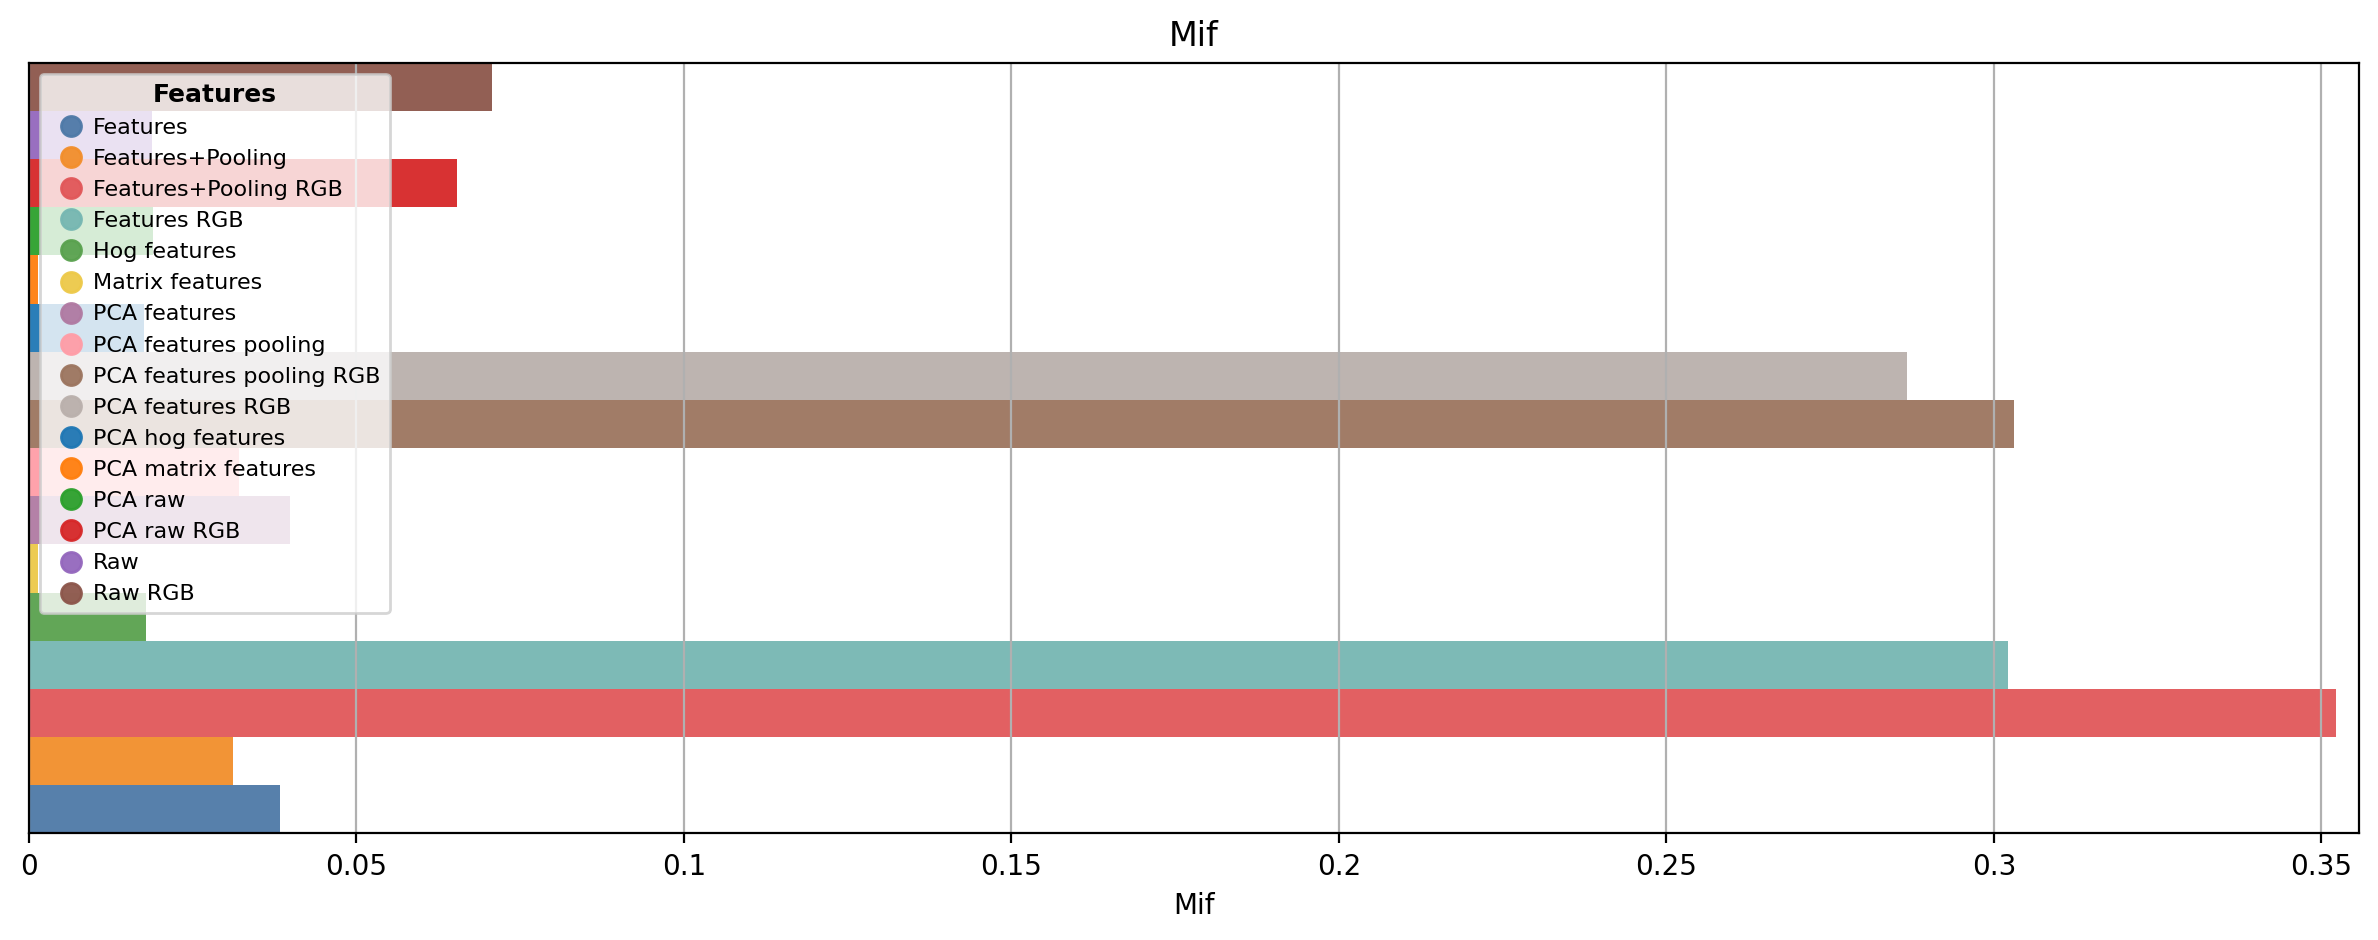

In [150]:
from barplots import barplots

barplots(
    results_in_clusteringDF_KMeans,
    groupby=["features"],
    orientation="horizontal",
    height=12,
    legend_position="upper left"
)

[(<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'MSE'}, xlabel='MSE'>], dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'Silhouette'}, xlabel='Silhouette'>],
        dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'Ars'}, xlabel='Ars'>], dtype=object)),
 (<Figure size 2400x960 with 1 Axes>,
  array([<Axes: title={'center': 'Mif'}, xlabel='Mif'>], dtype=object))]

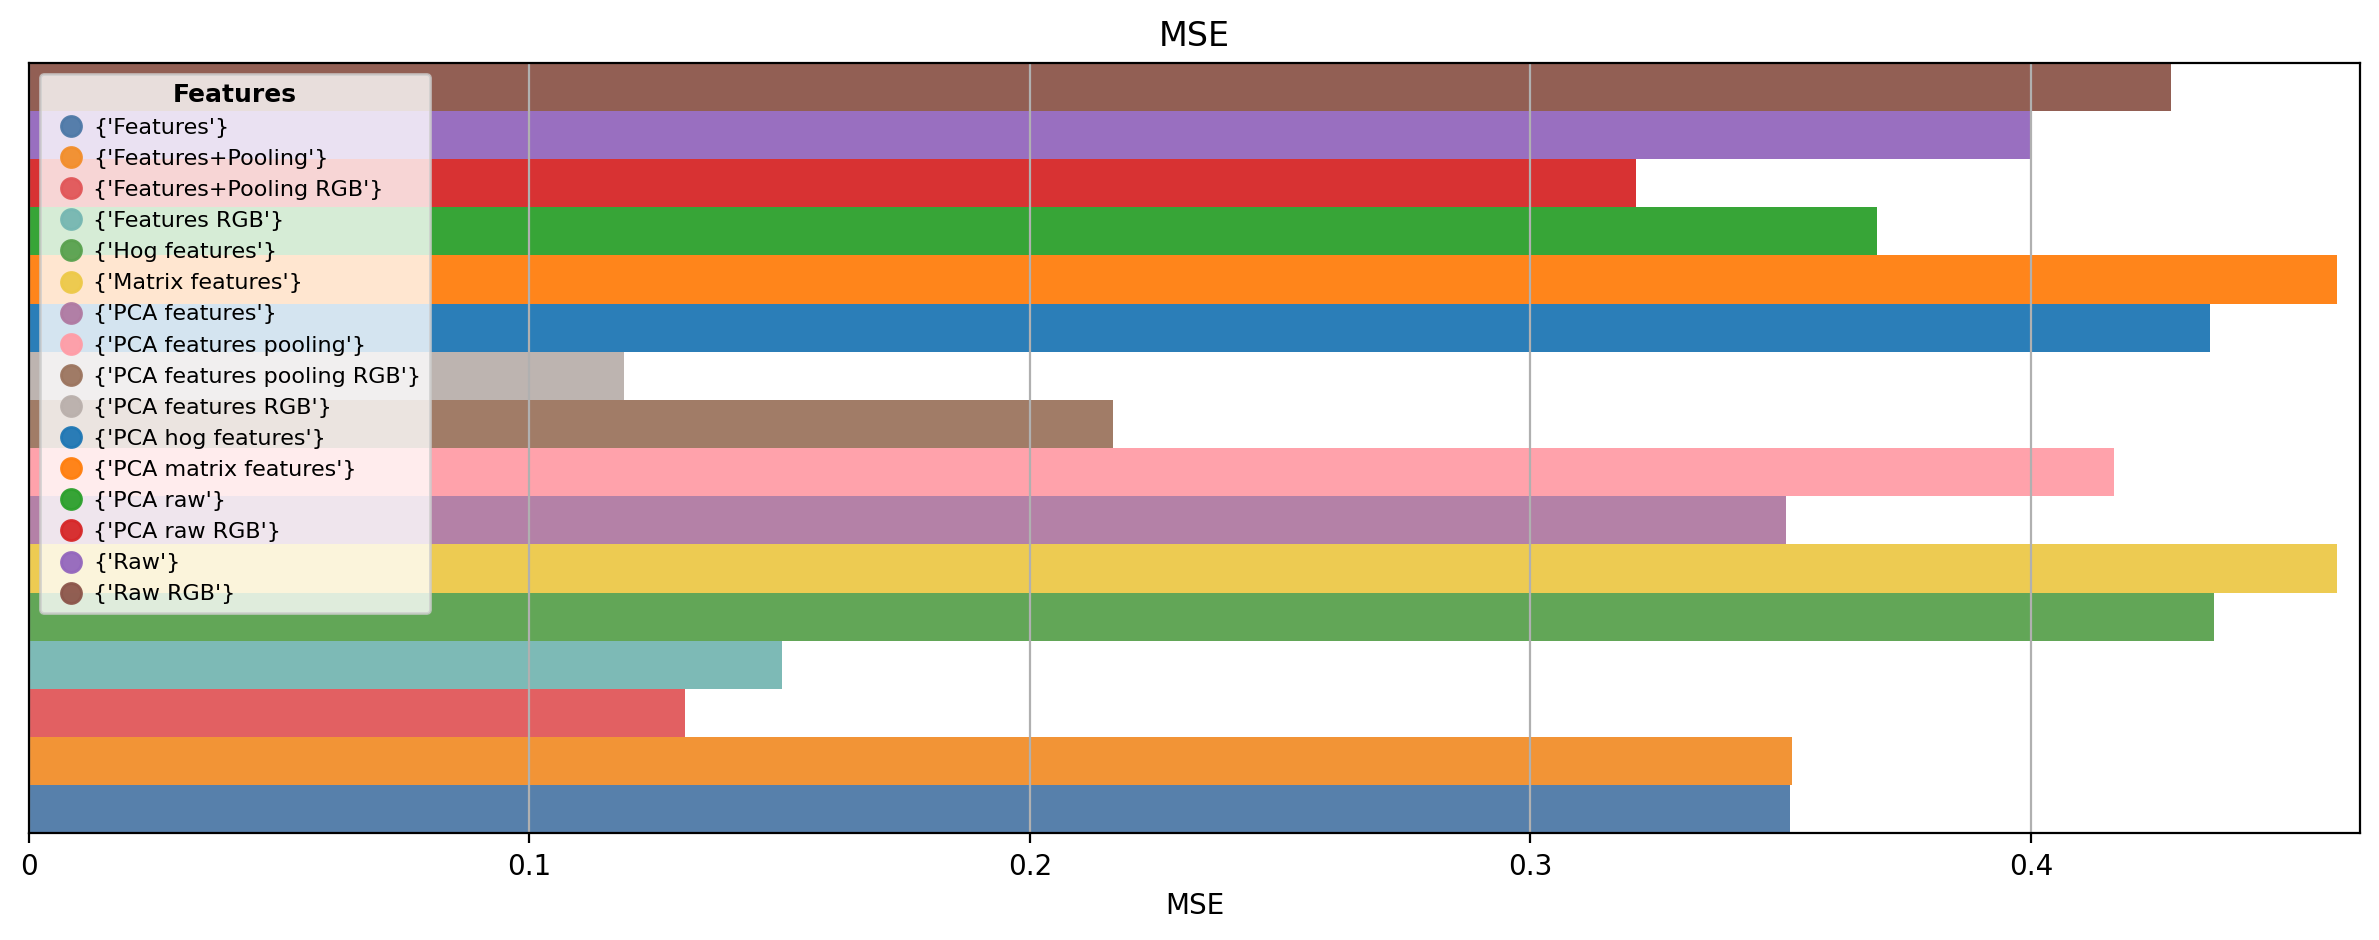

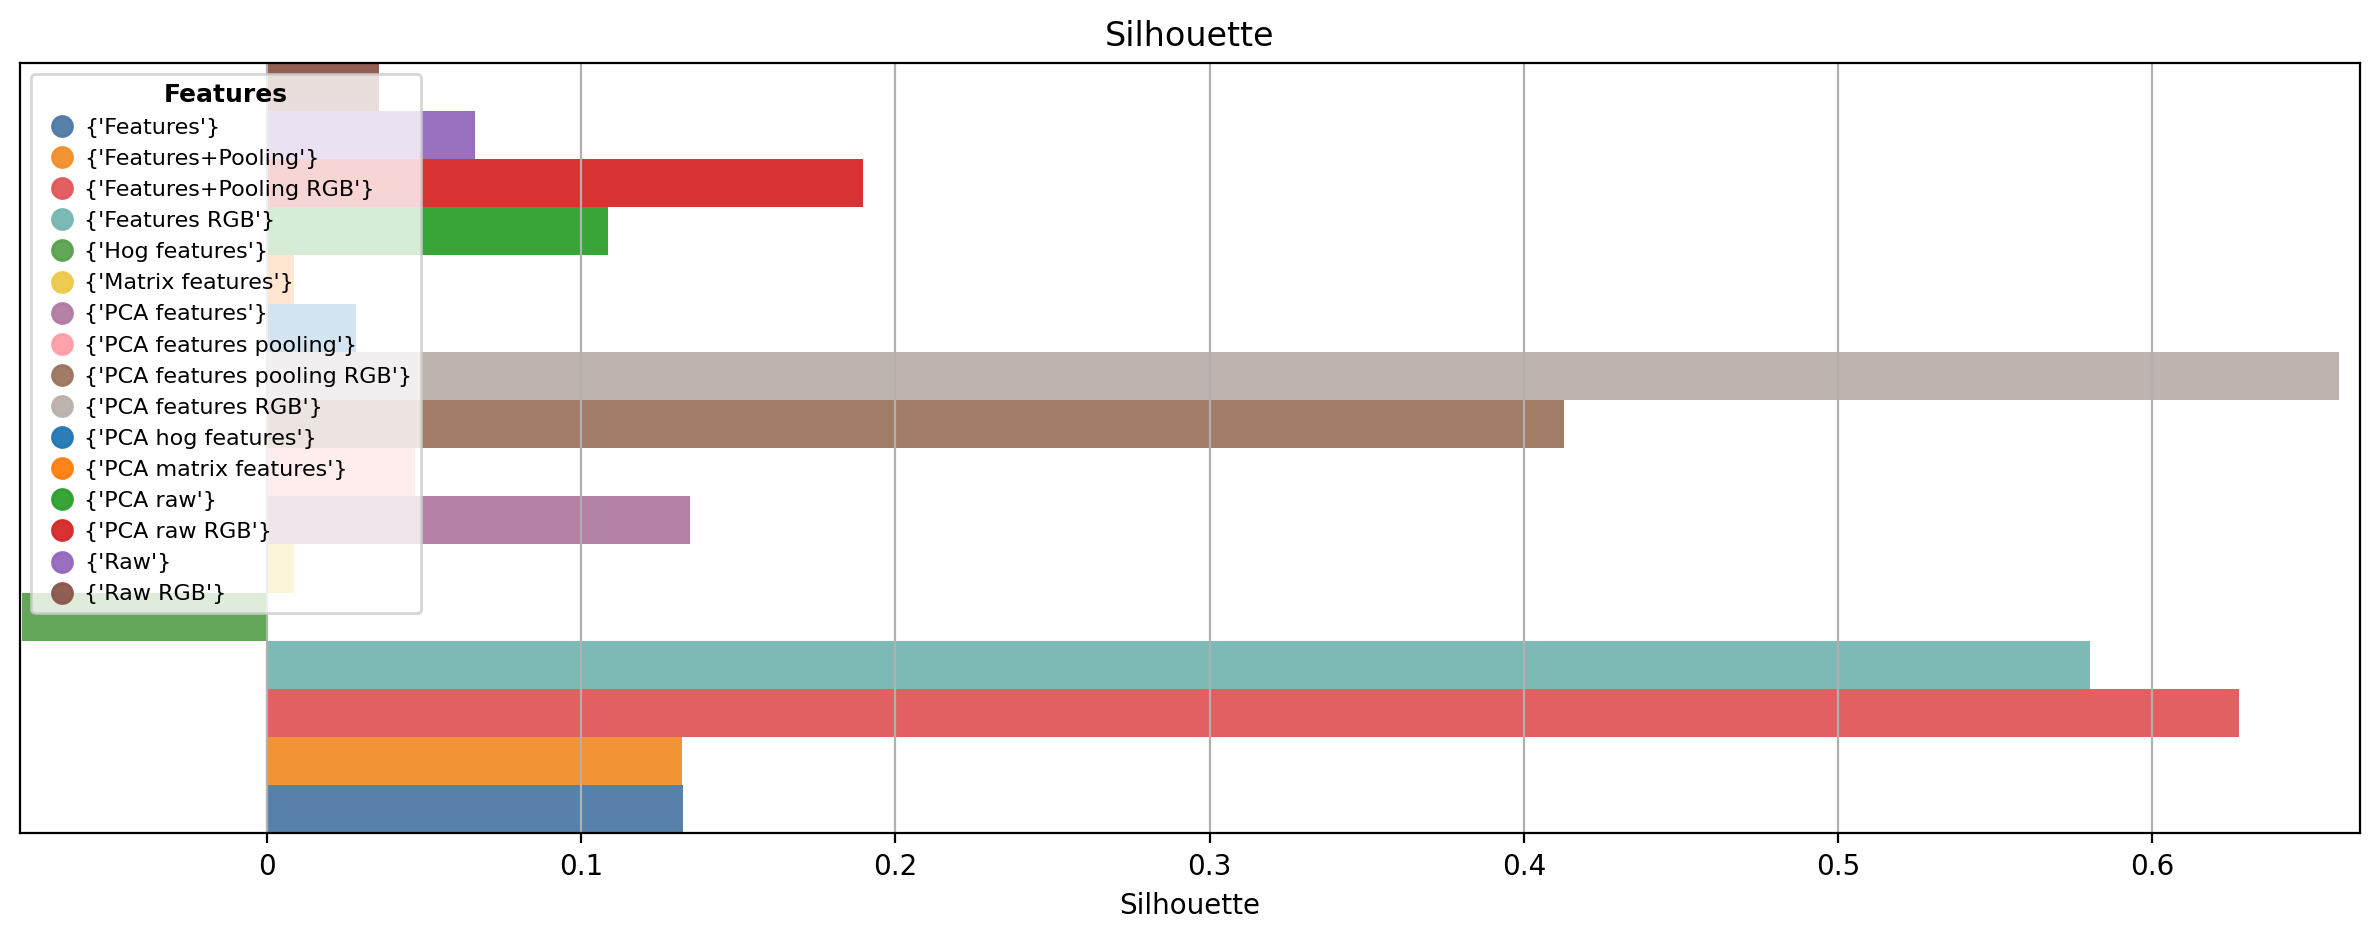

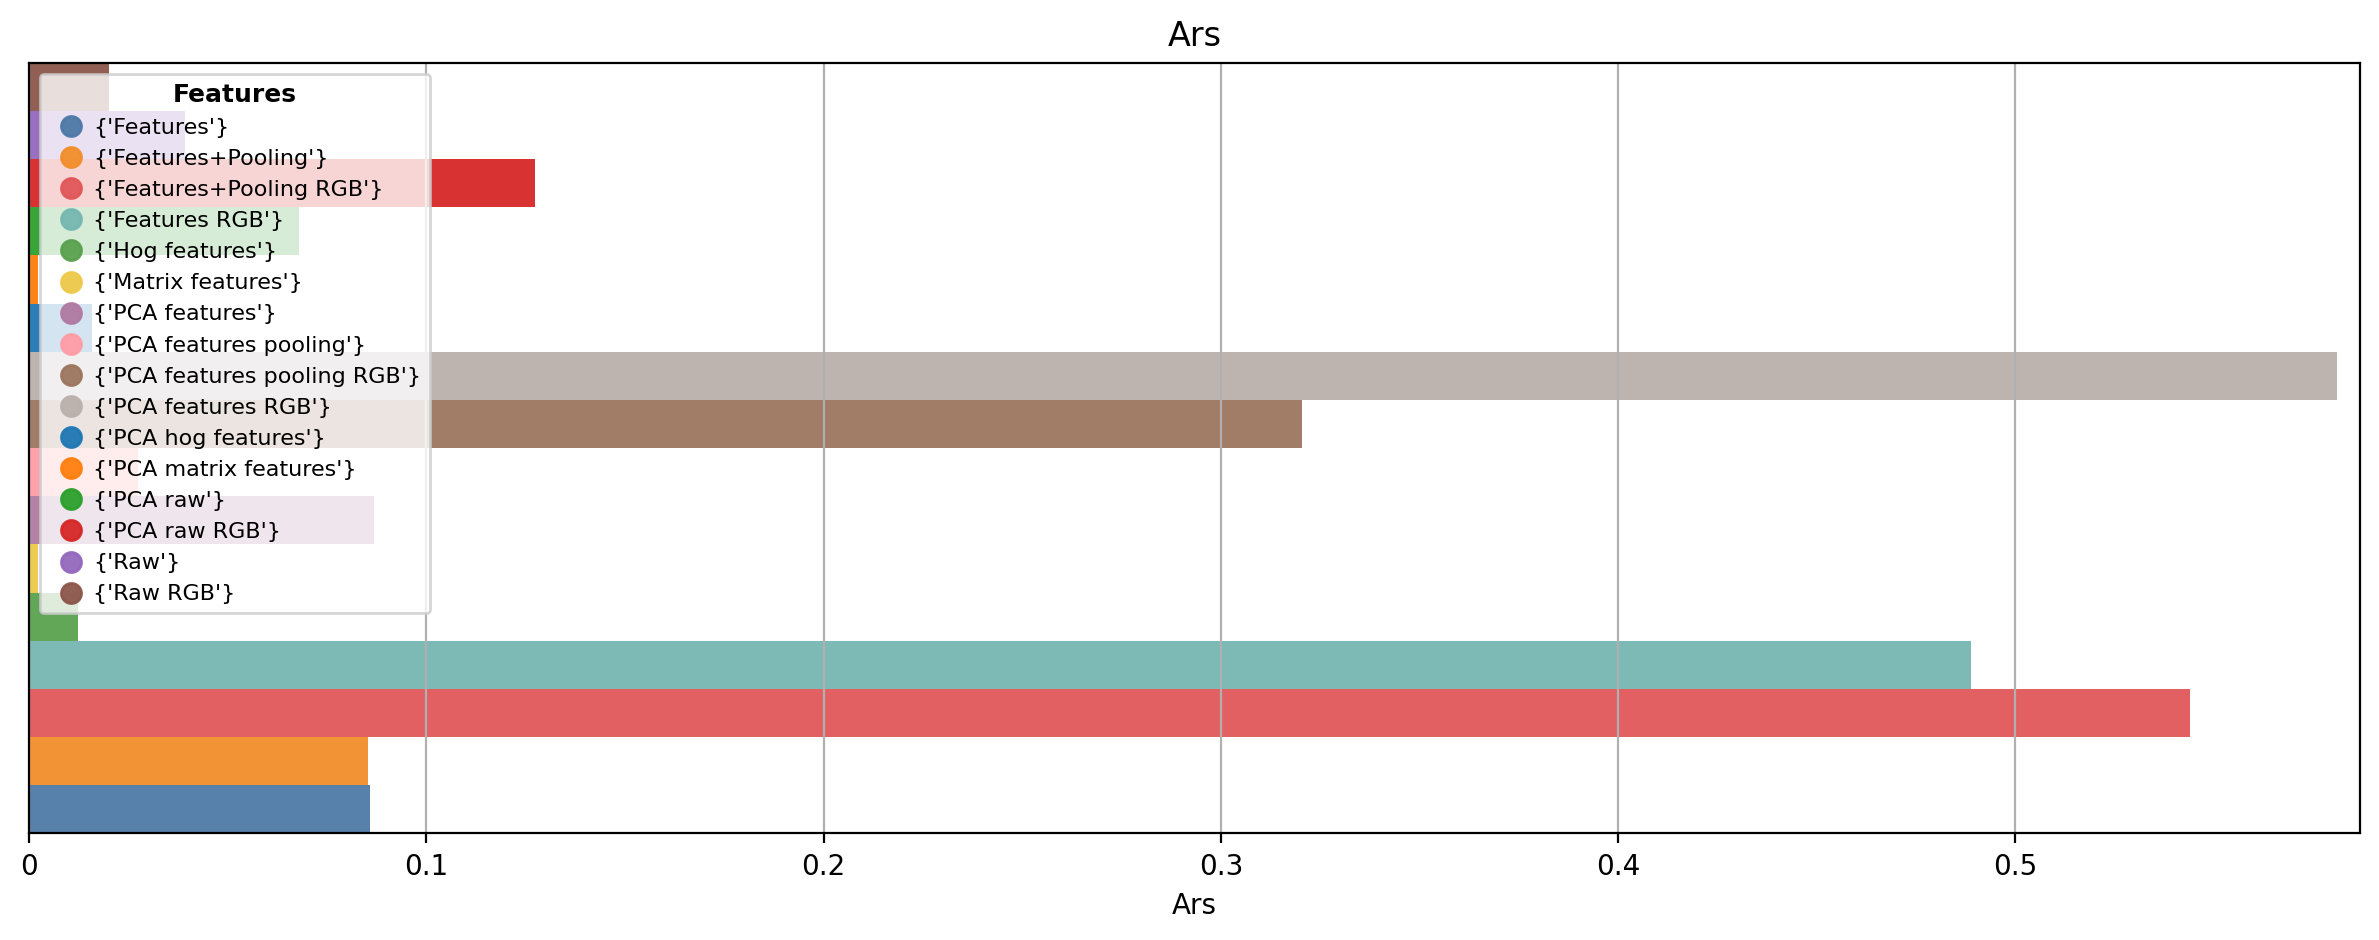

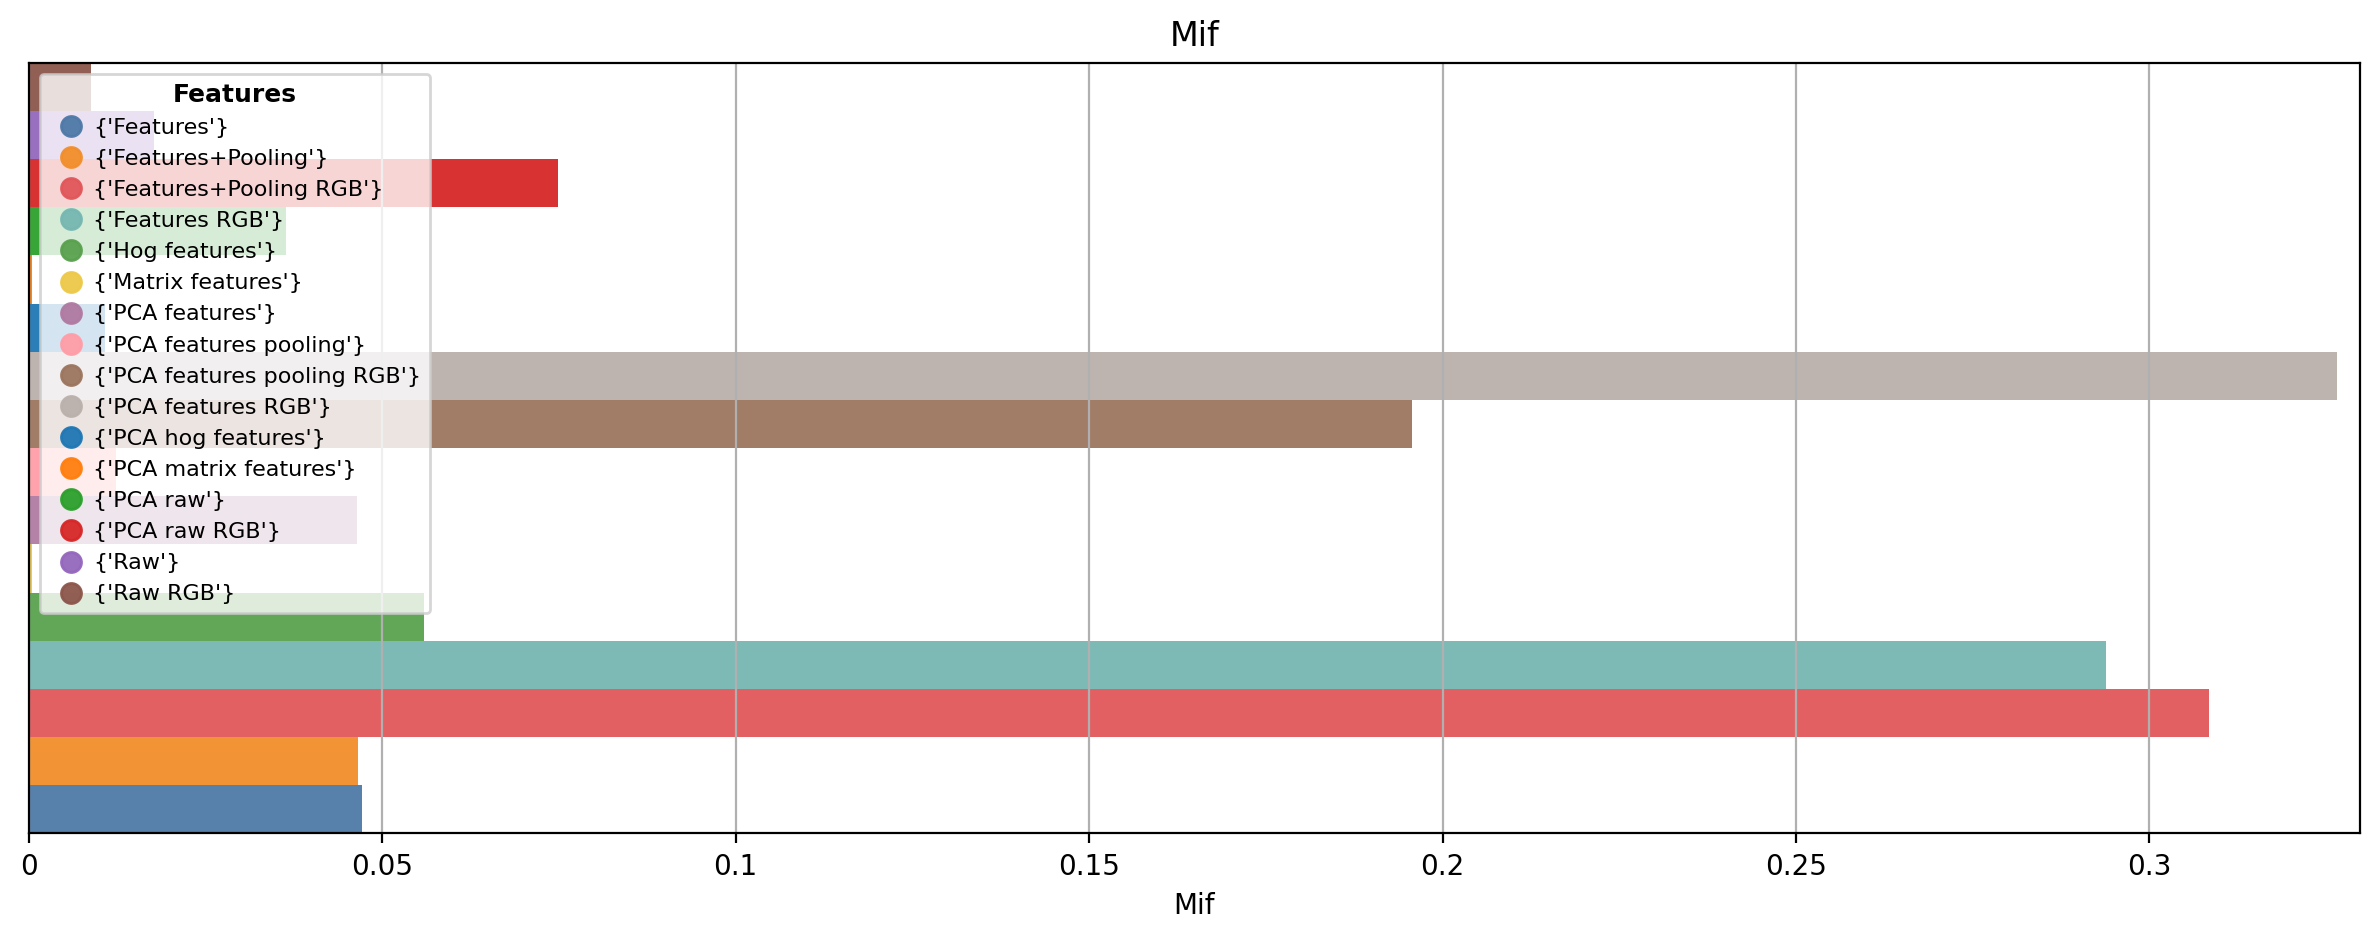

In [151]:
from barplots import barplots

barplots(
    results_in_clusteringDF_Agglomerative,
    groupby=["features"],
    orientation="horizontal",
    height=12,
    legend_position="upper left"
)